In [1]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import json
import os
import sys
import argparse
from transformers import AutoTokenizer, AutoModel
import sqlite3
import re
import unicodedata
import random

In [4]:
tagme_file = '/root/autodl-tmp/KernelGAT/data/tagme_bert_train.jsonl'
fever_file = '/root/autodl-tmp/KernelGAT/data/train.jsonl'
# 表名：documents
# 字段名：id    text    lines
db_file = '/root/autodl-tmp/KernelGAT/data/fever.db'
output_file = '/root/autodl-tmp/KernelGAT/data/gumbel_train.jsonl'

In [ ]:
import sqlite3

# 连接到SQLite数据库
conn = sqlite3.connect(db_file)

# 创建一个游标对象来执行SQL语句
cur = conn.cursor()

# 执行查询语句
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")

# 检索查询结果
tables = cur.fetchall()

# 打印表名
for table in tables:
    print(table[0])

# 关闭游标和连接
cur.close()
conn.close()


In [ ]:
import sqlite3

# 连接到SQLite数据库
conn = sqlite3.connect(db_file)

# 创建一个游标对象来执行SQL语句
cur = conn.cursor()

# 指定要查询的表名
table_name = 'documents'

# 执行查询语句
cur.execute("PRAGMA table_info({})".format(table_name))

# 检索查询结果
columns = cur.fetchall()

# 打印字段信息
for column in columns:
    print(column[1])  # 第二列包含字段名

# 关闭游标和连接
cur.close()
conn.close()


In [ ]:
import sqlite3

# 连接到SQLite数据库（如果不存在，将会创建一个新的）
conn = sqlite3.connect(db_file)

# 创建一个游标对象来执行SQL语句
cur = conn.cursor()

# 执行查询语句
cur.execute('SELECT * FROM documents LIMIT 1')  # my_table 是您的表名

# 检索查询结果
rows = cur.fetchall()  # 获取所有查询结果

# 打印查询结果
for row in rows:
    lines = row[2]
    lines = lines.split("\n")
    # print(lines)
    for line in lines:
        splits = line.split("\t")
        line_id, text = splits[0], splits[1]
        if len(text) > 0:
            print(line_id, text)

# 关闭游标和连接
cur.close()
conn.close()


In [39]:
conn = sqlite3.connect(db_file)

# 创建一个游标对象来执行SQL语句
cur = conn.cursor()

cur.execute("SELECT * FROM documents WHERE id = ?", ('Fox_Broadcasting_Company',))

# 检索查询结果
rows = cur.fetchall()
for row in rows:
    print(row)

('Fox_Broadcasting_Company', "The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox . The network is headquartered at the 20th Century Fox studio lot on Pico Boulevard in the Century City section of Los Angeles , with additional major offices and production facilities at the Fox Television Center in nearby West Los Angeles and the Fox Broadcasting Center in the Yorkville neighborhood of Manhattan , New York City . It is the third largest major television network in the world based on total revenues , assets , and international coverage .   Launched on October 9 , 1986 as a competitor to the Big Three television networks -LRB- ABC , NBC and CBS -RRB- , Fox went on to become the most successful attempt at a fourth television network . It was the highest-rated broadcast network in the 18 -- 49 demographic from 200

In [3]:
def file_line(file):
    line_num = 0
    with open(file, 'r') as f:
        for line in f:
            line_num += 1
    return line_num


def process_sent(sentence):
    sentence = re.sub(" LSB.*?RSB", "", sentence)
    sentence = re.sub("LRB RRB ", "", sentence)
    sentence = re.sub("LRB", "(", sentence)
    sentence = re.sub("RRB", ")", sentence)
    sentence = re.sub("--", "-", sentence)
    sentence = re.sub("``", '"', sentence)
    sentence = re.sub("''", '"', sentence)

    return sentence


def normalize(text):
    """Resolve different type of unicode encodings."""
    return unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')

def convert_brc(string):
    string = re.sub('-LRB-', '(', string)
    string = re.sub('-RRB-', ')', string)
    string = re.sub('-LSB-', '[', string)
    string = re.sub('-RSB-', ']', string)
    string = re.sub('-LCB-', '{', string)
    string = re.sub('-RCB-', '}', string)
    string = re.sub('-COLON-', ':', string)
    return string


# tagme_file = '/root/autodl-tmp/KernelGAT/data/tagme_bert_train.jsonl'
# fever_file = '/root/autodl-tmp/KernelGAT/data/train.jsonl'
# output_file = '/root/autodl-tmp/KernelGAT/data/gumbel_train.jsonl'

# tagme_file = '/root/autodl-tmp/KernelGAT/data/tagme_bert_test.jsonl'
# fever_file = '/root/autodl-tmp/KernelGAT/data/shared_task_test.jsonl'
# output_file = '/root/autodl-tmp/KernelGAT/data/gumbel_test.jsonl'

tagme_file = '/root/autodl-tmp/KernelGAT/data/tagme_bert_dev.jsonl'
fever_file = '/root/autodl-tmp/KernelGAT/data/shared_task_dev.jsonl'
output_file = '/root/autodl-tmp/KernelGAT/data/gumbel_dev.jsonl'
# 表名：documents
# 字段名：id    text    lines
db_file = '/root/autodl-tmp/KernelGAT/data/fever.db'



conn = sqlite3.connect(db_file)
cur = conn.cursor()

t_line_num = file_line(tagme_file)
f_line_num = file_line(fever_file)
print(t_line_num, f_line_num)
assert t_line_num == f_line_num, "两个文件行数不同"

# 由于kat已经将ground evidence加入，所以不需要再合并了
with open(tagme_file, 'r') as tf, \
     open(fever_file, 'r') as ff, \
     open(output_file, 'w') as wf:
    for t_line, f_line in tqdm(zip(tf, ff), total=t_line_num):
        t_data = json.loads(t_line)
        f_data = json.loads(f_line)
        assert t_data['id'] == f_data['id'], f"tagme_id: {t_data['id']}\tfever_id: {f_data['id']}"

        # print(json.dumps(t_data, indent=4))
        # print(json.dumps(f_data, indent=4))

        cand_docs_id = set()
        for evid in t_data['evidence']:
            cand_docs_id.add(evid[0])
        cand_docs = {}
        for doc_id in cand_docs_id:
            if doc_id not in cand_docs:
                cand_docs[doc_id] = []
            else:
                continue

            cur.execute("SELECT * FROM documents WHERE id = ?", (doc_id,))
            rows = cur.fetchall()
            if len(rows) == 0:
                doc_line_num = 0
                for evid in t_data['evidence']:
                    if doc_id == evid[0]:
                        doc_line_num = max(doc_line_num, evid[1])
                doc_line_num += 1
                cand_docs[doc_id] = [""] * doc_line_num
                for evid in t_data['evidence']:
                    if doc_id == evid[0]:
                        evid[2] = process_sent(evid[2])
                        doc_id, line_id, line_text, _ = evid
                        cand_docs[doc_id][line_id] = line_text
                # print(cand_docs)
            elif len(rows) == 1:
                doc_lines = rows[0][2]
                doc_lines = normalize(doc_lines)
                doc_lines = convert_brc(doc_lines)
                doc_lines = doc_lines.split('\n')
                for doc_line in doc_lines:
                    splits = doc_line.split('\t')
                    line_id, line_text = splits[0], splits[1]
                    cand_docs[doc_id].append(line_text)
            else:
                assert len(rows) <= 1, f"{doc_id}对应的记录数大于1"
        # print(json.dumps(cand_docs, indent=4))

        for evid in t_data['evidence']:
            evid[2] = process_sent(evid[2])
            doc_id, line_id, line_text, _ = evid
            cand_docs[doc_id][line_id] = line_text
        t_data['cand_docs'] = cand_docs
        # print(json.dumps(cand_docs, indent=4))

        # print(json.dumps(t_data, indent=4))
        wf.write(json.dumps(t_data) + '\n')

        # break

19998 19998


100%|██████████| 19998/19998 [00:04<00:00, 4556.90it/s]


In [13]:
text = "He became widely. known to a broad. audience for his current role. .as Ser Jaime Lannister. in the HBO series Game of Thrones"
sents = text.strip().split(".")
print(sents)

['He became widely', ' known to a broad', ' audience for his current role', ' ', 'as Ser Jaime Lannister', ' in the HBO series Game of Thrones']


In [ ]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer.all_special_tokens)
print(tokenizer.pad_token)
print(tokenizer.bos_token)
print(tokenizer.sep_token)
print(tokenizer.mask_token)
print(tokenizer.unk_token)

In [11]:
model_name = "/root/autodl-tmp/KernelGAT/hg_models/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer.all_special_tokens)
print(tokenizer.pad_token)
print(tokenizer.bos_token)
print(tokenizer.sep_token)
print(tokenizer.mask_token)
print(tokenizer.unk_token)
print(tokenizer.cls_token)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
[PAD]
None
[SEP]
[MASK]
[UNK]
[CLS]


In [14]:
token_sents = [tokenizer.tokenize(sent) for sent in sents]
print(token_sents)

if "bert-base-uncased" in model_name:
    BOS = tokenizer.cls_token
else:
    BOS = tokenizer.bos_token
SEP = tokenizer.sep_token

for tid in range(len(token_sents)):
    concat = []
    for i in range(tid):
        concat = concat + token_sents[i]
    concat = concat + [BOS] + token_sents[tid] + [SEP]
    for i in range(tid + 1, len(sents)):
        concat = concat + token_sents[i]
    sentence_start = concat.index(BOS) + 1
    sentence_end = concat.index(SEP)
    print(concat)
    print(token_sents[tid])
    print(concat[sentence_start:sentence_end])
    print("====" * 20)

[['he', 'became', 'widely'], ['known', 'to', 'a', 'broad'], ['audience', 'for', 'his', 'current', 'role'], [], ['as', 'ser', 'jaime', 'lan', '##nist', '##er'], ['in', 'the', 'hbo', 'series', 'game', 'of', 'throne', '##s']]
['[CLS]', 'he', 'became', 'widely', '[SEP]', 'known', 'to', 'a', 'broad', 'audience', 'for', 'his', 'current', 'role', 'as', 'ser', 'jaime', 'lan', '##nist', '##er', 'in', 'the', 'hbo', 'series', 'game', 'of', 'throne', '##s']
['he', 'became', 'widely']
['he', 'became', 'widely']
['he', 'became', 'widely', '[CLS]', 'known', 'to', 'a', 'broad', '[SEP]', 'audience', 'for', 'his', 'current', 'role', 'as', 'ser', 'jaime', 'lan', '##nist', '##er', 'in', 'the', 'hbo', 'series', 'game', 'of', 'throne', '##s']
['known', 'to', 'a', 'broad']
['known', 'to', 'a', 'broad']
['he', 'became', 'widely', 'known', 'to', 'a', 'broad', '[CLS]', 'audience', 'for', 'his', 'current', 'role', '[SEP]', 'as', 'ser', 'jaime', 'lan', '##nist', '##er', 'in', 'the', 'hbo', 'series', 'game', 'of',

In [25]:
tokenizer.tokenize("asbd [UNK] safa")

['as', '##b', '##d', '[UNK]', 'sa', '##fa']

In [2]:
def process_wiki_title(string):
    string = re.sub('-LRB-', '(', string)
    string = re.sub('-RRB-', ')', string)
    string = re.sub('-LSB-', '[', string)
    string = re.sub('-RSB-', ']', string)
    string = re.sub('-LCB-', '{', string)
    string = re.sub('-RCB-', '}', string)
    string = re.sub('-COLON-', ':', string)
    string = re.sub("_", " ", string)
    return string

def process_sent(sentence):
    sentence = re.sub(" LSB.*?RSB", "", sentence)
    sentence = re.sub("LRB RRB ", "", sentence)
    sentence = re.sub("LRB", "(", sentence)
    sentence = re.sub("RRB", ")", sentence)
    sentence = re.sub("--", "-", sentence)
    sentence = re.sub("``", '"', sentence)
    sentence = re.sub("''", '"', sentence)

    return sentence

def normalize(text):
    """Resolve different type of unicode encodings."""
    return unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')

def convert_brc(string):
    string = re.sub('-LRB-', '(', string)
    string = re.sub('-RRB-', ')', string)
    string = re.sub('-LSB-', '[', string)
    string = re.sub('-RSB-', ']', string)
    string = re.sub('-LCB-', '{', string)
    string = re.sub('-RCB-', '}', string)
    string = re.sub('-COLON-', ':', string)
    return string

In [93]:
import json
intra_lens = []
with open('/root/autodl-tmp/KernelGAT/data/gumbel_train.jsonl', 'r') as f, \
    open('/root/autodl-tmp/KernelGAT/data/gumbel_missinfo.jsonl', 'w') as wf:
    for line in f:
        data = json.loads(line)
        if len(data['evidence']) != 5:
            wf.write(json.dumps(data) + '\n')

In [90]:
import json
intra_lens = []
with open('/root/autodl-tmp/KernelGAT/data/gumbel_train.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        # print(json.dumps(data, indent=4))
        claim = data['claim']
        cand_docs = data['cand_docs']
        if len(data['evidence']) == 0:
            continue
        for evid in data['evidence']:
            doc_id, sent_id, sent_text, _ = evid
            prev, post = [], []
            idx = sent_id - 1
            while idx >= 0 and len(prev) < 2:
                text = cand_docs[doc_id][idx]
                if text != "":
                    prev.insert(0, text)
                idx -= 1
            idx = sent_id + 1
            while idx < len(cand_docs[doc_id]) and len(post) < 2:
                text = cand_docs[doc_id][idx]
                if text != "":
                    post.append(text)
                idx += 1
            intra_sents = [process_wiki_title(doc_id)] + prev + [sent_text] + post
            intra_sents = claim + tokenizer.sep_token + tokenizer.unk_token.join(intra_sents) + tokenizer.unk_token
            intra_sents_tokens = tokenizer.tokenize(intra_sents)
            intra_lens.append(len(intra_sents_tokens))


In [ ]:
import json

def get_sent_labels(evidences):
    sent_labels = []
    for evid in evidences:
        if evid[3] == 1:
            sent_labels.append(1)
        else:
            sent_labels.append(0)
    pad_num = 5 - len(sent_labels)
    for _ in range(pad_num):
        sent_labels.append(0)
    return sent_labels
        

with open('/root/autodl-tmp/KernelGAT/data/gumbel_missinfo.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        evidences = data['evidence']
        sent_label = get_sent_labels(evidences)
        print(len(evidences), sent_label)
        print("=====" * 20)



In [60]:
def get_max_nested_length(lst):
    max_len = 0
    for item in lst:
        if isinstance(item, list):
            
    return max_len

def pad_nested_list(lst):
    max_len = get_max_nested_length(lst)
    
    def pad(lst, target_len):
        if isinstance(lst, list):
            for i in range(len(lst)):
                lst[i] = pad(lst[i], target_len)
            if len(lst) < target_len:
                lst.extend([None] * (target_len - len(lst)))
        return lst

    return pad(lst, max_len)

# 示例
nested_list = [[1, 2], [3, 4, 5], [[6, 7], [8]], [9]]
result = pad_nested_list(nested_list)
print(result)


[[1, 2], [3, 4, 5], [[6, 7], [8]], [9]]


In [3]:
from transformers import AutoTokenizer, AutoModel
model_name = '/root/autodl-tmp/KernelGAT/hg_models/bigbird-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, attention_type="original_full")

In [6]:
from torch.utils.data import Dataset, DataLoader
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


class FeverDataset(Dataset):
    def __init__(self, 
                 file_path,
                 tokenizer,
                 max_len,
                 evid_num=5,
                 train=False):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.evid_num = evid_num
        self.train = train
        self.label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT ENOUGH INFO': 2}
        self.data = self.read_file(file_path)

    def __len__(self):
        return len(self.data)
    
    def compare_origin_and_chosen_tokens(self, orgin, tokens, chosen_mask):
        print(orgin)
        chosen_tokens = []
        # print(tokens)
        # print(chosen_mask)
        for msk, token in zip(chosen_mask, tokens):
            if msk == 1:
                chosen_tokens.append(token)
        chosen_tokens = self.tokenizer.convert_tokens_to_string(chosen_tokens)
        print(chosen_tokens)


    def inter_tokens_and_masks(self, claim, evidences):
        inter_sents = claim + tokenizer.sep_token
        for i in range(len(evidences)):
            evid = evidences[i]
            evid_title, evid_sent = evid[0], evid[2]
            inter_sents += process_wiki_title(evid_title) + tokenizer.unk_token + evid_sent + tokenizer.sep_token
        inter_sents_tokens = tokenizer.tokenize(inter_sents)
        SEP_indices = [index for index, value in enumerate(inter_sents_tokens) if value == tokenizer.sep_token]
        # print("inter:\n", inter_sents)
        # print("inter:\n", len(inter_sents_tokens))

        inter_sents_tokens_masks = []
        s = 0
        prefix_len = 0
        token_len = len(inter_sents_tokens)
        for i in range(len(SEP_indices)):
            if i > 0:
                s = SEP_indices[i - 1] + 1
            e = SEP_indices[i]
            chosen_len = e - s
            cur_mask = prefix_len * [0] + [1] * chosen_len + [0] * (token_len - prefix_len - chosen_len)
            inter_sents_tokens_masks.append(cur_mask)
            prefix_len = prefix_len + chosen_len + 1
        # origins = [claim] + [(evid[0], evid[2]) for evid in evidences]
        # for i in range(len(origins)):
        #     origin = origins[i]
        #     cur_mask = inter_sents_tokens_masks[i]
        #     cur_tokens = inter_sents_tokens
        #     self.compare_origin_and_chosen_tokens(orgin=origin, tokens=cur_tokens, chosen_mask=cur_mask)
        inter_sents_tokens = self.tokenizer.convert_tokens_to_ids(inter_sents_tokens)
        inter_sents_attention_mask = [1] * len(inter_sents_tokens)
        return inter_sents_tokens, inter_sents_tokens_masks, inter_sents_attention_mask

    def intra_tokens_and_masks(self, claim, evidences, cand_docs):
        intra_sents_tokens_list = []
        intra_sents_tokens_masks = []
        for evid in evidences:
            doc_id, sent_id, sent_text, _ = evid
            prev, post = [], []
            idx = sent_id - 1
            while idx >= 0 and len(prev) < 2:
                text = cand_docs[doc_id][idx]
                if text != "":
                    prev.insert(0, text)
                idx -= 1
            idx = sent_id + 1
            while idx < len(cand_docs[doc_id]) and len(post) < 2:
                text = cand_docs[doc_id][idx]
                if text != "":
                    post.append(text)
                idx += 1
            intra_sents = [process_wiki_title(doc_id)] + prev + [sent_text] + post
            intra_sents = claim + tokenizer.sep_token + tokenizer.unk_token.join(intra_sents) + tokenizer.unk_token
            intra_sents_tokens = tokenizer.tokenize(intra_sents)
            intra_sents_tokens_list.append(intra_sents_tokens)
            UNK_indices = [index for index, value in enumerate(intra_sents_tokens) if value == tokenizer.unk_token]
            SEP_indice = intra_sents_tokens.index(self.tokenizer.sep_token)
            sent_id = len(prev)
            # token:    x [SEP] x x x [UNK] x x [UNK] x x  x  x  [UNK] 
            # id:       0   1   2 3 4   5   6 7   8   9 10 11 12  13
            # highlight:_   _   * _ _   *   _ _   _   * _  _  _   *
            title_s, title_e = SEP_indice + 1, UNK_indices[0]
            sent_s, sent_e = UNK_indices[sent_id] + 1, UNK_indices[sent_id + 1]
            title_len = title_e - title_s
            sent_len = sent_e - sent_s
            gap_len = sent_s - title_e
            cur_mask = [0] * title_s + [1] * title_len + [0] * gap_len + [1] * sent_len
            cur_mask += [0] * (len(intra_sents_tokens) - len(cur_mask))
            intra_sents_tokens_masks.append(cur_mask)
            assert len(cur_mask) == len(intra_sents_tokens)
            # self.compare_origin_and_chosen_tokens(orgin=(doc_id, sent_text), tokens=intra_sents_tokens, chosen_mask=cur_mask)
        # print(intra_sents_tokens_list)
        intra_sents_tokens_list = [self.tokenizer.convert_tokens_to_ids(item) for item in intra_sents_tokens_list]
        intra_sents_attention_masks = [[1] * len(item) for item in intra_sents_tokens_list]

        return intra_sents_tokens_list, intra_sents_tokens_masks, intra_sents_attention_masks

    def pad_placeholder_evidence(self, evidences):
        pad_num = self.evid_num - len(evidences)
        for _ in range(pad_num):
            doc_id = self.tokenizer.pad_token
            sent_id = 0
            sent_text = self.tokenizer.pad_token * 20
            sent_label = 0
            evid = [doc_id, sent_id, sent_text, sent_label]
            evidences.append(evid)
        return evidences


    def pad_placeholder_cand_docs(self, cand_docs):
        doc_id = self.tokenizer.pad_token
        sents = [self.tokenizer.pad_token * 20]
        cand_docs[doc_id] = sents
        return cand_docs


    def read_file(self, file_path):
        res = []
        with open(file_path, 'r') as f:
            for line in f:
                sample = json.loads(line)
                if 'test' in file_path:
                    sample['label'] = 0
                else:
                    sample['label'] = self.label_map[sample['label']]
                sample['claim'] = process_sent(sample['claim'])
                for evid in sample['evidence']:
                    evid[2] = process_sent(evid[2])
                sample['evidence'] = self.pad_placeholder_evidence(sample['evidence'])
                sample['cand_docs'] = self.pad_placeholder_cand_docs(sample['cand_docs'])
                res.append(sample)
        return res
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        # print(json.dumps(data, indent=4))
        claim = sample['claim']
        label = sample['label']
        if self.train:
            random.shuffle(sample['evidence'])
        sent_label = [1 if evid[3] == 1 else 0 for evid in sample['evidence']]
        intra_sents_tokens_list, intra_sents_tokens_masks, intra_sents_attention_masks = self.intra_tokens_and_masks(claim, sample['evidence'], sample['cand_docs'])
        # # print("=====" * 20)
        inter_sents_tokens, inter_sents_tokens_masks, inter_sents_attention_mask = self.inter_tokens_and_masks(claim, sample['evidence'])

        sample = {
            "claim": claim,
            "label": label,
            "sent_label": sent_label,
            "intra_sents_tokens_list": intra_sents_tokens_list,
            "intra_sents_tokens_masks": intra_sents_tokens_masks,
            "intra_sents_attention_masks": intra_sents_attention_masks,
            "inter_sents_tokens": inter_sents_tokens,
            "inter_sents_tokens_masks": inter_sents_tokens_masks,
            "inter_sents_attention_mask": inter_sents_attention_mask,
        }

        # print("====" * 20)

        return sample

def pad_to_max_len(b_lst, pad):
    lens = [len(lst) for lst in b_lst]
    max_len = max(lens)
    # print("max_len: ", max_len, lens)
    for i in range(len(b_lst)):
        b_lst[i] = b_lst[i] +  [pad] * (max_len - len(b_lst[i]))
    return b_lst


def collate(samples):
    if len(samples) == 0:
        return {}
    b_labels = [sample['label'] for sample in samples]
    b_sent_labels = [sample['sent_label'] for sample in samples]

    # intra
    b_intra_sents_tokens = []
    for sample in samples:
        b_intra_sents_tokens.extend(sample['intra_sents_tokens_list'])
    b_intra_sents_tokens = pad_to_max_len(b_intra_sents_tokens, tokenizer.pad_token_id)

    b_intra_sents_tokens_masks = []
    for sample in samples:
        b_intra_sents_tokens_masks.extend(sample['intra_sents_tokens_masks'])
    b_intra_sents_tokens_masks = pad_to_max_len(b_intra_sents_tokens_masks, 0)

    b_intra_sents_attention_masks = []
    for sample in samples:
        b_intra_sents_attention_masks.extend(sample['intra_sents_attention_masks'])
    b_intra_sents_attention_masks = pad_to_max_len(b_intra_sents_attention_masks, 0)

    # inter
    b_inter_sents_tokens = [sample['inter_sents_tokens'] for sample in samples]
    b_inter_sents_tokens = pad_to_max_len(b_inter_sents_tokens, tokenizer.pad_token_id)

    b_inter_sents_tokens_masks = []
    for sample in samples:
        b_inter_sents_tokens_masks.extend(sample['inter_sents_tokens_masks'])
    b_inter_sents_tokens_masks = pad_to_max_len(b_inter_sents_tokens_masks, 0)

    b_inter_sents_attention_mask = [sample['inter_sents_attention_mask'] for sample in samples]
    b_inter_sents_attention_mask = pad_to_max_len(b_inter_sents_attention_mask, 0)

    res = {
        "b_labels": b_labels,
        "b_sent_labels": b_sent_labels,
        "b_intra_sents_tokens": b_intra_sents_tokens,
        "b_intra_sents_tokens_masks": b_intra_sents_tokens_masks,
        "b_intra_sents_attention_masks": b_intra_sents_attention_masks,
        "b_inter_sents_tokens": b_inter_sents_tokens,
        "b_inter_sents_tokens_masks": b_inter_sents_tokens_masks,
        "b_inter_sents_attention_mask": b_inter_sents_attention_mask
    }

    # print(json.dumps(res, indent=4))

    for k, v in res.items():
        res[k] = torch.tensor(v)
        # print(k, res[k].shape)
    return res


model_name = '/root/autodl-tmp/KernelGAT/hg_models/bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)


train_file = '/root/autodl-tmp/KernelGAT/data/gumbel_train.jsonl'
train_dataset = FeverDataset(
                    file_path=train_file,
                    tokenizer=tokenizer,
                    max_len=600,
                    evid_num=5,
                    train=True
                    )
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate, pin_memory=True, num_workers=10)
# model.cuda()
model.eval()
for batch in tqdm(train_dataloader):
    with torch.no_grad():
        print(batch.keys())
        for k, v in batch.items():
            batch[k] = v.cuda()
        intra_input_ids = batch['b_intra_sents_tokens']
        intra_attention_masks = batch['b_intra_sents_attention_masks']
        print(intra_input_ids.shape)
        print(intra_attention_masks.shape)
        inter_embs = model(input_ids=intra_input_ids, attention_mask=intra_attention_masks)[0]
        print(inter_embs.shape)
        # intra_embs = model()
        # pass
        # print(batch)
        # print("=====" * 20)
        # break

  0%|          | 1/4546 [00:01<1:40:28,  1.33s/it]

dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])
torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 2/4546 [00:02<1:11:26,  1.06it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 3/4546 [00:02<1:02:45,  1.21it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 4/4546 [00:03<1:02:32,  1.21it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 5/4546 [00:04<57:22,  1.32it/s]  

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 6/4546 [00:04<57:20,  1.32it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 7/4546 [00:05<54:04,  1.40it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 8/4546 [00:06<54:38,  1.38it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 9/4546 [00:06<52:39,  1.44it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 10/4546 [00:07<53:06,  1.42it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 11/4546 [00:08<53:22,  1.42it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 12/4546 [00:09<56:42,  1.33it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 13/4546 [00:09<57:06,  1.32it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 14/4546 [00:10<59:19,  1.27it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 15/4546 [00:11<57:35,  1.31it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 16/4546 [00:12<57:05,  1.32it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 17/4546 [00:12<53:01,  1.42it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 18/4546 [00:13<51:42,  1.46it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 19/4546 [00:14<51:21,  1.47it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 20/4546 [00:14<50:16,  1.50it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 21/4546 [00:15<51:24,  1.47it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  0%|          | 22/4546 [00:16<52:05,  1.45it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 23/4546 [00:16<49:57,  1.51it/s]

torch.Size([160, 333])
torch.Size([160, 333])
torch.Size([160, 333, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 24/4546 [00:17<53:35,  1.41it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 25/4546 [00:18<54:01,  1.39it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 26/4546 [00:19<57:13,  1.32it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 27/4546 [00:20<57:31,  1.31it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 28/4546 [00:20<53:22,  1.41it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 29/4546 [00:21<50:49,  1.48it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 30/4546 [00:21<50:11,  1.50it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 31/4546 [00:22<51:59,  1.45it/s]

torch.Size([160, 357])
torch.Size([160, 357])
torch.Size([160, 357, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 32/4546 [00:23<55:07,  1.36it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 33/4546 [00:24<53:49,  1.40it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 34/4546 [00:24<55:09,  1.36it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 35/4546 [00:25<55:05,  1.36it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 36/4546 [00:26<54:04,  1.39it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 37/4546 [00:26<52:47,  1.42it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 38/4546 [00:27<54:43,  1.37it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 39/4546 [00:28<52:40,  1.43it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 40/4546 [00:29<54:37,  1.37it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 41/4546 [00:29<52:30,  1.43it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 42/4546 [00:30<53:00,  1.42it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 43/4546 [00:31<54:36,  1.37it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 44/4546 [00:31<52:45,  1.42it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 45/4546 [00:32<56:02,  1.34it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 46/4546 [00:33<58:55,  1.27it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 47/4546 [00:34<58:58,  1.27it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 48/4546 [00:35<56:42,  1.32it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 49/4546 [00:36<59:52,  1.25it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 50/4546 [00:36<56:42,  1.32it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 51/4546 [00:37<53:56,  1.39it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 52/4546 [00:38<53:42,  1.39it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 53/4546 [00:38<53:04,  1.41it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 54/4546 [00:39<55:59,  1.34it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 55/4546 [00:40<54:04,  1.38it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|          | 56/4546 [00:40<53:01,  1.41it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|▏         | 57/4546 [00:41<56:15,  1.33it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|▏         | 58/4546 [00:42<53:55,  1.39it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|▏         | 59/4546 [00:43<58:04,  1.29it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|▏         | 60/4546 [00:44<56:54,  1.31it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|▏         | 61/4546 [00:44<52:36,  1.42it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|▏         | 62/4546 [00:45<52:39,  1.42it/s]

torch.Size([160, 356])
torch.Size([160, 356])
torch.Size([160, 356, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|▏         | 63/4546 [00:46<56:51,  1.31it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|▏         | 64/4546 [00:47<57:57,  1.29it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|▏         | 65/4546 [00:47<55:58,  1.33it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|▏         | 66/4546 [00:48<57:35,  1.30it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|▏         | 67/4546 [00:49<59:38,  1.25it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  1%|▏         | 68/4546 [00:50<57:18,  1.30it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 69/4546 [00:50<57:23,  1.30it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 70/4546 [00:51<55:46,  1.34it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 71/4546 [00:52<54:26,  1.37it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 72/4546 [00:52<53:11,  1.40it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 73/4546 [00:53<53:10,  1.40it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 74/4546 [00:54<52:57,  1.41it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 75/4546 [00:55<54:43,  1.36it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 76/4546 [00:55<53:34,  1.39it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 77/4546 [00:56<51:50,  1.44it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 78/4546 [00:57<50:20,  1.48it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 79/4546 [00:57<52:26,  1.42it/s]

torch.Size([160, 349])
torch.Size([160, 349])
torch.Size([160, 349, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 80/4546 [00:58<55:56,  1.33it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 81/4546 [00:59<55:08,  1.35it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 82/4546 [01:00<51:58,  1.43it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 83/4546 [01:00<51:08,  1.45it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 84/4546 [01:01<50:49,  1.46it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 85/4546 [01:02<55:10,  1.35it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 86/4546 [01:03<55:53,  1.33it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 87/4546 [01:03<54:03,  1.37it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 88/4546 [01:04<57:58,  1.28it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 89/4546 [01:05<59:06,  1.26it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 90/4546 [01:06<56:36,  1.31it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 91/4546 [01:06<55:38,  1.33it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 92/4546 [01:07<52:16,  1.42it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 93/4546 [01:08<52:41,  1.41it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 94/4546 [01:08<53:58,  1.37it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 95/4546 [01:09<53:06,  1.40it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 96/4546 [01:10<54:01,  1.37it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 97/4546 [01:11<55:44,  1.33it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 98/4546 [01:11<55:12,  1.34it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 99/4546 [01:12<56:33,  1.31it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 100/4546 [01:13<56:43,  1.31it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 101/4546 [01:14<55:38,  1.33it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 102/4546 [01:15<57:45,  1.28it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 103/4546 [01:15<56:04,  1.32it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 104/4546 [01:16<52:03,  1.42it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 105/4546 [01:16<48:54,  1.51it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 106/4546 [01:17<50:46,  1.46it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 107/4546 [01:18<51:14,  1.44it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 108/4546 [01:19<51:47,  1.43it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 109/4546 [01:19<49:33,  1.49it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 110/4546 [01:20<47:55,  1.54it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 111/4546 [01:20<46:09,  1.60it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 112/4546 [01:21<50:40,  1.46it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  2%|▏         | 113/4546 [01:22<49:24,  1.50it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 114/4546 [01:23<50:41,  1.46it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 115/4546 [01:23<51:38,  1.43it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 116/4546 [01:24<50:59,  1.45it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 117/4546 [01:25<50:55,  1.45it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 118/4546 [01:25<53:06,  1.39it/s]

torch.Size([160, 366])
torch.Size([160, 366])
torch.Size([160, 366, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 119/4546 [01:26<57:21,  1.29it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 120/4546 [01:27<56:54,  1.30it/s]

torch.Size([160, 234])
torch.Size([160, 234])
torch.Size([160, 234, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 121/4546 [01:28<51:57,  1.42it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 122/4546 [01:28<54:10,  1.36it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 123/4546 [01:29<51:49,  1.42it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 124/4546 [01:30<51:50,  1.42it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 125/4546 [01:30<51:57,  1.42it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 126/4546 [01:31<52:05,  1.41it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 127/4546 [01:32<52:23,  1.41it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 128/4546 [01:33<53:20,  1.38it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 129/4546 [01:33<52:49,  1.39it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 130/4546 [01:34<52:37,  1.40it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 131/4546 [01:35<51:37,  1.43it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 132/4546 [01:35<52:55,  1.39it/s]

torch.Size([160, 371])
torch.Size([160, 371])
torch.Size([160, 371, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 133/4546 [01:36<57:22,  1.28it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 134/4546 [01:37<54:58,  1.34it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 135/4546 [01:38<51:43,  1.42it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 136/4546 [01:39<54:54,  1.34it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 137/4546 [01:39<53:30,  1.37it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 138/4546 [01:40<55:06,  1.33it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 139/4546 [01:41<52:46,  1.39it/s]

torch.Size([160, 422])
torch.Size([160, 422])
torch.Size([160, 422, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 140/4546 [01:42<1:01:04,  1.20it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 141/4546 [01:42<56:58,  1.29it/s]  

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 142/4546 [01:43<54:27,  1.35it/s]

torch.Size([160, 425])
torch.Size([160, 425])
torch.Size([160, 425, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 143/4546 [01:44<1:02:17,  1.18it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 144/4546 [01:45<56:49,  1.29it/s]  

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 145/4546 [01:46<56:44,  1.29it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 146/4546 [01:46<55:20,  1.33it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 147/4546 [01:47<51:21,  1.43it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 148/4546 [01:48<52:37,  1.39it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 149/4546 [01:48<52:50,  1.39it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 150/4546 [01:49<55:55,  1.31it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 151/4546 [01:50<53:16,  1.38it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 152/4546 [01:50<51:29,  1.42it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 153/4546 [01:51<54:19,  1.35it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 154/4546 [01:52<52:06,  1.40it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 155/4546 [01:53<53:27,  1.37it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 156/4546 [01:53<54:06,  1.35it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 157/4546 [01:54<51:04,  1.43it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 158/4546 [01:55<53:20,  1.37it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  3%|▎         | 159/4546 [01:55<50:08,  1.46it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▎         | 160/4546 [01:56<50:09,  1.46it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▎         | 161/4546 [01:57<51:05,  1.43it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▎         | 162/4546 [01:58<50:12,  1.46it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▎         | 163/4546 [01:58<53:24,  1.37it/s]

torch.Size([160, 364])
torch.Size([160, 364])
torch.Size([160, 364, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▎         | 164/4546 [01:59<57:14,  1.28it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▎         | 165/4546 [02:00<55:11,  1.32it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▎         | 166/4546 [02:01<57:10,  1.28it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▎         | 167/4546 [02:02<56:04,  1.30it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▎         | 168/4546 [02:02<52:18,  1.39it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▎         | 169/4546 [02:03<49:46,  1.47it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▎         | 170/4546 [02:03<51:06,  1.43it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 171/4546 [02:04<51:23,  1.42it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 172/4546 [02:05<50:58,  1.43it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 173/4546 [02:06<51:36,  1.41it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 174/4546 [02:06<51:10,  1.42it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 175/4546 [02:07<50:36,  1.44it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 176/4546 [02:08<49:28,  1.47it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 177/4546 [02:08<51:14,  1.42it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 178/4546 [02:09<52:45,  1.38it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 179/4546 [02:10<52:00,  1.40it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 180/4546 [02:11<52:45,  1.38it/s]

torch.Size([160, 427])
torch.Size([160, 427])
torch.Size([160, 427, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 181/4546 [02:12<1:01:08,  1.19it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 182/4546 [02:12<55:27,  1.31it/s]  

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 183/4546 [02:13<54:48,  1.33it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 184/4546 [02:14<57:22,  1.27it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 185/4546 [02:15<58:20,  1.25it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 186/4546 [02:15<57:23,  1.27it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 187/4546 [02:16<57:18,  1.27it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 188/4546 [02:17<55:24,  1.31it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 189/4546 [02:18<54:39,  1.33it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 190/4546 [02:18<53:55,  1.35it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 191/4546 [02:19<52:40,  1.38it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 192/4546 [02:20<52:46,  1.37it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 193/4546 [02:21<54:32,  1.33it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 194/4546 [02:21<52:46,  1.37it/s]

torch.Size([160, 239])
torch.Size([160, 239])
torch.Size([160, 239, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 195/4546 [02:22<49:06,  1.48it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 196/4546 [02:22<47:28,  1.53it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 197/4546 [02:23<51:42,  1.40it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 198/4546 [02:24<49:15,  1.47it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 199/4546 [02:25<51:34,  1.40it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 200/4546 [02:25<51:28,  1.41it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 201/4546 [02:26<52:48,  1.37it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 202/4546 [02:27<50:39,  1.43it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 203/4546 [02:28<53:35,  1.35it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  4%|▍         | 204/4546 [02:28<54:47,  1.32it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 205/4546 [02:29<55:18,  1.31it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 206/4546 [02:30<55:30,  1.30it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 207/4546 [02:31<54:30,  1.33it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 208/4546 [02:32<55:13,  1.31it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 209/4546 [02:32<56:04,  1.29it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 210/4546 [02:33<52:10,  1.39it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 211/4546 [02:34<49:04,  1.47it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 212/4546 [02:34<46:53,  1.54it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 213/4546 [02:35<50:53,  1.42it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 214/4546 [02:36<55:08,  1.31it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 215/4546 [02:37<53:42,  1.34it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 216/4546 [02:37<52:55,  1.36it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 217/4546 [02:38<49:32,  1.46it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 218/4546 [02:38<48:19,  1.49it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 219/4546 [02:39<50:47,  1.42it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 220/4546 [02:40<48:24,  1.49it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 221/4546 [02:40<48:22,  1.49it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 222/4546 [02:41<46:24,  1.55it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 223/4546 [02:42<46:08,  1.56it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 224/4546 [02:42<46:10,  1.56it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 225/4546 [02:43<47:27,  1.52it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 226/4546 [02:44<46:43,  1.54it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▍         | 227/4546 [02:44<45:10,  1.59it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 228/4546 [02:45<46:44,  1.54it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 229/4546 [02:46<49:37,  1.45it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 230/4546 [02:46<48:17,  1.49it/s]

torch.Size([160, 395])
torch.Size([160, 395])
torch.Size([160, 395, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 231/4546 [02:47<55:46,  1.29it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 232/4546 [02:48<52:41,  1.36it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 233/4546 [02:49<50:25,  1.43it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 234/4546 [02:49<53:15,  1.35it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 235/4546 [02:50<52:35,  1.37it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 236/4546 [02:51<49:40,  1.45it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 237/4546 [02:52<52:02,  1.38it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 238/4546 [02:52<52:24,  1.37it/s]

torch.Size([160, 239])
torch.Size([160, 239])
torch.Size([160, 239, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 239/4546 [02:53<48:41,  1.47it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 240/4546 [02:54<48:47,  1.47it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 241/4546 [02:54<50:47,  1.41it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 242/4546 [02:55<51:01,  1.41it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 243/4546 [02:56<50:45,  1.41it/s]

torch.Size([160, 357])
torch.Size([160, 357])
torch.Size([160, 357, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 244/4546 [02:57<54:39,  1.31it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 245/4546 [02:57<54:10,  1.32it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 246/4546 [02:58<53:16,  1.35it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 247/4546 [02:59<51:46,  1.38it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 248/4546 [02:59<51:01,  1.40it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 249/4546 [03:00<50:12,  1.43it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  5%|▌         | 250/4546 [03:01<50:10,  1.43it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 251/4546 [03:01<49:10,  1.46it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 252/4546 [03:02<50:40,  1.41it/s]

torch.Size([160, 394])
torch.Size([160, 394])
torch.Size([160, 394, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 253/4546 [03:03<57:17,  1.25it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 254/4546 [03:04<54:25,  1.31it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 255/4546 [03:05<54:39,  1.31it/s]

torch.Size([160, 236])
torch.Size([160, 236])
torch.Size([160, 236, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 256/4546 [03:05<50:08,  1.43it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 257/4546 [03:06<48:35,  1.47it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 258/4546 [03:07<50:11,  1.42it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 259/4546 [03:07<48:34,  1.47it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 260/4546 [03:08<48:58,  1.46it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 261/4546 [03:09<48:54,  1.46it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 262/4546 [03:09<46:12,  1.55it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 263/4546 [03:10<48:32,  1.47it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 264/4546 [03:11<48:55,  1.46it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 265/4546 [03:11<50:03,  1.43it/s]

torch.Size([160, 226])
torch.Size([160, 226])
torch.Size([160, 226, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 266/4546 [03:12<46:14,  1.54it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 267/4546 [03:13<48:52,  1.46it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 268/4546 [03:14<52:15,  1.36it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 269/4546 [03:14<51:15,  1.39it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 270/4546 [03:15<52:07,  1.37it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 271/4546 [03:16<51:51,  1.37it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 272/4546 [03:16<49:02,  1.45it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 273/4546 [03:17<48:45,  1.46it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 274/4546 [03:18<47:50,  1.49it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 275/4546 [03:18<47:12,  1.51it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 276/4546 [03:19<49:48,  1.43it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 277/4546 [03:20<51:34,  1.38it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 278/4546 [03:21<50:47,  1.40it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 279/4546 [03:21<52:40,  1.35it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 280/4546 [03:22<51:24,  1.38it/s]

torch.Size([160, 236])
torch.Size([160, 236])
torch.Size([160, 236, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 281/4546 [03:23<47:49,  1.49it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 282/4546 [03:23<48:09,  1.48it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 283/4546 [03:24<51:44,  1.37it/s]

torch.Size([160, 424])
torch.Size([160, 424])
torch.Size([160, 424, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▌         | 284/4546 [03:25<59:31,  1.19it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▋         | 285/4546 [03:26<56:18,  1.26it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▋         | 286/4546 [03:27<54:54,  1.29it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▋         | 287/4546 [03:27<53:39,  1.32it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▋         | 288/4546 [03:28<49:57,  1.42it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▋         | 289/4546 [03:29<48:20,  1.47it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▋         | 290/4546 [03:29<49:00,  1.45it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▋         | 291/4546 [03:30<48:51,  1.45it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▋         | 292/4546 [03:31<48:50,  1.45it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▋         | 293/4546 [03:31<46:28,  1.53it/s]

torch.Size([160, 227])
torch.Size([160, 227])
torch.Size([160, 227, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▋         | 294/4546 [03:32<43:43,  1.62it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  6%|▋         | 295/4546 [03:32<44:36,  1.59it/s]

torch.Size([160, 364])
torch.Size([160, 364])
torch.Size([160, 364, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 296/4546 [03:33<50:24,  1.41it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 297/4546 [03:34<49:30,  1.43it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 298/4546 [03:35<50:48,  1.39it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 299/4546 [03:36<51:58,  1.36it/s]

torch.Size([160, 423])
torch.Size([160, 423])
torch.Size([160, 423, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 300/4546 [03:37<59:40,  1.19it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 301/4546 [03:37<57:55,  1.22it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 302/4546 [03:38<53:58,  1.31it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 303/4546 [03:39<53:01,  1.33it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 304/4546 [03:39<50:42,  1.39it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 305/4546 [03:40<50:02,  1.41it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 306/4546 [03:41<47:17,  1.49it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 307/4546 [03:41<47:04,  1.50it/s]

torch.Size([160, 354])
torch.Size([160, 354])
torch.Size([160, 354, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 308/4546 [03:42<51:29,  1.37it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 309/4546 [03:43<49:37,  1.42it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 310/4546 [03:43<49:20,  1.43it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 311/4546 [03:44<50:51,  1.39it/s]

torch.Size([160, 234])
torch.Size([160, 234])
torch.Size([160, 234, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 312/4546 [03:45<47:08,  1.50it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 313/4546 [03:46<48:08,  1.47it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 314/4546 [03:46<47:17,  1.49it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 315/4546 [03:47<46:44,  1.51it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 316/4546 [03:48<48:41,  1.45it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 317/4546 [03:48<49:32,  1.42it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 318/4546 [03:49<48:37,  1.45it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 319/4546 [03:50<49:09,  1.43it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 320/4546 [03:50<50:38,  1.39it/s]

torch.Size([160, 330])
torch.Size([160, 330])
torch.Size([160, 330, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 321/4546 [03:51<52:40,  1.34it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 322/4546 [03:52<49:29,  1.42it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 323/4546 [03:52<48:17,  1.46it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 324/4546 [03:53<47:37,  1.48it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 325/4546 [03:54<49:34,  1.42it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 326/4546 [03:55<50:02,  1.41it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 327/4546 [03:55<51:33,  1.36it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 328/4546 [03:56<50:53,  1.38it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 329/4546 [03:57<48:10,  1.46it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 330/4546 [03:57<48:29,  1.45it/s]

torch.Size([160, 225])
torch.Size([160, 225])
torch.Size([160, 225, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 331/4546 [03:58<44:57,  1.56it/s]

torch.Size([160, 366])
torch.Size([160, 366])
torch.Size([160, 366, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 332/4546 [03:59<50:41,  1.39it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 333/4546 [04:00<49:20,  1.42it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 334/4546 [04:00<48:20,  1.45it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 335/4546 [04:01<48:34,  1.45it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 336/4546 [04:02<49:11,  1.43it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 337/4546 [04:02<46:18,  1.52it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 338/4546 [04:03<49:03,  1.43it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 339/4546 [04:04<50:30,  1.39it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  7%|▋         | 340/4546 [04:04<50:23,  1.39it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 341/4546 [04:05<53:34,  1.31it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 342/4546 [04:06<51:59,  1.35it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 343/4546 [04:07<50:46,  1.38it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 344/4546 [04:07<51:05,  1.37it/s]

torch.Size([160, 235])
torch.Size([160, 235])
torch.Size([160, 235, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 345/4546 [04:08<47:18,  1.48it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 346/4546 [04:09<44:59,  1.56it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 347/4546 [04:09<47:56,  1.46it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 348/4546 [04:10<50:57,  1.37it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 349/4546 [04:11<47:49,  1.46it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 350/4546 [04:12<50:20,  1.39it/s]

torch.Size([160, 442])
torch.Size([160, 442])
torch.Size([160, 442, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 351/4546 [04:13<58:47,  1.19it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 352/4546 [04:13<54:24,  1.28it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 353/4546 [04:14<50:37,  1.38it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 354/4546 [04:15<49:52,  1.40it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 355/4546 [04:15<49:17,  1.42it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 356/4546 [04:16<50:55,  1.37it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 357/4546 [04:17<49:56,  1.40it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 358/4546 [04:17<49:56,  1.40it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 359/4546 [04:18<51:19,  1.36it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 360/4546 [04:19<49:27,  1.41it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 361/4546 [04:20<47:44,  1.46it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 362/4546 [04:20<49:49,  1.40it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 363/4546 [04:21<48:37,  1.43it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 364/4546 [04:22<50:11,  1.39it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 365/4546 [04:22<49:32,  1.41it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 366/4546 [04:23<48:44,  1.43it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 367/4546 [04:24<51:41,  1.35it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 368/4546 [04:25<54:43,  1.27it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 369/4546 [04:26<52:34,  1.32it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 370/4546 [04:26<54:05,  1.29it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 371/4546 [04:27<53:16,  1.31it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 372/4546 [04:28<54:17,  1.28it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 373/4546 [04:29<53:18,  1.30it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 374/4546 [04:29<51:20,  1.35it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 375/4546 [04:30<50:30,  1.38it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 376/4546 [04:31<49:05,  1.42it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 377/4546 [04:31<48:05,  1.44it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 378/4546 [04:32<49:06,  1.41it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 379/4546 [04:33<52:00,  1.34it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 380/4546 [04:34<50:21,  1.38it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 381/4546 [04:34<49:50,  1.39it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 382/4546 [04:35<50:56,  1.36it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 383/4546 [04:36<47:16,  1.47it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 384/4546 [04:36<45:09,  1.54it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 385/4546 [04:37<46:30,  1.49it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  8%|▊         | 386/4546 [04:38<46:46,  1.48it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▊         | 387/4546 [04:38<49:25,  1.40it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▊         | 388/4546 [04:39<51:19,  1.35it/s]

torch.Size([160, 356])
torch.Size([160, 356])
torch.Size([160, 356, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▊         | 389/4546 [04:40<54:19,  1.28it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▊         | 390/4546 [04:41<51:38,  1.34it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▊         | 391/4546 [04:41<50:03,  1.38it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▊         | 392/4546 [04:42<49:53,  1.39it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▊         | 393/4546 [04:43<53:09,  1.30it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▊         | 394/4546 [04:44<54:50,  1.26it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▊         | 395/4546 [04:45<56:50,  1.22it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▊         | 396/4546 [04:45<53:46,  1.29it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▊         | 397/4546 [04:46<50:38,  1.37it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 398/4546 [04:47<51:47,  1.33it/s]

torch.Size([160, 234])
torch.Size([160, 234])
torch.Size([160, 234, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 399/4546 [04:47<47:34,  1.45it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 400/4546 [04:48<46:21,  1.49it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 401/4546 [04:49<49:06,  1.41it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 402/4546 [04:50<48:54,  1.41it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 403/4546 [04:50<48:43,  1.42it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 404/4546 [04:51<48:23,  1.43it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 405/4546 [04:52<46:59,  1.47it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 406/4546 [04:52<49:09,  1.40it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 407/4546 [04:53<47:25,  1.45it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 408/4546 [04:54<47:56,  1.44it/s]

torch.Size([160, 369])
torch.Size([160, 369])
torch.Size([160, 369, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 409/4546 [04:55<52:31,  1.31it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 410/4546 [04:55<51:44,  1.33it/s]

torch.Size([160, 399])
torch.Size([160, 399])
torch.Size([160, 399, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 411/4546 [04:56<57:19,  1.20it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 412/4546 [04:57<56:07,  1.23it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 413/4546 [04:58<53:13,  1.29it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 414/4546 [04:58<52:17,  1.32it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 415/4546 [04:59<49:34,  1.39it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 416/4546 [05:00<48:58,  1.41it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 417/4546 [05:00<46:42,  1.47it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 418/4546 [05:01<47:56,  1.44it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 419/4546 [05:02<45:07,  1.52it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 420/4546 [05:02<45:25,  1.51it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 421/4546 [05:03<45:23,  1.51it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 422/4546 [05:04<43:44,  1.57it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 423/4546 [05:04<44:30,  1.54it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 424/4546 [05:05<44:22,  1.55it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 425/4546 [05:06<45:36,  1.51it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 426/4546 [05:06<46:08,  1.49it/s]

torch.Size([160, 225])
torch.Size([160, 225])
torch.Size([160, 225, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 427/4546 [05:07<43:04,  1.59it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 428/4546 [05:08<45:26,  1.51it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 429/4546 [05:09<50:19,  1.36it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 430/4546 [05:09<49:59,  1.37it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


  9%|▉         | 431/4546 [05:10<49:24,  1.39it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 432/4546 [05:11<46:50,  1.46it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 433/4546 [05:11<46:41,  1.47it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 434/4546 [05:12<45:42,  1.50it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 435/4546 [05:13<46:25,  1.48it/s]

torch.Size([160, 386])
torch.Size([160, 386])
torch.Size([160, 386, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 436/4546 [05:14<52:50,  1.30it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 437/4546 [05:14<50:49,  1.35it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 438/4546 [05:15<52:37,  1.30it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 439/4546 [05:16<52:44,  1.30it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 440/4546 [05:16<49:43,  1.38it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 441/4546 [05:17<48:59,  1.40it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 442/4546 [05:18<48:19,  1.42it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 443/4546 [05:19<51:14,  1.33it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 444/4546 [05:19<50:14,  1.36it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 445/4546 [05:20<48:23,  1.41it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 446/4546 [05:21<48:35,  1.41it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 447/4546 [05:21<45:54,  1.49it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 448/4546 [05:22<50:39,  1.35it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 449/4546 [05:23<50:05,  1.36it/s]

torch.Size([160, 354])
torch.Size([160, 354])
torch.Size([160, 354, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 450/4546 [05:24<53:01,  1.29it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 451/4546 [05:24<49:25,  1.38it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 452/4546 [05:25<51:19,  1.33it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 453/4546 [05:26<51:57,  1.31it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|▉         | 454/4546 [05:27<52:29,  1.30it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 455/4546 [05:27<49:49,  1.37it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 456/4546 [05:28<48:54,  1.39it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 457/4546 [05:29<49:04,  1.39it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 458/4546 [05:29<46:32,  1.46it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 459/4546 [05:30<45:41,  1.49it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 460/4546 [05:31<47:07,  1.45it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 461/4546 [05:32<50:46,  1.34it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 462/4546 [05:32<48:21,  1.41it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 463/4546 [05:33<45:59,  1.48it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 464/4546 [05:34<47:36,  1.43it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 465/4546 [05:34<47:19,  1.44it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 466/4546 [05:35<46:11,  1.47it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 467/4546 [05:36<46:19,  1.47it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 468/4546 [05:37<49:35,  1.37it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 469/4546 [05:37<49:34,  1.37it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 470/4546 [05:38<52:13,  1.30it/s]

torch.Size([160, 238])
torch.Size([160, 238])
torch.Size([160, 238, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 471/4546 [05:39<47:53,  1.42it/s]

torch.Size([160, 349])
torch.Size([160, 349])
torch.Size([160, 349, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 472/4546 [05:40<51:05,  1.33it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 473/4546 [05:40<52:52,  1.28it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 474/4546 [05:41<50:24,  1.35it/s]

torch.Size([160, 229])
torch.Size([160, 229])
torch.Size([160, 229, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 475/4546 [05:42<46:00,  1.47it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 476/4546 [05:42<48:30,  1.40it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 10%|█         | 477/4546 [05:43<49:22,  1.37it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 478/4546 [05:44<49:02,  1.38it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 479/4546 [05:44<47:37,  1.42it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 480/4546 [05:45<46:44,  1.45it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 481/4546 [05:46<44:26,  1.52it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 482/4546 [05:46<43:16,  1.57it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 483/4546 [05:47<43:04,  1.57it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 484/4546 [05:48<44:04,  1.54it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 485/4546 [05:49<48:39,  1.39it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 486/4546 [05:49<46:48,  1.45it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 487/4546 [05:50<45:28,  1.49it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 488/4546 [05:50<44:00,  1.54it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 489/4546 [05:51<43:35,  1.55it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 490/4546 [05:52<46:25,  1.46it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 491/4546 [05:53<49:00,  1.38it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 492/4546 [05:53<47:39,  1.42it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 493/4546 [05:54<48:11,  1.40it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 494/4546 [05:55<45:15,  1.49it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 495/4546 [05:55<45:20,  1.49it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 496/4546 [05:56<49:44,  1.36it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 497/4546 [05:57<51:54,  1.30it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 498/4546 [05:58<51:00,  1.32it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 499/4546 [05:58<47:46,  1.41it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 500/4546 [05:59<48:43,  1.38it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 501/4546 [06:00<49:45,  1.35it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 502/4546 [06:01<50:27,  1.34it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 503/4546 [06:01<48:51,  1.38it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 504/4546 [06:02<47:25,  1.42it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 505/4546 [06:03<47:20,  1.42it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 506/4546 [06:03<48:57,  1.38it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 507/4546 [06:04<47:15,  1.42it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 508/4546 [06:05<48:23,  1.39it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 509/4546 [06:06<47:58,  1.40it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 510/4546 [06:06<47:04,  1.43it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█         | 511/4546 [06:07<46:33,  1.44it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█▏        | 512/4546 [06:08<46:25,  1.45it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█▏        | 513/4546 [06:08<47:43,  1.41it/s]

torch.Size([160, 422])
torch.Size([160, 422])
torch.Size([160, 422, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█▏        | 514/4546 [06:09<55:31,  1.21it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█▏        | 515/4546 [06:10<52:47,  1.27it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█▏        | 516/4546 [06:11<52:54,  1.27it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█▏        | 517/4546 [06:12<49:56,  1.34it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█▏        | 518/4546 [06:12<50:13,  1.34it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█▏        | 519/4546 [06:13<49:51,  1.35it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█▏        | 520/4546 [06:14<50:58,  1.32it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█▏        | 521/4546 [06:14<49:27,  1.36it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 11%|█▏        | 522/4546 [06:15<47:38,  1.41it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 523/4546 [06:16<49:12,  1.36it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 524/4546 [06:17<49:41,  1.35it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 525/4546 [06:17<50:15,  1.33it/s]

torch.Size([160, 238])
torch.Size([160, 238])
torch.Size([160, 238, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 526/4546 [06:18<46:19,  1.45it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 527/4546 [06:19<48:48,  1.37it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 528/4546 [06:19<47:38,  1.41it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 529/4546 [06:20<47:39,  1.40it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 530/4546 [06:21<47:13,  1.42it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 531/4546 [06:22<47:08,  1.42it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 532/4546 [06:22<47:01,  1.42it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 533/4546 [06:23<48:29,  1.38it/s]

torch.Size([160, 449])
torch.Size([160, 449])
torch.Size([160, 449, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 534/4546 [06:24<57:27,  1.16it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 535/4546 [06:25<56:03,  1.19it/s]

torch.Size([160, 390])
torch.Size([160, 390])
torch.Size([160, 390, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 536/4546 [06:26<59:22,  1.13it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 537/4546 [06:27<58:51,  1.14it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 538/4546 [06:28<55:29,  1.20it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 539/4546 [06:28<55:50,  1.20it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 540/4546 [06:29<52:16,  1.28it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 541/4546 [06:30<48:36,  1.37it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 542/4546 [06:30<48:41,  1.37it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 543/4546 [06:31<49:45,  1.34it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 544/4546 [06:32<48:57,  1.36it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 545/4546 [06:33<52:19,  1.27it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 546/4546 [06:33<48:00,  1.39it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 547/4546 [06:34<47:38,  1.40it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 548/4546 [06:35<47:04,  1.42it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 549/4546 [06:36<47:44,  1.40it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 550/4546 [06:36<47:23,  1.41it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 551/4546 [06:37<46:53,  1.42it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 552/4546 [06:38<47:37,  1.40it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 553/4546 [06:38<46:48,  1.42it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 554/4546 [06:39<47:55,  1.39it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 555/4546 [06:40<46:54,  1.42it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 556/4546 [06:41<47:54,  1.39it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 557/4546 [06:41<50:09,  1.33it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 558/4546 [06:42<48:13,  1.38it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 559/4546 [06:43<47:31,  1.40it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 560/4546 [06:43<47:13,  1.41it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 561/4546 [06:44<45:57,  1.45it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 562/4546 [06:45<44:58,  1.48it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 563/4546 [06:45<43:03,  1.54it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 564/4546 [06:46<42:56,  1.55it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 565/4546 [06:47<44:40,  1.49it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 566/4546 [06:47<44:53,  1.48it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 567/4546 [06:48<44:31,  1.49it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 12%|█▏        | 568/4546 [06:49<44:16,  1.50it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 569/4546 [06:49<44:06,  1.50it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 570/4546 [06:50<46:36,  1.42it/s]

torch.Size([160, 393])
torch.Size([160, 393])
torch.Size([160, 393, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 571/4546 [06:51<52:40,  1.26it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 572/4546 [06:52<49:56,  1.33it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 573/4546 [06:53<49:10,  1.35it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 574/4546 [06:53<49:10,  1.35it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 575/4546 [06:54<48:49,  1.36it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 576/4546 [06:55<47:45,  1.39it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 577/4546 [06:55<45:21,  1.46it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 578/4546 [06:56<45:46,  1.44it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 579/4546 [06:57<45:56,  1.44it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 580/4546 [06:57<45:30,  1.45it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 581/4546 [06:58<43:23,  1.52it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 582/4546 [06:59<44:01,  1.50it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 583/4546 [06:59<44:40,  1.48it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 584/4546 [07:00<44:48,  1.47it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 585/4546 [07:01<46:36,  1.42it/s]

torch.Size([160, 237])
torch.Size([160, 237])
torch.Size([160, 237, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 586/4546 [07:01<43:35,  1.51it/s]

torch.Size([160, 349])
torch.Size([160, 349])
torch.Size([160, 349, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 587/4546 [07:02<47:37,  1.39it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 588/4546 [07:03<49:44,  1.33it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 589/4546 [07:04<51:31,  1.28it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 590/4546 [07:04<47:30,  1.39it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 591/4546 [07:05<45:47,  1.44it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 592/4546 [07:06<44:43,  1.47it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 593/4546 [07:07<47:44,  1.38it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 594/4546 [07:07<47:00,  1.40it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 595/4546 [07:08<45:32,  1.45it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 596/4546 [07:09<46:15,  1.42it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 597/4546 [07:09<47:22,  1.39it/s]

torch.Size([160, 236])
torch.Size([160, 236])
torch.Size([160, 236, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 598/4546 [07:10<44:05,  1.49it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 599/4546 [07:11<46:42,  1.41it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 600/4546 [07:11<46:17,  1.42it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 601/4546 [07:12<43:32,  1.51it/s]

torch.Size([160, 441])
torch.Size([160, 441])
torch.Size([160, 441, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 602/4546 [07:13<53:02,  1.24it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 603/4546 [07:14<54:39,  1.20it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 604/4546 [07:15<51:43,  1.27it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 605/4546 [07:15<50:33,  1.30it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 606/4546 [07:16<51:46,  1.27it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 607/4546 [07:17<50:28,  1.30it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 608/4546 [07:18<52:16,  1.26it/s]

torch.Size([160, 232])
torch.Size([160, 232])
torch.Size([160, 232, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 609/4546 [07:18<47:15,  1.39it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 610/4546 [07:19<46:32,  1.41it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 611/4546 [07:20<47:27,  1.38it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 612/4546 [07:21<47:31,  1.38it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 13%|█▎        | 613/4546 [07:21<50:22,  1.30it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▎        | 614/4546 [07:22<50:29,  1.30it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▎        | 615/4546 [07:23<48:30,  1.35it/s]

torch.Size([160, 421])
torch.Size([160, 421])
torch.Size([160, 421, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▎        | 616/4546 [07:24<55:27,  1.18it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▎        | 617/4546 [07:25<50:15,  1.30it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▎        | 618/4546 [07:25<46:59,  1.39it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▎        | 619/4546 [07:26<48:39,  1.35it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▎        | 620/4546 [07:27<49:34,  1.32it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▎        | 621/4546 [07:27<49:15,  1.33it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▎        | 622/4546 [07:28<47:57,  1.36it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▎        | 623/4546 [07:29<49:15,  1.33it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▎        | 624/4546 [07:30<45:39,  1.43it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▎        | 625/4546 [07:30<44:40,  1.46it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 626/4546 [07:31<44:11,  1.48it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 627/4546 [07:32<44:21,  1.47it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 628/4546 [07:32<43:55,  1.49it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 629/4546 [07:33<47:19,  1.38it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 630/4546 [07:34<45:30,  1.43it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 631/4546 [07:34<43:30,  1.50it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 632/4546 [07:35<47:28,  1.37it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 633/4546 [07:36<46:45,  1.39it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 634/4546 [07:37<47:50,  1.36it/s]

torch.Size([160, 239])
torch.Size([160, 239])
torch.Size([160, 239, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 635/4546 [07:37<44:22,  1.47it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 636/4546 [07:38<44:43,  1.46it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 637/4546 [07:39<47:52,  1.36it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 638/4546 [07:39<46:35,  1.40it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 639/4546 [07:40<46:51,  1.39it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 640/4546 [07:41<47:36,  1.37it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 641/4546 [07:42<47:13,  1.38it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 642/4546 [07:42<48:46,  1.33it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 643/4546 [07:43<46:22,  1.40it/s]

torch.Size([160, 233])
torch.Size([160, 233])
torch.Size([160, 233, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 644/4546 [07:44<43:08,  1.51it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 645/4546 [07:44<47:33,  1.37it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 646/4546 [07:45<47:26,  1.37it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 647/4546 [07:46<47:44,  1.36it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 648/4546 [07:47<44:41,  1.45it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 649/4546 [07:47<46:02,  1.41it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 650/4546 [07:48<43:20,  1.50it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 651/4546 [07:48<42:35,  1.52it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 652/4546 [07:49<43:39,  1.49it/s]

torch.Size([160, 438])
torch.Size([160, 438])
torch.Size([160, 438, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 653/4546 [07:50<52:46,  1.23it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 654/4546 [07:51<51:01,  1.27it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 655/4546 [07:52<47:59,  1.35it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 656/4546 [07:52<44:49,  1.45it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 657/4546 [07:53<44:07,  1.47it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 658/4546 [07:54<43:27,  1.49it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 14%|█▍        | 659/4546 [07:54<44:21,  1.46it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 660/4546 [07:55<45:10,  1.43it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 661/4546 [07:56<45:15,  1.43it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 662/4546 [07:56<46:41,  1.39it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 663/4546 [07:57<47:40,  1.36it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 664/4546 [07:58<47:32,  1.36it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 665/4546 [07:59<48:49,  1.32it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 666/4546 [08:00<51:13,  1.26it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 667/4546 [08:01<52:29,  1.23it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 668/4546 [08:01<48:58,  1.32it/s]

torch.Size([160, 371])
torch.Size([160, 371])
torch.Size([160, 371, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 669/4546 [08:02<52:07,  1.24it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 670/4546 [08:03<49:28,  1.31it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 671/4546 [08:03<47:42,  1.35it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 672/4546 [08:04<47:23,  1.36it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 673/4546 [08:05<45:43,  1.41it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 674/4546 [08:05<45:34,  1.42it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 675/4546 [08:06<44:38,  1.45it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 676/4546 [08:07<44:34,  1.45it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 677/4546 [08:07<43:25,  1.48it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 678/4546 [08:08<43:56,  1.47it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 679/4546 [08:09<44:25,  1.45it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 680/4546 [08:10<45:39,  1.41it/s]

torch.Size([160, 235])
torch.Size([160, 235])
torch.Size([160, 235, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▍        | 681/4546 [08:10<42:36,  1.51it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 682/4546 [08:11<41:20,  1.56it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 683/4546 [08:12<45:12,  1.42it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 684/4546 [08:12<45:23,  1.42it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 685/4546 [08:13<44:43,  1.44it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 686/4546 [08:14<43:44,  1.47it/s]

torch.Size([160, 357])
torch.Size([160, 357])
torch.Size([160, 357, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 687/4546 [08:15<47:45,  1.35it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 688/4546 [08:15<46:56,  1.37it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 689/4546 [08:16<45:33,  1.41it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 690/4546 [08:17<44:20,  1.45it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 691/4546 [08:17<47:03,  1.37it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 692/4546 [08:18<46:57,  1.37it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 693/4546 [08:19<47:23,  1.36it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 694/4546 [08:20<47:46,  1.34it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 695/4546 [08:20<47:10,  1.36it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 696/4546 [08:21<46:59,  1.37it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 697/4546 [08:22<48:07,  1.33it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 698/4546 [08:23<51:05,  1.26it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 699/4546 [08:23<47:56,  1.34it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 700/4546 [08:24<45:05,  1.42it/s]

torch.Size([160, 369])
torch.Size([160, 369])
torch.Size([160, 369, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 701/4546 [08:25<49:13,  1.30it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 702/4546 [08:26<48:41,  1.32it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 703/4546 [08:26<46:14,  1.38it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 15%|█▌        | 704/4546 [08:27<45:29,  1.41it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 705/4546 [08:28<45:17,  1.41it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 706/4546 [08:28<43:44,  1.46it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 707/4546 [08:29<43:16,  1.48it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 708/4546 [08:30<42:39,  1.50it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 709/4546 [08:30<42:24,  1.51it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 710/4546 [08:31<42:19,  1.51it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 711/4546 [08:32<45:50,  1.39it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 712/4546 [08:33<49:05,  1.30it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 713/4546 [08:33<49:07,  1.30it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 714/4546 [08:34<50:35,  1.26it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 715/4546 [08:35<50:44,  1.26it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 716/4546 [08:36<46:38,  1.37it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 717/4546 [08:36<47:22,  1.35it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 718/4546 [08:37<46:04,  1.38it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 719/4546 [08:38<48:26,  1.32it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 720/4546 [08:39<49:13,  1.30it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 721/4546 [08:40<51:24,  1.24it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 722/4546 [08:40<50:57,  1.25it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 723/4546 [08:41<48:09,  1.32it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 724/4546 [08:42<44:48,  1.42it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 725/4546 [08:42<45:15,  1.41it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 726/4546 [08:43<45:39,  1.39it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 727/4546 [08:44<46:58,  1.35it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 728/4546 [08:45<46:04,  1.38it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 729/4546 [08:45<46:06,  1.38it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 730/4546 [08:46<47:36,  1.34it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 731/4546 [08:47<49:45,  1.28it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 732/4546 [08:48<48:11,  1.32it/s]

torch.Size([160, 333])
torch.Size([160, 333])
torch.Size([160, 333, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 733/4546 [08:48<49:26,  1.29it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 734/4546 [08:49<47:04,  1.35it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 735/4546 [08:50<45:30,  1.40it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 736/4546 [08:51<45:48,  1.39it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 737/4546 [08:51<46:43,  1.36it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▌        | 738/4546 [08:52<44:54,  1.41it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▋        | 739/4546 [08:53<47:31,  1.33it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▋        | 740/4546 [08:54<46:35,  1.36it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▋        | 741/4546 [08:54<45:55,  1.38it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▋        | 742/4546 [08:55<44:59,  1.41it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▋        | 743/4546 [08:56<47:37,  1.33it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▋        | 744/4546 [08:56<46:28,  1.36it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▋        | 745/4546 [08:57<43:50,  1.44it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▋        | 746/4546 [08:58<42:52,  1.48it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▋        | 747/4546 [08:58<45:47,  1.38it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▋        | 748/4546 [08:59<46:24,  1.36it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▋        | 749/4546 [09:00<48:47,  1.30it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 16%|█▋        | 750/4546 [09:01<46:08,  1.37it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 751/4546 [09:01<46:06,  1.37it/s]

torch.Size([160, 352])
torch.Size([160, 352])
torch.Size([160, 352, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 752/4546 [09:02<48:51,  1.29it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 753/4546 [09:03<46:06,  1.37it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 754/4546 [09:04<46:57,  1.35it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 755/4546 [09:04<45:48,  1.38it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 756/4546 [09:05<45:21,  1.39it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 757/4546 [09:06<46:23,  1.36it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 758/4546 [09:07<47:02,  1.34it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 759/4546 [09:07<44:51,  1.41it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 760/4546 [09:08<44:06,  1.43it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 761/4546 [09:09<41:50,  1.51it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 762/4546 [09:09<42:11,  1.49it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 763/4546 [09:10<44:07,  1.43it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 764/4546 [09:11<41:52,  1.51it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 765/4546 [09:11<44:25,  1.42it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 766/4546 [09:12<47:02,  1.34it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 767/4546 [09:13<46:34,  1.35it/s]

torch.Size([160, 235])
torch.Size([160, 235])
torch.Size([160, 235, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 768/4546 [09:14<42:59,  1.46it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 769/4546 [09:14<44:45,  1.41it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 770/4546 [09:15<45:00,  1.40it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 771/4546 [09:16<45:34,  1.38it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 772/4546 [09:16<44:50,  1.40it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 773/4546 [09:17<47:32,  1.32it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 774/4546 [09:18<48:10,  1.31it/s]

torch.Size([160, 370])
torch.Size([160, 370])
torch.Size([160, 370, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 775/4546 [09:19<51:03,  1.23it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 776/4546 [09:20<48:54,  1.28it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 777/4546 [09:20<45:27,  1.38it/s]

torch.Size([160, 357])
torch.Size([160, 357])
torch.Size([160, 357, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 778/4546 [09:21<48:33,  1.29it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 779/4546 [09:22<49:04,  1.28it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 780/4546 [09:23<46:12,  1.36it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 781/4546 [09:23<45:46,  1.37it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 782/4546 [09:24<42:53,  1.46it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 783/4546 [09:25<45:21,  1.38it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 784/4546 [09:25<44:21,  1.41it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 785/4546 [09:26<44:59,  1.39it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 786/4546 [09:27<43:19,  1.45it/s]

torch.Size([160, 333])
torch.Size([160, 333])
torch.Size([160, 333, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 787/4546 [09:28<45:48,  1.37it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 788/4546 [09:28<42:58,  1.46it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 789/4546 [09:29<40:34,  1.54it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 790/4546 [09:29<42:23,  1.48it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 791/4546 [09:30<43:20,  1.44it/s]

torch.Size([160, 356])
torch.Size([160, 356])
torch.Size([160, 356, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 792/4546 [09:31<46:57,  1.33it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 793/4546 [09:32<47:21,  1.32it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 794/4546 [09:33<47:50,  1.31it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 17%|█▋        | 795/4546 [09:33<45:23,  1.38it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 796/4546 [09:34<44:38,  1.40it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 797/4546 [09:35<46:44,  1.34it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 798/4546 [09:35<43:11,  1.45it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 799/4546 [09:36<43:09,  1.45it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 800/4546 [09:37<41:00,  1.52it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 801/4546 [09:37<42:40,  1.46it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 802/4546 [09:38<45:41,  1.37it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 803/4546 [09:39<44:48,  1.39it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 804/4546 [09:39<42:00,  1.48it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 805/4546 [09:40<41:41,  1.50it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 806/4546 [09:41<43:50,  1.42it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 807/4546 [09:42<43:45,  1.42it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 808/4546 [09:42<43:13,  1.44it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 809/4546 [09:43<41:06,  1.52it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 810/4546 [09:44<41:33,  1.50it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 811/4546 [09:44<41:08,  1.51it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 812/4546 [09:45<43:31,  1.43it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 813/4546 [09:46<43:56,  1.42it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 814/4546 [09:46<43:01,  1.45it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 815/4546 [09:47<43:10,  1.44it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 816/4546 [09:48<42:44,  1.45it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 817/4546 [09:48<43:33,  1.43it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 818/4546 [09:49<45:24,  1.37it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 819/4546 [09:50<46:22,  1.34it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 820/4546 [09:51<44:22,  1.40it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 821/4546 [09:51<42:47,  1.45it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 822/4546 [09:52<41:38,  1.49it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 823/4546 [09:53<41:06,  1.51it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 824/4546 [09:53<42:02,  1.48it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 825/4546 [09:54<41:55,  1.48it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 826/4546 [09:55<40:08,  1.54it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 827/4546 [09:55<40:58,  1.51it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 828/4546 [09:56<41:54,  1.48it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 829/4546 [09:57<44:16,  1.40it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 830/4546 [09:58<45:06,  1.37it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 831/4546 [09:58<45:09,  1.37it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 832/4546 [09:59<42:46,  1.45it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 833/4546 [10:00<44:17,  1.40it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 834/4546 [10:00<45:35,  1.36it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 835/4546 [10:01<43:35,  1.42it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 836/4546 [10:02<41:17,  1.50it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 837/4546 [10:02<41:52,  1.48it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 838/4546 [10:03<43:04,  1.43it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 839/4546 [10:04<45:35,  1.36it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 840/4546 [10:05<47:33,  1.30it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 18%|█▊        | 841/4546 [10:05<44:19,  1.39it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▊        | 842/4546 [10:06<46:36,  1.32it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▊        | 843/4546 [10:07<46:55,  1.32it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▊        | 844/4546 [10:08<47:11,  1.31it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▊        | 845/4546 [10:09<47:32,  1.30it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▊        | 846/4546 [10:09<46:21,  1.33it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▊        | 847/4546 [10:10<45:37,  1.35it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▊        | 848/4546 [10:11<44:38,  1.38it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▊        | 849/4546 [10:11<42:15,  1.46it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▊        | 850/4546 [10:12<41:29,  1.48it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▊        | 851/4546 [10:12<39:47,  1.55it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▊        | 852/4546 [10:13<40:01,  1.54it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 853/4546 [10:14<39:57,  1.54it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 854/4546 [10:14<40:40,  1.51it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 855/4546 [10:15<40:49,  1.51it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 856/4546 [10:16<44:11,  1.39it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 857/4546 [10:17<43:00,  1.43it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 858/4546 [10:17<40:46,  1.51it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 859/4546 [10:18<42:33,  1.44it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 860/4546 [10:19<42:48,  1.44it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 861/4546 [10:19<45:07,  1.36it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 862/4546 [10:20<46:09,  1.33it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 863/4546 [10:21<43:49,  1.40it/s]

torch.Size([160, 223])
torch.Size([160, 223])
torch.Size([160, 223, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 864/4546 [10:21<40:12,  1.53it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 865/4546 [10:22<40:49,  1.50it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 866/4546 [10:23<42:46,  1.43it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 867/4546 [10:24<41:28,  1.48it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 868/4546 [10:24<41:06,  1.49it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 869/4546 [10:25<42:02,  1.46it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 870/4546 [10:26<42:08,  1.45it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 871/4546 [10:26<44:48,  1.37it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 872/4546 [10:27<43:39,  1.40it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 873/4546 [10:28<42:37,  1.44it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 874/4546 [10:29<45:34,  1.34it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 875/4546 [10:29<43:59,  1.39it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 876/4546 [10:30<42:19,  1.44it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 877/4546 [10:30<40:37,  1.51it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 878/4546 [10:31<41:16,  1.48it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 879/4546 [10:32<41:10,  1.48it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 880/4546 [10:33<42:13,  1.45it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 881/4546 [10:33<44:00,  1.39it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 882/4546 [10:34<41:43,  1.46it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 883/4546 [10:35<44:35,  1.37it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 884/4546 [10:36<45:22,  1.34it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 885/4546 [10:36<46:07,  1.32it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 19%|█▉        | 886/4546 [10:37<42:52,  1.42it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 887/4546 [10:38<40:34,  1.50it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 888/4546 [10:38<40:44,  1.50it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 889/4546 [10:39<40:03,  1.52it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 890/4546 [10:40<41:22,  1.47it/s]

torch.Size([160, 389])
torch.Size([160, 389])
torch.Size([160, 389, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 891/4546 [10:41<47:19,  1.29it/s]

torch.Size([160, 229])
torch.Size([160, 229])
torch.Size([160, 229, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 892/4546 [10:41<42:46,  1.42it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 893/4546 [10:42<42:14,  1.44it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 894/4546 [10:42<41:09,  1.48it/s]

torch.Size([160, 235])
torch.Size([160, 235])
torch.Size([160, 235, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 895/4546 [10:43<38:52,  1.57it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 896/4546 [10:44<42:22,  1.44it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 897/4546 [10:44<40:11,  1.51it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 898/4546 [10:45<38:34,  1.58it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 899/4546 [10:46<43:28,  1.40it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 900/4546 [10:47<43:25,  1.40it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 901/4546 [10:47<45:28,  1.34it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 902/4546 [10:48<42:20,  1.43it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 903/4546 [10:49<41:09,  1.48it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 904/4546 [10:49<41:34,  1.46it/s]

torch.Size([160, 330])
torch.Size([160, 330])
torch.Size([160, 330, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 905/4546 [10:50<43:57,  1.38it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 906/4546 [10:51<46:57,  1.29it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 907/4546 [10:52<45:01,  1.35it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 908/4546 [10:52<45:32,  1.33it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|█▉        | 909/4546 [10:53<46:56,  1.29it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 910/4546 [10:54<48:12,  1.26it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 911/4546 [10:55<45:55,  1.32it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 912/4546 [10:56<45:54,  1.32it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 913/4546 [10:56<42:29,  1.43it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 914/4546 [10:57<43:46,  1.38it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 915/4546 [10:58<43:33,  1.39it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 916/4546 [10:58<42:56,  1.41it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 917/4546 [10:59<45:20,  1.33it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 918/4546 [11:00<41:57,  1.44it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 919/4546 [11:00<43:13,  1.40it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 920/4546 [11:01<44:04,  1.37it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 921/4546 [11:02<44:06,  1.37it/s]

torch.Size([160, 365])
torch.Size([160, 365])
torch.Size([160, 365, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 922/4546 [11:03<47:18,  1.28it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 923/4546 [11:04<44:42,  1.35it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 924/4546 [11:04<45:38,  1.32it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 925/4546 [11:05<43:51,  1.38it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 926/4546 [11:06<42:48,  1.41it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 927/4546 [11:06<42:36,  1.42it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 928/4546 [11:07<40:15,  1.50it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 929/4546 [11:08<40:03,  1.51it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 930/4546 [11:08<43:34,  1.38it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 20%|██        | 931/4546 [11:09<45:46,  1.32it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 932/4546 [11:10<44:29,  1.35it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 933/4546 [11:11<45:38,  1.32it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 934/4546 [11:11<43:16,  1.39it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 935/4546 [11:12<40:47,  1.48it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 936/4546 [11:13<38:57,  1.54it/s]

torch.Size([160, 234])
torch.Size([160, 234])
torch.Size([160, 234, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 937/4546 [11:13<37:08,  1.62it/s]

torch.Size([160, 364])
torch.Size([160, 364])
torch.Size([160, 364, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 938/4546 [11:14<42:16,  1.42it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 939/4546 [11:15<40:18,  1.49it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 940/4546 [11:15<44:13,  1.36it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 941/4546 [11:16<44:49,  1.34it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 942/4546 [11:17<44:41,  1.34it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 943/4546 [11:18<45:32,  1.32it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 944/4546 [11:18<43:42,  1.37it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 945/4546 [11:19<45:16,  1.33it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 946/4546 [11:20<44:46,  1.34it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 947/4546 [11:21<46:35,  1.29it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 948/4546 [11:21<43:18,  1.38it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 949/4546 [11:22<42:36,  1.41it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 950/4546 [11:23<43:46,  1.37it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 951/4546 [11:24<42:39,  1.40it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 952/4546 [11:24<41:09,  1.46it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 953/4546 [11:25<42:57,  1.39it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 954/4546 [11:26<41:40,  1.44it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 955/4546 [11:26<41:33,  1.44it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 956/4546 [11:27<42:40,  1.40it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 957/4546 [11:28<44:31,  1.34it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 958/4546 [11:29<43:42,  1.37it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 959/4546 [11:29<42:09,  1.42it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 960/4546 [11:30<44:35,  1.34it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 961/4546 [11:31<41:54,  1.43it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 962/4546 [11:31<41:23,  1.44it/s]

torch.Size([160, 364])
torch.Size([160, 364])
torch.Size([160, 364, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 963/4546 [11:32<45:11,  1.32it/s]

torch.Size([160, 392])
torch.Size([160, 392])
torch.Size([160, 392, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 964/4546 [11:33<49:38,  1.20it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 965/4546 [11:34<50:07,  1.19it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██        | 966/4546 [11:35<46:31,  1.28it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██▏       | 967/4546 [11:35<44:09,  1.35it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██▏       | 968/4546 [11:36<43:06,  1.38it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██▏       | 969/4546 [11:37<45:02,  1.32it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██▏       | 970/4546 [11:38<45:38,  1.31it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██▏       | 971/4546 [11:38<43:11,  1.38it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██▏       | 972/4546 [11:39<45:04,  1.32it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██▏       | 973/4546 [11:40<43:30,  1.37it/s]

torch.Size([160, 224])
torch.Size([160, 224])
torch.Size([160, 224, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██▏       | 974/4546 [11:40<39:43,  1.50it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██▏       | 975/4546 [11:41<42:53,  1.39it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██▏       | 976/4546 [11:42<42:29,  1.40it/s]

torch.Size([160, 370])
torch.Size([160, 370])
torch.Size([160, 370, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 21%|██▏       | 977/4546 [11:43<46:08,  1.29it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 978/4546 [11:44<44:49,  1.33it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 979/4546 [11:44<43:18,  1.37it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 980/4546 [11:45<45:21,  1.31it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 981/4546 [11:46<44:04,  1.35it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 982/4546 [11:46<42:19,  1.40it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 983/4546 [11:47<39:42,  1.50it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 984/4546 [11:48<41:48,  1.42it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 985/4546 [11:48<41:32,  1.43it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 986/4546 [11:49<43:23,  1.37it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 987/4546 [11:50<44:05,  1.35it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 988/4546 [11:51<43:02,  1.38it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 989/4546 [11:51<42:53,  1.38it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 990/4546 [11:52<42:50,  1.38it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 991/4546 [11:53<45:16,  1.31it/s]

torch.Size([160, 333])
torch.Size([160, 333])
torch.Size([160, 333, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 992/4546 [11:54<46:20,  1.28it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 993/4546 [11:54<44:51,  1.32it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 994/4546 [11:55<44:07,  1.34it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 995/4546 [11:56<42:17,  1.40it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 996/4546 [11:56<39:39,  1.49it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 997/4546 [11:57<40:12,  1.47it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 998/4546 [11:58<41:38,  1.42it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 999/4546 [11:59<40:49,  1.45it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1000/4546 [11:59<40:28,  1.46it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1001/4546 [12:00<42:19,  1.40it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1002/4546 [12:01<44:49,  1.32it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1003/4546 [12:02<44:16,  1.33it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1004/4546 [12:02<44:40,  1.32it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1005/4546 [12:03<47:13,  1.25it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1006/4546 [12:04<46:31,  1.27it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1007/4546 [12:05<44:31,  1.32it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1008/4546 [12:05<42:34,  1.39it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1009/4546 [12:06<43:27,  1.36it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1010/4546 [12:07<42:22,  1.39it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1011/4546 [12:08<44:37,  1.32it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1012/4546 [12:08<42:49,  1.38it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1013/4546 [12:09<41:22,  1.42it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1014/4546 [12:10<40:34,  1.45it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1015/4546 [12:10<40:47,  1.44it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1016/4546 [12:11<38:37,  1.52it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1017/4546 [12:12<41:11,  1.43it/s]

torch.Size([160, 238])
torch.Size([160, 238])
torch.Size([160, 238, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1018/4546 [12:12<38:39,  1.52it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1019/4546 [12:13<40:11,  1.46it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1020/4546 [12:14<39:57,  1.47it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1021/4546 [12:14<39:06,  1.50it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 22%|██▏       | 1022/4546 [12:15<39:11,  1.50it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1023/4546 [12:16<40:12,  1.46it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1024/4546 [12:16<39:29,  1.49it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1025/4546 [12:17<42:14,  1.39it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1026/4546 [12:18<43:07,  1.36it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1027/4546 [12:19<45:16,  1.30it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1028/4546 [12:19<43:00,  1.36it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1029/4546 [12:20<44:58,  1.30it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1030/4546 [12:21<42:33,  1.38it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1031/4546 [12:22<43:08,  1.36it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1032/4546 [12:22<43:35,  1.34it/s]

torch.Size([160, 237])
torch.Size([160, 237])
torch.Size([160, 237, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1033/4546 [12:23<40:14,  1.45it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1034/4546 [12:24<40:59,  1.43it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1035/4546 [12:24<42:30,  1.38it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1036/4546 [12:25<41:45,  1.40it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1037/4546 [12:26<40:16,  1.45it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1038/4546 [12:27<40:15,  1.45it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1039/4546 [12:27<40:35,  1.44it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1040/4546 [12:28<41:51,  1.40it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1041/4546 [12:29<41:50,  1.40it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1042/4546 [12:29<41:21,  1.41it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1043/4546 [12:30<41:14,  1.42it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1044/4546 [12:31<40:35,  1.44it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1045/4546 [12:31<40:11,  1.45it/s]

torch.Size([160, 243])
torch.Size([160, 243])
torch.Size([160, 243, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1046/4546 [12:32<38:03,  1.53it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1047/4546 [12:33<37:08,  1.57it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1048/4546 [12:33<38:34,  1.51it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1049/4546 [12:34<38:10,  1.53it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1050/4546 [12:35<40:43,  1.43it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1051/4546 [12:35<39:30,  1.47it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1052/4546 [12:36<37:33,  1.55it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1053/4546 [12:37<37:28,  1.55it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1054/4546 [12:37<37:12,  1.56it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1055/4546 [12:38<38:02,  1.53it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1056/4546 [12:39<37:04,  1.57it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1057/4546 [12:39<37:26,  1.55it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1058/4546 [12:40<38:48,  1.50it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1059/4546 [12:41<39:41,  1.46it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1060/4546 [12:41<41:30,  1.40it/s]

torch.Size([160, 417])
torch.Size([160, 417])
torch.Size([160, 417, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1061/4546 [12:42<47:56,  1.21it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1062/4546 [12:43<46:15,  1.26it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1063/4546 [12:44<44:32,  1.30it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1064/4546 [12:44<41:17,  1.41it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1065/4546 [12:45<42:18,  1.37it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1066/4546 [12:46<41:59,  1.38it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1067/4546 [12:47<45:07,  1.28it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 23%|██▎       | 1068/4546 [12:48<42:47,  1.35it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▎       | 1069/4546 [12:48<45:37,  1.27it/s]

torch.Size([160, 230])
torch.Size([160, 230])
torch.Size([160, 230, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▎       | 1070/4546 [12:49<41:19,  1.40it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▎       | 1071/4546 [12:50<39:22,  1.47it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▎       | 1072/4546 [12:50<39:44,  1.46it/s]

torch.Size([160, 226])
torch.Size([160, 226])
torch.Size([160, 226, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▎       | 1073/4546 [12:51<36:53,  1.57it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▎       | 1074/4546 [12:52<38:12,  1.51it/s]

torch.Size([160, 243])
torch.Size([160, 243])
torch.Size([160, 243, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▎       | 1075/4546 [12:52<36:34,  1.58it/s]

torch.Size([160, 222])
torch.Size([160, 222])
torch.Size([160, 222, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▎       | 1076/4546 [12:53<34:34,  1.67it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▎       | 1077/4546 [12:53<39:39,  1.46it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▎       | 1078/4546 [12:54<42:06,  1.37it/s]

torch.Size([160, 426])
torch.Size([160, 426])
torch.Size([160, 426, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▎       | 1079/4546 [12:55<48:33,  1.19it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1080/4546 [12:56<47:38,  1.21it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1081/4546 [12:57<43:42,  1.32it/s]

torch.Size([160, 421])
torch.Size([160, 421])
torch.Size([160, 421, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1082/4546 [12:58<49:35,  1.16it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1083/4546 [12:59<46:04,  1.25it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1084/4546 [12:59<44:23,  1.30it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1085/4546 [13:00<44:07,  1.31it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1086/4546 [13:01<44:49,  1.29it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1087/4546 [13:01<41:40,  1.38it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1088/4546 [13:02<39:33,  1.46it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1089/4546 [13:03<39:20,  1.46it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1090/4546 [13:04<42:52,  1.34it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1091/4546 [13:04<41:04,  1.40it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1092/4546 [13:05<42:36,  1.35it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1093/4546 [13:06<42:49,  1.34it/s]

torch.Size([160, 357])
torch.Size([160, 357])
torch.Size([160, 357, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1094/4546 [13:07<45:18,  1.27it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1095/4546 [13:08<46:32,  1.24it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1096/4546 [13:08<45:53,  1.25it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1097/4546 [13:09<44:21,  1.30it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1098/4546 [13:10<41:05,  1.40it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1099/4546 [13:10<41:14,  1.39it/s]

torch.Size([160, 392])
torch.Size([160, 392])
torch.Size([160, 392, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1100/4546 [13:11<46:11,  1.24it/s]

torch.Size([160, 236])
torch.Size([160, 236])
torch.Size([160, 236, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1101/4546 [13:12<41:51,  1.37it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1102/4546 [13:13<42:39,  1.35it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1103/4546 [13:13<40:40,  1.41it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1104/4546 [13:14<40:00,  1.43it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1105/4546 [13:15<41:16,  1.39it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1106/4546 [13:15<41:38,  1.38it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1107/4546 [13:16<39:57,  1.43it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1108/4546 [13:17<43:16,  1.32it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1109/4546 [13:18<44:45,  1.28it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1110/4546 [13:18<42:50,  1.34it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1111/4546 [13:19<41:45,  1.37it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1112/4546 [13:20<40:47,  1.40it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 24%|██▍       | 1113/4546 [13:21<41:06,  1.39it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1114/4546 [13:21<40:48,  1.40it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1115/4546 [13:22<43:02,  1.33it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1116/4546 [13:23<44:07,  1.30it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1117/4546 [13:24<42:33,  1.34it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1118/4546 [13:24<41:37,  1.37it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1119/4546 [13:25<40:37,  1.41it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1120/4546 [13:26<42:54,  1.33it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1121/4546 [13:26<40:20,  1.42it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1122/4546 [13:27<41:39,  1.37it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1123/4546 [13:28<39:58,  1.43it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1124/4546 [13:29<40:10,  1.42it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1125/4546 [13:29<40:22,  1.41it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1126/4546 [13:30<43:18,  1.32it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1127/4546 [13:31<43:00,  1.33it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1128/4546 [13:32<42:38,  1.34it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1129/4546 [13:32<42:31,  1.34it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1130/4546 [13:33<41:30,  1.37it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1131/4546 [13:34<42:33,  1.34it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1132/4546 [13:35<42:57,  1.32it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1133/4546 [13:35<41:45,  1.36it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1134/4546 [13:36<42:09,  1.35it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1135/4546 [13:37<43:40,  1.30it/s]

torch.Size([160, 390])
torch.Size([160, 390])
torch.Size([160, 390, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▍       | 1136/4546 [13:38<47:42,  1.19it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1137/4546 [13:39<45:19,  1.25it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1138/4546 [13:39<41:15,  1.38it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1139/4546 [13:40<41:47,  1.36it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1140/4546 [13:41<41:26,  1.37it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1141/4546 [13:41<41:15,  1.38it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1142/4546 [13:42<40:21,  1.41it/s]

torch.Size([160, 394])
torch.Size([160, 394])
torch.Size([160, 394, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1143/4546 [13:43<45:34,  1.24it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1144/4546 [13:44<42:01,  1.35it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1145/4546 [13:44<39:08,  1.45it/s]

torch.Size([160, 371])
torch.Size([160, 371])
torch.Size([160, 371, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1146/4546 [13:45<43:04,  1.32it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1147/4546 [13:46<44:12,  1.28it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1148/4546 [13:47<43:33,  1.30it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1149/4546 [13:47<42:35,  1.33it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1150/4546 [13:48<39:54,  1.42it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1151/4546 [13:49<38:38,  1.46it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1152/4546 [13:49<38:25,  1.47it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1153/4546 [13:50<38:44,  1.46it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1154/4546 [13:51<37:14,  1.52it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1155/4546 [13:51<38:22,  1.47it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1156/4546 [13:52<38:15,  1.48it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1157/4546 [13:53<41:31,  1.36it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1158/4546 [13:54<42:38,  1.32it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 25%|██▌       | 1159/4546 [13:54<41:43,  1.35it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1160/4546 [13:55<42:29,  1.33it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1161/4546 [13:56<44:18,  1.27it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1162/4546 [13:57<43:17,  1.30it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1163/4546 [13:57<41:56,  1.34it/s]

torch.Size([160, 356])
torch.Size([160, 356])
torch.Size([160, 356, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1164/4546 [13:58<44:19,  1.27it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1165/4546 [13:59<43:09,  1.31it/s]

torch.Size([160, 228])
torch.Size([160, 228])
torch.Size([160, 228, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1166/4546 [14:00<39:07,  1.44it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1167/4546 [14:00<39:53,  1.41it/s]

torch.Size([160, 365])
torch.Size([160, 365])
torch.Size([160, 365, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1168/4546 [14:01<43:12,  1.30it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1169/4546 [14:02<41:20,  1.36it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1170/4546 [14:03<40:15,  1.40it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1171/4546 [14:03<39:45,  1.41it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1172/4546 [14:04<40:34,  1.39it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1173/4546 [14:05<40:38,  1.38it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1174/4546 [14:05<40:05,  1.40it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1175/4546 [14:06<39:51,  1.41it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1176/4546 [14:07<38:45,  1.45it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1177/4546 [14:07<38:14,  1.47it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1178/4546 [14:08<38:44,  1.45it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1179/4546 [14:09<39:21,  1.43it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1180/4546 [14:10<40:34,  1.38it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1181/4546 [14:10<38:00,  1.48it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1182/4546 [14:11<36:22,  1.54it/s]

torch.Size([160, 365])
torch.Size([160, 365])
torch.Size([160, 365, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1183/4546 [14:12<40:41,  1.38it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1184/4546 [14:12<40:06,  1.40it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1185/4546 [14:13<42:01,  1.33it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1186/4546 [14:14<44:22,  1.26it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1187/4546 [14:15<41:54,  1.34it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1188/4546 [14:15<41:22,  1.35it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1189/4546 [14:16<39:49,  1.40it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1190/4546 [14:17<40:38,  1.38it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1191/4546 [14:18<42:33,  1.31it/s]

torch.Size([160, 333])
torch.Size([160, 333])
torch.Size([160, 333, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1192/4546 [14:19<43:36,  1.28it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▌       | 1193/4546 [14:19<42:15,  1.32it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▋       | 1194/4546 [14:20<43:31,  1.28it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▋       | 1195/4546 [14:21<43:24,  1.29it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▋       | 1196/4546 [14:22<42:48,  1.30it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▋       | 1197/4546 [14:22<40:28,  1.38it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▋       | 1198/4546 [14:23<40:13,  1.39it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▋       | 1199/4546 [14:24<40:09,  1.39it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▋       | 1200/4546 [14:24<40:47,  1.37it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▋       | 1201/4546 [14:25<41:26,  1.35it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▋       | 1202/4546 [14:26<41:03,  1.36it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▋       | 1203/4546 [14:27<40:10,  1.39it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 26%|██▋       | 1204/4546 [14:27<41:03,  1.36it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1205/4546 [14:28<40:12,  1.38it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1206/4546 [14:29<41:02,  1.36it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1207/4546 [14:30<40:29,  1.37it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1208/4546 [14:30<38:20,  1.45it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1209/4546 [14:31<41:09,  1.35it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1210/4546 [14:32<39:22,  1.41it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1211/4546 [14:32<37:33,  1.48it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1212/4546 [14:33<41:19,  1.34it/s]

torch.Size([160, 367])
torch.Size([160, 367])
torch.Size([160, 367, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1213/4546 [14:34<44:11,  1.26it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1214/4546 [14:35<43:07,  1.29it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1215/4546 [14:35<40:07,  1.38it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1216/4546 [14:36<39:36,  1.40it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1217/4546 [14:37<41:46,  1.33it/s]

torch.Size([160, 330])
torch.Size([160, 330])
torch.Size([160, 330, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1218/4546 [14:38<42:50,  1.29it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1219/4546 [14:38<39:36,  1.40it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1220/4546 [14:39<42:12,  1.31it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1221/4546 [14:40<43:23,  1.28it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1222/4546 [14:41<40:19,  1.37it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1223/4546 [14:41<37:41,  1.47it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1224/4546 [14:42<37:48,  1.46it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1225/4546 [14:42<36:21,  1.52it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1226/4546 [14:43<37:33,  1.47it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1227/4546 [14:44<38:35,  1.43it/s]

torch.Size([160, 352])
torch.Size([160, 352])
torch.Size([160, 352, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1228/4546 [14:45<41:30,  1.33it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1229/4546 [14:45<39:28,  1.40it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1230/4546 [14:46<39:01,  1.42it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1231/4546 [14:47<41:31,  1.33it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1232/4546 [14:48<40:25,  1.37it/s]

torch.Size([160, 232])
torch.Size([160, 232])
torch.Size([160, 232, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1233/4546 [14:48<37:17,  1.48it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1234/4546 [14:49<35:41,  1.55it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1235/4546 [14:49<35:54,  1.54it/s]

torch.Size([160, 449])
torch.Size([160, 449])
torch.Size([160, 449, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1236/4546 [14:51<44:35,  1.24it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1237/4546 [14:51<44:42,  1.23it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1238/4546 [14:52<41:53,  1.32it/s]

torch.Size([160, 235])
torch.Size([160, 235])
torch.Size([160, 235, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1239/4546 [14:53<38:26,  1.43it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1240/4546 [14:53<38:12,  1.44it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1241/4546 [14:54<37:07,  1.48it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1242/4546 [14:55<40:10,  1.37it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1243/4546 [14:56<42:04,  1.31it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1244/4546 [14:56<40:20,  1.36it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1245/4546 [14:57<38:36,  1.43it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1246/4546 [14:58<39:42,  1.38it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1247/4546 [14:58<38:51,  1.42it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1248/4546 [14:59<36:48,  1.49it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1249/4546 [15:00<37:08,  1.48it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 27%|██▋       | 1250/4546 [15:00<36:50,  1.49it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1251/4546 [15:01<39:39,  1.38it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1252/4546 [15:02<37:21,  1.47it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1253/4546 [15:03<40:57,  1.34it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1254/4546 [15:03<41:35,  1.32it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1255/4546 [15:04<41:07,  1.33it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1256/4546 [15:05<42:12,  1.30it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1257/4546 [15:06<39:57,  1.37it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1258/4546 [15:06<40:42,  1.35it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1259/4546 [15:07<38:48,  1.41it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1260/4546 [15:08<38:24,  1.43it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1261/4546 [15:08<37:40,  1.45it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1262/4546 [15:09<37:28,  1.46it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1263/4546 [15:10<35:47,  1.53it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1264/4546 [15:10<37:29,  1.46it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1265/4546 [15:11<38:44,  1.41it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1266/4546 [15:12<37:41,  1.45it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1267/4546 [15:12<36:53,  1.48it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1268/4546 [15:13<37:01,  1.48it/s]

torch.Size([160, 333])
torch.Size([160, 333])
torch.Size([160, 333, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1269/4546 [15:14<39:25,  1.39it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1270/4546 [15:15<39:10,  1.39it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1271/4546 [15:15<38:11,  1.43it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1272/4546 [15:16<37:17,  1.46it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1273/4546 [15:17<36:22,  1.50it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1274/4546 [15:17<36:39,  1.49it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1275/4546 [15:18<38:46,  1.41it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1276/4546 [15:19<39:05,  1.39it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1277/4546 [15:20<39:04,  1.39it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1278/4546 [15:20<41:22,  1.32it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1279/4546 [15:21<42:49,  1.27it/s]

torch.Size([160, 349])
torch.Size([160, 349])
torch.Size([160, 349, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1280/4546 [15:22<44:01,  1.24it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1281/4546 [15:23<42:31,  1.28it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1282/4546 [15:23<40:59,  1.33it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1283/4546 [15:24<38:56,  1.40it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1284/4546 [15:25<38:29,  1.41it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1285/4546 [15:26<39:30,  1.38it/s]

torch.Size([160, 365])
torch.Size([160, 365])
torch.Size([160, 365, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1286/4546 [15:26<42:24,  1.28it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1287/4546 [15:27<41:28,  1.31it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1288/4546 [15:28<42:53,  1.27it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1289/4546 [15:29<41:09,  1.32it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1290/4546 [15:29<40:12,  1.35it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1291/4546 [15:30<42:07,  1.29it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1292/4546 [15:31<40:23,  1.34it/s]

torch.Size([160, 425])
torch.Size([160, 425])
torch.Size([160, 425, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1293/4546 [15:32<46:09,  1.17it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1294/4546 [15:33<45:59,  1.18it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 28%|██▊       | 1295/4546 [15:34<42:24,  1.28it/s]

torch.Size([160, 423])
torch.Size([160, 423])
torch.Size([160, 423, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▊       | 1296/4546 [15:35<47:31,  1.14it/s]

torch.Size([160, 392])
torch.Size([160, 392])
torch.Size([160, 392, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▊       | 1297/4546 [15:36<49:35,  1.09it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▊       | 1298/4546 [15:36<46:29,  1.16it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▊       | 1299/4546 [15:37<43:15,  1.25it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▊       | 1300/4546 [15:38<40:41,  1.33it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▊       | 1301/4546 [15:38<39:25,  1.37it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▊       | 1302/4546 [15:39<39:41,  1.36it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▊       | 1303/4546 [15:40<38:51,  1.39it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▊       | 1304/4546 [15:40<36:34,  1.48it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▊       | 1305/4546 [15:41<35:00,  1.54it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▊       | 1306/4546 [15:42<37:02,  1.46it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1307/4546 [15:42<38:23,  1.41it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1308/4546 [15:43<39:53,  1.35it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1309/4546 [15:44<38:45,  1.39it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1310/4546 [15:45<37:18,  1.45it/s]

torch.Size([160, 237])
torch.Size([160, 237])
torch.Size([160, 237, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1311/4546 [15:45<35:05,  1.54it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1312/4546 [15:46<33:57,  1.59it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1313/4546 [15:46<34:21,  1.57it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1314/4546 [15:47<36:35,  1.47it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1315/4546 [15:48<39:16,  1.37it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1316/4546 [15:49<38:49,  1.39it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1317/4546 [15:49<39:12,  1.37it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1318/4546 [15:50<39:55,  1.35it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1319/4546 [15:51<39:27,  1.36it/s]

torch.Size([160, 235])
torch.Size([160, 235])
torch.Size([160, 235, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1320/4546 [15:51<36:31,  1.47it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1321/4546 [15:52<37:07,  1.45it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1322/4546 [15:53<37:00,  1.45it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1323/4546 [15:54<36:47,  1.46it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1324/4546 [15:54<38:27,  1.40it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1325/4546 [15:55<37:59,  1.41it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1326/4546 [15:56<38:23,  1.40it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1327/4546 [15:57<40:32,  1.32it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1328/4546 [15:57<41:44,  1.28it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1329/4546 [15:58<40:00,  1.34it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1330/4546 [15:59<42:30,  1.26it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1331/4546 [16:00<40:06,  1.34it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1332/4546 [16:00<40:16,  1.33it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1333/4546 [16:01<39:10,  1.37it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1334/4546 [16:02<40:59,  1.31it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1335/4546 [16:03<40:10,  1.33it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1336/4546 [16:03<39:09,  1.37it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1337/4546 [16:04<38:12,  1.40it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1338/4546 [16:05<37:19,  1.43it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1339/4546 [16:05<36:28,  1.47it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1340/4546 [16:06<34:35,  1.54it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 29%|██▉       | 1341/4546 [16:07<35:33,  1.50it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1342/4546 [16:07<38:28,  1.39it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1343/4546 [16:08<37:38,  1.42it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1344/4546 [16:09<35:28,  1.50it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1345/4546 [16:09<35:10,  1.52it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1346/4546 [16:10<35:37,  1.50it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1347/4546 [16:11<36:47,  1.45it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1348/4546 [16:11<36:57,  1.44it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1349/4546 [16:12<35:53,  1.48it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1350/4546 [16:13<34:20,  1.55it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1351/4546 [16:13<34:34,  1.54it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1352/4546 [16:14<37:30,  1.42it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1353/4546 [16:15<37:01,  1.44it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1354/4546 [16:16<38:17,  1.39it/s]

torch.Size([160, 366])
torch.Size([160, 366])
torch.Size([160, 366, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1355/4546 [16:17<41:20,  1.29it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1356/4546 [16:17<38:29,  1.38it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1357/4546 [16:18<38:23,  1.38it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1358/4546 [16:19<38:17,  1.39it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1359/4546 [16:19<39:20,  1.35it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1360/4546 [16:20<37:36,  1.41it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1361/4546 [16:21<39:59,  1.33it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1362/4546 [16:21<37:58,  1.40it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|██▉       | 1363/4546 [16:22<36:53,  1.44it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1364/4546 [16:23<39:29,  1.34it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1365/4546 [16:24<37:39,  1.41it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1366/4546 [16:24<37:51,  1.40it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1367/4546 [16:25<39:03,  1.36it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1368/4546 [16:26<38:01,  1.39it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1369/4546 [16:27<37:44,  1.40it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1370/4546 [16:27<37:20,  1.42it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1371/4546 [16:28<36:06,  1.47it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1372/4546 [16:28<35:44,  1.48it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1373/4546 [16:29<34:12,  1.55it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1374/4546 [16:30<34:23,  1.54it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1375/4546 [16:31<37:15,  1.42it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1376/4546 [16:31<40:01,  1.32it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1377/4546 [16:32<37:56,  1.39it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1378/4546 [16:33<39:55,  1.32it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1379/4546 [16:34<39:10,  1.35it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1380/4546 [16:34<38:48,  1.36it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1381/4546 [16:35<36:21,  1.45it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1382/4546 [16:36<34:38,  1.52it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1383/4546 [16:36<36:14,  1.45it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1384/4546 [16:37<37:18,  1.41it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1385/4546 [16:38<39:15,  1.34it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 30%|███       | 1386/4546 [16:39<38:30,  1.37it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1387/4546 [16:39<36:53,  1.43it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1388/4546 [16:40<36:03,  1.46it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1389/4546 [16:41<37:26,  1.41it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1390/4546 [16:41<38:08,  1.38it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1391/4546 [16:42<38:49,  1.35it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1392/4546 [16:43<41:11,  1.28it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1393/4546 [16:44<39:12,  1.34it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1394/4546 [16:44<39:37,  1.33it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1395/4546 [16:45<38:22,  1.37it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1396/4546 [16:46<37:54,  1.38it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1397/4546 [16:47<37:21,  1.40it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1398/4546 [16:47<36:56,  1.42it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1399/4546 [16:48<36:44,  1.43it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1400/4546 [16:49<37:41,  1.39it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1401/4546 [16:49<38:17,  1.37it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1402/4546 [16:50<36:55,  1.42it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1403/4546 [16:51<37:44,  1.39it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1404/4546 [16:52<38:50,  1.35it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1405/4546 [16:52<37:56,  1.38it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1406/4546 [16:53<38:04,  1.37it/s]

torch.Size([160, 366])
torch.Size([160, 366])
torch.Size([160, 366, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1407/4546 [16:54<40:57,  1.28it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1408/4546 [16:55<42:22,  1.23it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1409/4546 [16:55<38:43,  1.35it/s]

torch.Size([160, 366])
torch.Size([160, 366])
torch.Size([160, 366, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1410/4546 [16:56<41:25,  1.26it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1411/4546 [16:57<40:00,  1.31it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1412/4546 [16:58<38:41,  1.35it/s]

torch.Size([160, 225])
torch.Size([160, 225])
torch.Size([160, 225, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1413/4546 [16:58<35:18,  1.48it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1414/4546 [16:59<34:04,  1.53it/s]

torch.Size([160, 448])
torch.Size([160, 448])
torch.Size([160, 448, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1415/4546 [17:00<42:01,  1.24it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1416/4546 [17:01<42:10,  1.24it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1417/4546 [17:01<40:28,  1.29it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1418/4546 [17:02<39:00,  1.34it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1419/4546 [17:03<37:10,  1.40it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███       | 1420/4546 [17:04<38:58,  1.34it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███▏      | 1421/4546 [17:04<36:06,  1.44it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███▏      | 1422/4546 [17:05<34:36,  1.50it/s]

torch.Size([160, 357])
torch.Size([160, 357])
torch.Size([160, 357, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███▏      | 1423/4546 [17:06<38:07,  1.37it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███▏      | 1424/4546 [17:06<37:07,  1.40it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███▏      | 1425/4546 [17:07<36:57,  1.41it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███▏      | 1426/4546 [17:08<36:18,  1.43it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███▏      | 1427/4546 [17:08<36:07,  1.44it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███▏      | 1428/4546 [17:09<35:45,  1.45it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███▏      | 1429/4546 [17:10<34:05,  1.52it/s]

torch.Size([160, 223])
torch.Size([160, 223])
torch.Size([160, 223, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███▏      | 1430/4546 [17:10<32:04,  1.62it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 31%|███▏      | 1431/4546 [17:11<34:37,  1.50it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1432/4546 [17:12<34:00,  1.53it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1433/4546 [17:12<34:30,  1.50it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1434/4546 [17:13<36:25,  1.42it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1435/4546 [17:14<36:12,  1.43it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1436/4546 [17:14<36:28,  1.42it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1437/4546 [17:15<37:59,  1.36it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1438/4546 [17:16<36:39,  1.41it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1439/4546 [17:17<36:36,  1.41it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1440/4546 [17:17<37:48,  1.37it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1441/4546 [17:18<37:35,  1.38it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1442/4546 [17:19<38:45,  1.33it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1443/4546 [17:20<38:14,  1.35it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1444/4546 [17:20<39:01,  1.32it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1445/4546 [17:21<37:40,  1.37it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1446/4546 [17:22<36:11,  1.43it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1447/4546 [17:22<35:33,  1.45it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1448/4546 [17:23<35:29,  1.45it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1449/4546 [17:24<34:03,  1.52it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1450/4546 [17:24<35:49,  1.44it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1451/4546 [17:25<38:25,  1.34it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1452/4546 [17:26<37:50,  1.36it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1453/4546 [17:27<36:41,  1.40it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1454/4546 [17:27<36:48,  1.40it/s]

torch.Size([160, 423])
torch.Size([160, 423])
torch.Size([160, 423, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1455/4546 [17:29<42:43,  1.21it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1456/4546 [17:29<40:17,  1.28it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1457/4546 [17:30<39:30,  1.30it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1458/4546 [17:31<37:21,  1.38it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1459/4546 [17:31<38:20,  1.34it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1460/4546 [17:32<35:44,  1.44it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1461/4546 [17:33<35:52,  1.43it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1462/4546 [17:33<36:22,  1.41it/s]

torch.Size([160, 391])
torch.Size([160, 391])
torch.Size([160, 391, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1463/4546 [17:34<40:56,  1.26it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1464/4546 [17:35<37:35,  1.37it/s]

torch.Size([160, 233])
torch.Size([160, 233])
torch.Size([160, 233, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1465/4546 [17:35<34:43,  1.48it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1466/4546 [17:36<34:16,  1.50it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1467/4546 [17:37<34:23,  1.49it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1468/4546 [17:38<34:54,  1.47it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1469/4546 [17:38<35:11,  1.46it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1470/4546 [17:39<35:49,  1.43it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1471/4546 [17:40<35:59,  1.42it/s]

torch.Size([160, 366])
torch.Size([160, 366])
torch.Size([160, 366, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1472/4546 [17:41<39:13,  1.31it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1473/4546 [17:41<39:06,  1.31it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1474/4546 [17:42<39:13,  1.31it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1475/4546 [17:43<37:46,  1.35it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1476/4546 [17:43<36:34,  1.40it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 32%|███▏      | 1477/4546 [17:44<37:14,  1.37it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1478/4546 [17:45<38:06,  1.34it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1479/4546 [17:46<37:48,  1.35it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1480/4546 [17:46<36:59,  1.38it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1481/4546 [17:47<37:15,  1.37it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1482/4546 [17:48<36:21,  1.40it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1483/4546 [17:49<39:14,  1.30it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1484/4546 [17:49<36:34,  1.40it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1485/4546 [17:50<35:25,  1.44it/s]

torch.Size([160, 333])
torch.Size([160, 333])
torch.Size([160, 333, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1486/4546 [17:51<37:26,  1.36it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1487/4546 [17:51<36:04,  1.41it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1488/4546 [17:52<36:46,  1.39it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1489/4546 [17:53<36:12,  1.41it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1490/4546 [17:54<37:07,  1.37it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1491/4546 [17:54<39:07,  1.30it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1492/4546 [17:55<38:23,  1.33it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1493/4546 [17:56<38:45,  1.31it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1494/4546 [17:57<36:57,  1.38it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1495/4546 [17:57<36:17,  1.40it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1496/4546 [17:58<36:07,  1.41it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1497/4546 [17:59<33:58,  1.50it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1498/4546 [17:59<34:41,  1.46it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1499/4546 [18:00<35:46,  1.42it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1500/4546 [18:01<33:44,  1.50it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1501/4546 [18:01<36:26,  1.39it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1502/4546 [18:02<35:15,  1.44it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1503/4546 [18:03<34:16,  1.48it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1504/4546 [18:04<35:59,  1.41it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1505/4546 [18:04<35:28,  1.43it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1506/4546 [18:05<37:55,  1.34it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1507/4546 [18:06<36:43,  1.38it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1508/4546 [18:07<38:34,  1.31it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1509/4546 [18:07<38:44,  1.31it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1510/4546 [18:08<39:44,  1.27it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1511/4546 [18:09<37:47,  1.34it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1512/4546 [18:10<40:08,  1.26it/s]

torch.Size([160, 235])
torch.Size([160, 235])
torch.Size([160, 235, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1513/4546 [18:10<36:26,  1.39it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1514/4546 [18:11<34:20,  1.47it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1515/4546 [18:12<33:38,  1.50it/s]

torch.Size([160, 236])
torch.Size([160, 236])
torch.Size([160, 236, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1516/4546 [18:12<31:56,  1.58it/s]

torch.Size([160, 332])
torch.Size([160, 332])
torch.Size([160, 332, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1517/4546 [18:13<34:45,  1.45it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1518/4546 [18:14<35:06,  1.44it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1519/4546 [18:14<36:17,  1.39it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1520/4546 [18:15<35:08,  1.43it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1521/4546 [18:16<35:52,  1.41it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 33%|███▎      | 1522/4546 [18:16<33:46,  1.49it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▎      | 1523/4546 [18:17<34:39,  1.45it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▎      | 1524/4546 [18:18<35:03,  1.44it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▎      | 1525/4546 [18:19<35:09,  1.43it/s]

torch.Size([160, 393])
torch.Size([160, 393])
torch.Size([160, 393, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▎      | 1526/4546 [18:20<39:48,  1.26it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▎      | 1527/4546 [18:20<40:37,  1.24it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▎      | 1528/4546 [18:21<37:53,  1.33it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▎      | 1529/4546 [18:22<38:12,  1.32it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▎      | 1530/4546 [18:23<38:33,  1.30it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▎      | 1531/4546 [18:23<39:44,  1.26it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▎      | 1532/4546 [18:24<40:33,  1.24it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▎      | 1533/4546 [18:25<39:08,  1.28it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▎      | 1534/4546 [18:26<39:18,  1.28it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1535/4546 [18:26<37:03,  1.35it/s]

torch.Size([160, 426])
torch.Size([160, 426])
torch.Size([160, 426, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1536/4546 [18:27<42:29,  1.18it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1537/4546 [18:28<40:25,  1.24it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1538/4546 [18:29<39:39,  1.26it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1539/4546 [18:30<37:38,  1.33it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1540/4546 [18:30<36:30,  1.37it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1541/4546 [18:31<36:57,  1.36it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1542/4546 [18:32<37:40,  1.33it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1543/4546 [18:32<36:00,  1.39it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1544/4546 [18:33<36:06,  1.39it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1545/4546 [18:34<37:04,  1.35it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1546/4546 [18:35<36:28,  1.37it/s]

torch.Size([160, 356])
torch.Size([160, 356])
torch.Size([160, 356, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1547/4546 [18:36<38:48,  1.29it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1548/4546 [18:36<39:52,  1.25it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1549/4546 [18:37<39:31,  1.26it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1550/4546 [18:38<38:00,  1.31it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1551/4546 [18:39<37:30,  1.33it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1552/4546 [18:39<36:18,  1.37it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1553/4546 [18:40<36:49,  1.35it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1554/4546 [18:41<35:12,  1.42it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1555/4546 [18:41<34:01,  1.46it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1556/4546 [18:42<33:55,  1.47it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1557/4546 [18:43<33:14,  1.50it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1558/4546 [18:43<33:32,  1.48it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1559/4546 [18:44<32:53,  1.51it/s]

torch.Size([160, 235])
torch.Size([160, 235])
torch.Size([160, 235, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1560/4546 [18:44<31:14,  1.59it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1561/4546 [18:45<32:20,  1.54it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1562/4546 [18:46<35:13,  1.41it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1563/4546 [18:47<34:40,  1.43it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1564/4546 [18:48<36:51,  1.35it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1565/4546 [18:48<37:20,  1.33it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1566/4546 [18:49<36:07,  1.38it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1567/4546 [18:50<36:09,  1.37it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 34%|███▍      | 1568/4546 [18:50<35:21,  1.40it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1569/4546 [18:51<36:26,  1.36it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1570/4546 [18:52<35:39,  1.39it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1571/4546 [18:53<36:27,  1.36it/s]

torch.Size([160, 390])
torch.Size([160, 390])
torch.Size([160, 390, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1572/4546 [18:54<40:27,  1.23it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1573/4546 [18:54<40:49,  1.21it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1574/4546 [18:55<38:18,  1.29it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1575/4546 [18:56<39:12,  1.26it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1576/4546 [18:57<37:50,  1.31it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1577/4546 [18:58<39:16,  1.26it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1578/4546 [18:58<37:14,  1.33it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1579/4546 [18:59<38:36,  1.28it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1580/4546 [19:00<36:19,  1.36it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1581/4546 [19:00<36:39,  1.35it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1582/4546 [19:01<36:43,  1.35it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1583/4546 [19:02<35:11,  1.40it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1584/4546 [19:03<35:50,  1.38it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1585/4546 [19:03<35:32,  1.39it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1586/4546 [19:04<38:01,  1.30it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1587/4546 [19:05<36:44,  1.34it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1588/4546 [19:06<36:19,  1.36it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1589/4546 [19:06<37:42,  1.31it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1590/4546 [19:07<37:08,  1.33it/s]

torch.Size([160, 333])
torch.Size([160, 333])
torch.Size([160, 333, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▍      | 1591/4546 [19:08<38:03,  1.29it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1592/4546 [19:09<37:19,  1.32it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1593/4546 [19:09<34:37,  1.42it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1594/4546 [19:10<35:16,  1.39it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1595/4546 [19:11<37:00,  1.33it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1596/4546 [19:11<35:34,  1.38it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1597/4546 [19:12<36:04,  1.36it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1598/4546 [19:13<36:35,  1.34it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1599/4546 [19:14<35:43,  1.37it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1600/4546 [19:15<37:57,  1.29it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1601/4546 [19:15<38:05,  1.29it/s]

torch.Size([160, 235])
torch.Size([160, 235])
torch.Size([160, 235, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1602/4546 [19:16<34:46,  1.41it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1603/4546 [19:17<32:50,  1.49it/s]

torch.Size([160, 239])
torch.Size([160, 239])
torch.Size([160, 239, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1604/4546 [19:17<31:12,  1.57it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1605/4546 [19:18<34:29,  1.42it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1606/4546 [19:19<33:27,  1.46it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1607/4546 [19:19<35:38,  1.37it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1608/4546 [19:20<34:16,  1.43it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1609/4546 [19:21<34:22,  1.42it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1610/4546 [19:21<33:20,  1.47it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1611/4546 [19:22<33:36,  1.46it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1612/4546 [19:23<33:56,  1.44it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 35%|███▌      | 1613/4546 [19:23<32:06,  1.52it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1614/4546 [19:24<30:46,  1.59it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1615/4546 [19:25<32:07,  1.52it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1616/4546 [19:25<35:06,  1.39it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1617/4546 [19:26<33:57,  1.44it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1618/4546 [19:27<35:33,  1.37it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1619/4546 [19:28<34:53,  1.40it/s]

torch.Size([160, 332])
torch.Size([160, 332])
torch.Size([160, 332, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1620/4546 [19:28<36:22,  1.34it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1621/4546 [19:29<36:33,  1.33it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1622/4546 [19:30<35:12,  1.38it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1623/4546 [19:31<34:40,  1.41it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1624/4546 [19:31<33:03,  1.47it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1625/4546 [19:32<33:22,  1.46it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1626/4546 [19:33<34:11,  1.42it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1627/4546 [19:33<33:28,  1.45it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1628/4546 [19:34<34:28,  1.41it/s]

torch.Size([160, 360])
torch.Size([160, 360])
torch.Size([160, 360, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1629/4546 [19:35<37:09,  1.31it/s]

torch.Size([160, 389])
torch.Size([160, 389])
torch.Size([160, 389, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1630/4546 [19:36<40:37,  1.20it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1631/4546 [19:37<38:26,  1.26it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1632/4546 [19:37<36:15,  1.34it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1633/4546 [19:38<35:09,  1.38it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1634/4546 [19:39<33:47,  1.44it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1635/4546 [19:39<34:41,  1.40it/s]

torch.Size([160, 366])
torch.Size([160, 366])
torch.Size([160, 366, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1636/4546 [19:40<37:33,  1.29it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1637/4546 [19:41<36:02,  1.35it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1638/4546 [19:42<35:02,  1.38it/s]

torch.Size([160, 236])
torch.Size([160, 236])
torch.Size([160, 236, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1639/4546 [19:42<32:34,  1.49it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1640/4546 [19:43<35:35,  1.36it/s]

torch.Size([160, 366])
torch.Size([160, 366])
torch.Size([160, 366, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1641/4546 [19:44<38:10,  1.27it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1642/4546 [19:45<35:52,  1.35it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1643/4546 [19:45<35:04,  1.38it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1644/4546 [19:46<36:02,  1.34it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1645/4546 [19:47<37:42,  1.28it/s]

torch.Size([160, 424])
torch.Size([160, 424])
torch.Size([160, 424, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1646/4546 [19:48<42:15,  1.14it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▌      | 1647/4546 [19:49<40:30,  1.19it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▋      | 1648/4546 [19:49<37:38,  1.28it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▋      | 1649/4546 [19:50<36:42,  1.32it/s]

torch.Size([160, 391])
torch.Size([160, 391])
torch.Size([160, 391, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▋      | 1650/4546 [19:51<40:12,  1.20it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▋      | 1651/4546 [19:52<38:49,  1.24it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▋      | 1652/4546 [19:53<37:41,  1.28it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▋      | 1653/4546 [19:53<36:23,  1.33it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▋      | 1654/4546 [19:54<37:04,  1.30it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▋      | 1655/4546 [19:55<38:20,  1.26it/s]

torch.Size([160, 230])
torch.Size([160, 230])
torch.Size([160, 230, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▋      | 1656/4546 [19:55<34:39,  1.39it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▋      | 1657/4546 [19:56<34:00,  1.42it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▋      | 1658/4546 [19:57<35:47,  1.34it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 36%|███▋      | 1659/4546 [19:58<33:17,  1.45it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1660/4546 [19:58<33:23,  1.44it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1661/4546 [19:59<34:16,  1.40it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1662/4546 [20:00<33:56,  1.42it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1663/4546 [20:00<34:02,  1.41it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1664/4546 [20:01<34:58,  1.37it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1665/4546 [20:02<33:44,  1.42it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1666/4546 [20:03<36:24,  1.32it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1667/4546 [20:03<36:47,  1.30it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1668/4546 [20:04<34:51,  1.38it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1669/4546 [20:05<36:35,  1.31it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1670/4546 [20:06<34:49,  1.38it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1671/4546 [20:06<35:38,  1.34it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1672/4546 [20:07<34:02,  1.41it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1673/4546 [20:08<33:08,  1.44it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1674/4546 [20:09<35:20,  1.35it/s]

torch.Size([160, 426])
torch.Size([160, 426])
torch.Size([160, 426, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1675/4546 [20:10<40:33,  1.18it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1676/4546 [20:10<38:33,  1.24it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1677/4546 [20:11<38:05,  1.26it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1678/4546 [20:12<37:27,  1.28it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1679/4546 [20:13<36:00,  1.33it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1680/4546 [20:13<36:26,  1.31it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1681/4546 [20:14<36:20,  1.31it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1682/4546 [20:15<37:44,  1.26it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1683/4546 [20:16<35:34,  1.34it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1684/4546 [20:16<34:31,  1.38it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1685/4546 [20:17<36:04,  1.32it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1686/4546 [20:18<33:31,  1.42it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1687/4546 [20:18<33:18,  1.43it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1688/4546 [20:19<35:20,  1.35it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1689/4546 [20:20<36:37,  1.30it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1690/4546 [20:21<36:40,  1.30it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1691/4546 [20:22<38:33,  1.23it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1692/4546 [20:22<37:14,  1.28it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1693/4546 [20:23<35:22,  1.34it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1694/4546 [20:24<34:09,  1.39it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1695/4546 [20:25<35:22,  1.34it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1696/4546 [20:25<34:32,  1.38it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1697/4546 [20:26<34:38,  1.37it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1698/4546 [20:27<36:19,  1.31it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1699/4546 [20:28<36:47,  1.29it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1700/4546 [20:28<36:10,  1.31it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1701/4546 [20:29<36:30,  1.30it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1702/4546 [20:30<34:27,  1.38it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1703/4546 [20:30<33:27,  1.42it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 37%|███▋      | 1704/4546 [20:31<32:35,  1.45it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1705/4546 [20:32<34:13,  1.38it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1706/4546 [20:33<34:32,  1.37it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1707/4546 [20:33<35:19,  1.34it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1708/4546 [20:34<36:55,  1.28it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1709/4546 [20:35<36:45,  1.29it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1710/4546 [20:36<35:51,  1.32it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1711/4546 [20:36<33:19,  1.42it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1712/4546 [20:37<31:24,  1.50it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1713/4546 [20:37<30:12,  1.56it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1714/4546 [20:38<31:04,  1.52it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1715/4546 [20:39<31:25,  1.50it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1716/4546 [20:40<33:47,  1.40it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1717/4546 [20:40<33:20,  1.41it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1718/4546 [20:41<35:29,  1.33it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1719/4546 [20:42<35:07,  1.34it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1720/4546 [20:43<34:07,  1.38it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1721/4546 [20:43<33:11,  1.42it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1722/4546 [20:44<34:58,  1.35it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1723/4546 [20:45<36:12,  1.30it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1724/4546 [20:46<33:28,  1.40it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1725/4546 [20:46<33:47,  1.39it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1726/4546 [20:47<34:23,  1.37it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1727/4546 [20:48<35:07,  1.34it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1728/4546 [20:49<34:35,  1.36it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1729/4546 [20:49<36:09,  1.30it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1730/4546 [20:50<34:33,  1.36it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1731/4546 [20:51<34:36,  1.36it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1732/4546 [20:51<34:19,  1.37it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1733/4546 [20:52<34:55,  1.34it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1734/4546 [20:53<33:33,  1.40it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1735/4546 [20:54<34:19,  1.36it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1736/4546 [20:54<35:01,  1.34it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1737/4546 [20:55<34:06,  1.37it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1738/4546 [20:56<33:23,  1.40it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1739/4546 [20:57<35:16,  1.33it/s]

torch.Size([160, 236])
torch.Size([160, 236])
torch.Size([160, 236, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1740/4546 [20:57<32:26,  1.44it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1741/4546 [20:58<33:47,  1.38it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1742/4546 [20:59<35:32,  1.31it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1743/4546 [21:00<36:06,  1.29it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1744/4546 [21:00<35:05,  1.33it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1745/4546 [21:01<35:38,  1.31it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1746/4546 [21:02<35:47,  1.30it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1747/4546 [21:03<34:39,  1.35it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1748/4546 [21:03<33:26,  1.39it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1749/4546 [21:04<34:12,  1.36it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 38%|███▊      | 1750/4546 [21:05<33:44,  1.38it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▊      | 1751/4546 [21:05<33:04,  1.41it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▊      | 1752/4546 [21:06<32:47,  1.42it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▊      | 1753/4546 [21:07<32:48,  1.42it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▊      | 1754/4546 [21:08<33:55,  1.37it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▊      | 1755/4546 [21:08<33:09,  1.40it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▊      | 1756/4546 [21:09<33:36,  1.38it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▊      | 1757/4546 [21:10<32:21,  1.44it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▊      | 1758/4546 [21:10<33:00,  1.41it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▊      | 1759/4546 [21:11<33:49,  1.37it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▊      | 1760/4546 [21:12<33:58,  1.37it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▊      | 1761/4546 [21:13<33:41,  1.38it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1762/4546 [21:13<32:00,  1.45it/s]

torch.Size([160, 233])
torch.Size([160, 233])
torch.Size([160, 233, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1763/4546 [21:14<29:51,  1.55it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1764/4546 [21:14<28:55,  1.60it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1765/4546 [21:15<30:15,  1.53it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1766/4546 [21:16<32:22,  1.43it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1767/4546 [21:17<32:29,  1.43it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1768/4546 [21:17<31:38,  1.46it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1769/4546 [21:18<31:18,  1.48it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1770/4546 [21:18<30:10,  1.53it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1771/4546 [21:19<30:36,  1.51it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1772/4546 [21:20<32:22,  1.43it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1773/4546 [21:21<31:45,  1.46it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1774/4546 [21:21<31:45,  1.45it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1775/4546 [21:22<33:56,  1.36it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1776/4546 [21:23<33:19,  1.39it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1777/4546 [21:24<32:37,  1.41it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1778/4546 [21:24<32:33,  1.42it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1779/4546 [21:25<30:48,  1.50it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1780/4546 [21:26<33:27,  1.38it/s]

torch.Size([160, 233])
torch.Size([160, 233])
torch.Size([160, 233, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1781/4546 [21:26<30:57,  1.49it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1782/4546 [21:27<32:20,  1.42it/s]

torch.Size([160, 365])
torch.Size([160, 365])
torch.Size([160, 365, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1783/4546 [21:28<35:09,  1.31it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1784/4546 [21:28<32:52,  1.40it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1785/4546 [21:29<30:52,  1.49it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1786/4546 [21:30<32:31,  1.41it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1787/4546 [21:30<31:36,  1.45it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1788/4546 [21:31<33:00,  1.39it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1789/4546 [21:32<32:11,  1.43it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1790/4546 [21:33<32:11,  1.43it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1791/4546 [21:33<30:31,  1.50it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1792/4546 [21:34<32:26,  1.41it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1793/4546 [21:35<31:36,  1.45it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1794/4546 [21:35<31:11,  1.47it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 39%|███▉      | 1795/4546 [21:36<33:18,  1.38it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1796/4546 [21:37<33:45,  1.36it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1797/4546 [21:38<33:38,  1.36it/s]

torch.Size([160, 237])
torch.Size([160, 237])
torch.Size([160, 237, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1798/4546 [21:38<31:09,  1.47it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1799/4546 [21:39<29:39,  1.54it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1800/4546 [21:40<32:10,  1.42it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1801/4546 [21:40<32:23,  1.41it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1802/4546 [21:41<32:39,  1.40it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1803/4546 [21:42<32:55,  1.39it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1804/4546 [21:43<34:48,  1.31it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1805/4546 [21:43<34:53,  1.31it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1806/4546 [21:44<34:35,  1.32it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1807/4546 [21:45<33:39,  1.36it/s]

torch.Size([160, 367])
torch.Size([160, 367])
torch.Size([160, 367, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1808/4546 [21:46<36:11,  1.26it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1809/4546 [21:46<34:41,  1.32it/s]

torch.Size([160, 422])
torch.Size([160, 422])
torch.Size([160, 422, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1810/4546 [21:48<39:17,  1.16it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1811/4546 [21:48<36:05,  1.26it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1812/4546 [21:49<33:28,  1.36it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1813/4546 [21:50<33:36,  1.36it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1814/4546 [21:50<32:05,  1.42it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1815/4546 [21:51<32:15,  1.41it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1816/4546 [21:52<34:07,  1.33it/s]

torch.Size([160, 349])
torch.Size([160, 349])
torch.Size([160, 349, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1817/4546 [21:53<35:40,  1.27it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|███▉      | 1818/4546 [21:53<34:53,  1.30it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1819/4546 [21:54<33:57,  1.34it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1820/4546 [21:55<35:27,  1.28it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1821/4546 [21:56<33:59,  1.34it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1822/4546 [21:56<32:20,  1.40it/s]

torch.Size([160, 235])
torch.Size([160, 235])
torch.Size([160, 235, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1823/4546 [21:57<30:08,  1.51it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1824/4546 [21:57<30:35,  1.48it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1825/4546 [21:58<32:41,  1.39it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1826/4546 [21:59<32:23,  1.40it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1827/4546 [22:00<32:11,  1.41it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1828/4546 [22:00<31:54,  1.42it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1829/4546 [22:01<31:17,  1.45it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1830/4546 [22:02<30:47,  1.47it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1831/4546 [22:02<32:10,  1.41it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1832/4546 [22:03<33:48,  1.34it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1833/4546 [22:04<32:59,  1.37it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1834/4546 [22:05<32:53,  1.37it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1835/4546 [22:05<31:33,  1.43it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1836/4546 [22:06<31:24,  1.44it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1837/4546 [22:07<33:26,  1.35it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1838/4546 [22:08<34:51,  1.29it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1839/4546 [22:08<33:40,  1.34it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1840/4546 [22:09<33:47,  1.33it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 40%|████      | 1841/4546 [22:10<32:43,  1.38it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1842/4546 [22:11<32:55,  1.37it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1843/4546 [22:11<31:36,  1.43it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1844/4546 [22:12<31:37,  1.42it/s]

torch.Size([160, 373])
torch.Size([160, 373])
torch.Size([160, 373, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1845/4546 [22:13<34:42,  1.30it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1846/4546 [22:14<34:40,  1.30it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1847/4546 [22:14<32:58,  1.36it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1848/4546 [22:15<34:31,  1.30it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1849/4546 [22:16<33:36,  1.34it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1850/4546 [22:16<31:17,  1.44it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1851/4546 [22:17<33:28,  1.34it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1852/4546 [22:18<31:27,  1.43it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1853/4546 [22:18<29:40,  1.51it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1854/4546 [22:19<29:28,  1.52it/s]

torch.Size([160, 236])
torch.Size([160, 236])
torch.Size([160, 236, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1855/4546 [22:20<28:04,  1.60it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1856/4546 [22:20<29:28,  1.52it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1857/4546 [22:21<30:08,  1.49it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1858/4546 [22:22<29:37,  1.51it/s]

torch.Size([160, 239])
torch.Size([160, 239])
torch.Size([160, 239, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1859/4546 [22:22<28:18,  1.58it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1860/4546 [22:23<29:17,  1.53it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1861/4546 [22:24<29:43,  1.51it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1862/4546 [22:24<29:59,  1.49it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1863/4546 [22:25<31:31,  1.42it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1864/4546 [22:26<29:53,  1.50it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1865/4546 [22:26<30:10,  1.48it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1866/4546 [22:27<31:01,  1.44it/s]

torch.Size([160, 424])
torch.Size([160, 424])
torch.Size([160, 424, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1867/4546 [22:28<36:22,  1.23it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1868/4546 [22:29<33:26,  1.33it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1869/4546 [22:29<31:22,  1.42it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1870/4546 [22:30<30:22,  1.47it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1871/4546 [22:31<30:46,  1.45it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1872/4546 [22:32<31:50,  1.40it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1873/4546 [22:32<31:19,  1.42it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1874/4546 [22:33<31:16,  1.42it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████      | 1875/4546 [22:34<32:00,  1.39it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████▏     | 1876/4546 [22:34<30:24,  1.46it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████▏     | 1877/4546 [22:35<30:26,  1.46it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████▏     | 1878/4546 [22:36<30:38,  1.45it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████▏     | 1879/4546 [22:36<31:21,  1.42it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████▏     | 1880/4546 [22:37<31:17,  1.42it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████▏     | 1881/4546 [22:38<32:22,  1.37it/s]

torch.Size([160, 360])
torch.Size([160, 360])
torch.Size([160, 360, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████▏     | 1882/4546 [22:39<34:31,  1.29it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████▏     | 1883/4546 [22:40<36:02,  1.23it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████▏     | 1884/4546 [22:40<36:28,  1.22it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████▏     | 1885/4546 [22:41<36:49,  1.20it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 41%|████▏     | 1886/4546 [22:42<35:09,  1.26it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1887/4546 [22:43<35:13,  1.26it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1888/4546 [22:43<32:13,  1.38it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1889/4546 [22:44<32:39,  1.36it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1890/4546 [22:45<31:34,  1.40it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1891/4546 [22:45<30:03,  1.47it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1892/4546 [22:46<32:04,  1.38it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1893/4546 [22:47<31:21,  1.41it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1894/4546 [22:48<31:02,  1.42it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1895/4546 [22:48<31:33,  1.40it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1896/4546 [22:49<30:58,  1.43it/s]

torch.Size([160, 236])
torch.Size([160, 236])
torch.Size([160, 236, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1897/4546 [22:50<29:00,  1.52it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1898/4546 [22:50<29:02,  1.52it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1899/4546 [22:51<29:01,  1.52it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1900/4546 [22:52<31:19,  1.41it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1901/4546 [22:52<30:51,  1.43it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1902/4546 [22:53<29:53,  1.47it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1903/4546 [22:54<30:02,  1.47it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1904/4546 [22:54<30:35,  1.44it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1905/4546 [22:55<30:30,  1.44it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1906/4546 [22:56<30:16,  1.45it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1907/4546 [22:57<31:55,  1.38it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1908/4546 [22:57<32:55,  1.34it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1909/4546 [22:58<31:22,  1.40it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1910/4546 [22:59<32:53,  1.34it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1911/4546 [23:00<31:42,  1.39it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1912/4546 [23:00<32:09,  1.37it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1913/4546 [23:01<30:45,  1.43it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1914/4546 [23:02<31:31,  1.39it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1915/4546 [23:02<29:38,  1.48it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1916/4546 [23:03<31:40,  1.38it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1917/4546 [23:04<30:50,  1.42it/s]

torch.Size([160, 330])
torch.Size([160, 330])
torch.Size([160, 330, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1918/4546 [23:05<32:18,  1.36it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1919/4546 [23:05<32:47,  1.34it/s]

torch.Size([160, 330])
torch.Size([160, 330])
torch.Size([160, 330, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1920/4546 [23:06<33:41,  1.30it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1921/4546 [23:07<32:04,  1.36it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1922/4546 [23:08<31:13,  1.40it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1923/4546 [23:08<29:40,  1.47it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1924/4546 [23:09<32:15,  1.35it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1925/4546 [23:10<33:28,  1.31it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1926/4546 [23:10<31:39,  1.38it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1927/4546 [23:11<29:56,  1.46it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1928/4546 [23:12<31:28,  1.39it/s]

torch.Size([160, 423])
torch.Size([160, 423])
torch.Size([160, 423, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1929/4546 [23:13<36:23,  1.20it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1930/4546 [23:14<32:54,  1.32it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1931/4546 [23:14<33:08,  1.32it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 42%|████▏     | 1932/4546 [23:15<33:14,  1.31it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1933/4546 [23:16<32:25,  1.34it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1934/4546 [23:16<30:03,  1.45it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1935/4546 [23:17<31:41,  1.37it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1936/4546 [23:18<31:19,  1.39it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1937/4546 [23:19<32:00,  1.36it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1938/4546 [23:19<32:27,  1.34it/s]

torch.Size([160, 364])
torch.Size([160, 364])
torch.Size([160, 364, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1939/4546 [23:20<34:29,  1.26it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1940/4546 [23:21<32:42,  1.33it/s]

torch.Size([160, 332])
torch.Size([160, 332])
torch.Size([160, 332, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1941/4546 [23:22<33:32,  1.29it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1942/4546 [23:23<33:52,  1.28it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1943/4546 [23:23<32:50,  1.32it/s]

torch.Size([160, 357])
torch.Size([160, 357])
torch.Size([160, 357, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1944/4546 [23:24<34:32,  1.26it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1945/4546 [23:25<33:41,  1.29it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1946/4546 [23:26<32:59,  1.31it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1947/4546 [23:26<30:27,  1.42it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1948/4546 [23:27<30:35,  1.42it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1949/4546 [23:28<30:30,  1.42it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1950/4546 [23:28<29:53,  1.45it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1951/4546 [23:29<29:37,  1.46it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1952/4546 [23:30<31:41,  1.36it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1953/4546 [23:30<29:43,  1.45it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1954/4546 [23:31<30:35,  1.41it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1955/4546 [23:32<30:21,  1.42it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1956/4546 [23:33<31:22,  1.38it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1957/4546 [23:33<32:52,  1.31it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1958/4546 [23:34<32:04,  1.34it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1959/4546 [23:35<31:34,  1.37it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1960/4546 [23:36<32:27,  1.33it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1961/4546 [23:36<30:13,  1.43it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1962/4546 [23:37<28:30,  1.51it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1963/4546 [23:37<28:47,  1.50it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1964/4546 [23:38<29:24,  1.46it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1965/4546 [23:39<27:56,  1.54it/s]

torch.Size([160, 369])
torch.Size([160, 369])
torch.Size([160, 369, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1966/4546 [23:40<31:23,  1.37it/s]

torch.Size([160, 230])
torch.Size([160, 230])
torch.Size([160, 230, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1967/4546 [23:40<28:56,  1.49it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1968/4546 [23:41<29:24,  1.46it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1969/4546 [23:42<30:40,  1.40it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1970/4546 [23:42<30:22,  1.41it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1971/4546 [23:43<29:33,  1.45it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1972/4546 [23:44<28:08,  1.52it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1973/4546 [23:44<27:46,  1.54it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1974/4546 [23:45<28:49,  1.49it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1975/4546 [23:46<29:11,  1.47it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1976/4546 [23:46<29:40,  1.44it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 43%|████▎     | 1977/4546 [23:47<29:37,  1.45it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▎     | 1978/4546 [23:48<29:45,  1.44it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▎     | 1979/4546 [23:49<30:43,  1.39it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▎     | 1980/4546 [23:49<30:16,  1.41it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▎     | 1981/4546 [23:50<29:46,  1.44it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▎     | 1982/4546 [23:51<30:06,  1.42it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▎     | 1983/4546 [23:51<29:09,  1.47it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▎     | 1984/4546 [23:52<30:02,  1.42it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▎     | 1985/4546 [23:53<29:59,  1.42it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▎     | 1986/4546 [23:53<29:33,  1.44it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▎     | 1987/4546 [23:54<31:21,  1.36it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▎     | 1988/4546 [23:55<30:46,  1.39it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 1989/4546 [23:56<30:28,  1.40it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 1990/4546 [23:56<29:35,  1.44it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 1991/4546 [23:57<29:28,  1.44it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 1992/4546 [23:58<29:02,  1.47it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 1993/4546 [23:58<30:10,  1.41it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 1994/4546 [23:59<28:45,  1.48it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 1995/4546 [24:00<30:08,  1.41it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 1996/4546 [24:00<29:38,  1.43it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 1997/4546 [24:01<31:29,  1.35it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 1998/4546 [24:02<32:16,  1.32it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 1999/4546 [24:03<33:22,  1.27it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2000/4546 [24:04<31:45,  1.34it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2001/4546 [24:04<31:42,  1.34it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2002/4546 [24:05<30:56,  1.37it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2003/4546 [24:06<31:42,  1.34it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2004/4546 [24:07<30:56,  1.37it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2005/4546 [24:07<30:51,  1.37it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2006/4546 [24:08<30:41,  1.38it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2007/4546 [24:09<29:26,  1.44it/s]

torch.Size([160, 234])
torch.Size([160, 234])
torch.Size([160, 234, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2008/4546 [24:09<27:32,  1.54it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2009/4546 [24:10<26:39,  1.59it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2010/4546 [24:10<26:14,  1.61it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2011/4546 [24:11<27:04,  1.56it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2012/4546 [24:12<27:54,  1.51it/s]

torch.Size([160, 243])
torch.Size([160, 243])
torch.Size([160, 243, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2013/4546 [24:12<26:42,  1.58it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2014/4546 [24:13<29:24,  1.43it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2015/4546 [24:14<29:27,  1.43it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2016/4546 [24:15<30:22,  1.39it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2017/4546 [24:15<28:45,  1.47it/s]

torch.Size([160, 360])
torch.Size([160, 360])
torch.Size([160, 360, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2018/4546 [24:16<31:22,  1.34it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2019/4546 [24:17<30:29,  1.38it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2020/4546 [24:17<29:47,  1.41it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2021/4546 [24:18<30:33,  1.38it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 44%|████▍     | 2022/4546 [24:19<31:06,  1.35it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2023/4546 [24:20<30:44,  1.37it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2024/4546 [24:20<30:13,  1.39it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2025/4546 [24:21<29:57,  1.40it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2026/4546 [24:22<28:27,  1.48it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2027/4546 [24:22<28:22,  1.48it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2028/4546 [24:23<29:44,  1.41it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2029/4546 [24:24<31:25,  1.33it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2030/4546 [24:25<30:49,  1.36it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2031/4546 [24:25<31:28,  1.33it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2032/4546 [24:26<30:31,  1.37it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2033/4546 [24:27<30:33,  1.37it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2034/4546 [24:28<30:41,  1.36it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2035/4546 [24:28<31:43,  1.32it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2036/4546 [24:29<31:04,  1.35it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2037/4546 [24:30<28:58,  1.44it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2038/4546 [24:30<27:27,  1.52it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2039/4546 [24:31<27:05,  1.54it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2040/4546 [24:32<28:08,  1.48it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2041/4546 [24:32<28:27,  1.47it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2042/4546 [24:33<28:32,  1.46it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2043/4546 [24:34<28:24,  1.47it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2044/4546 [24:34<28:48,  1.45it/s]

torch.Size([160, 223])
torch.Size([160, 223])
torch.Size([160, 223, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▍     | 2045/4546 [24:35<26:38,  1.56it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2046/4546 [24:36<26:34,  1.57it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2047/4546 [24:36<28:35,  1.46it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2048/4546 [24:37<29:30,  1.41it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2049/4546 [24:38<29:15,  1.42it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2050/4546 [24:39<29:04,  1.43it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2051/4546 [24:39<27:47,  1.50it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2052/4546 [24:40<29:13,  1.42it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2053/4546 [24:41<29:12,  1.42it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2054/4546 [24:41<29:10,  1.42it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2055/4546 [24:42<29:08,  1.42it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2056/4546 [24:43<28:47,  1.44it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2057/4546 [24:43<29:33,  1.40it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2058/4546 [24:44<29:45,  1.39it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2059/4546 [24:45<30:47,  1.35it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2060/4546 [24:46<31:09,  1.33it/s]

torch.Size([160, 427])
torch.Size([160, 427])
torch.Size([160, 427, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2061/4546 [24:47<35:36,  1.16it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2062/4546 [24:48<33:36,  1.23it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2063/4546 [24:48<32:13,  1.28it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2064/4546 [24:49<32:18,  1.28it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2065/4546 [24:50<31:28,  1.31it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2066/4546 [24:50<30:01,  1.38it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2067/4546 [24:51<28:57,  1.43it/s]

torch.Size([160, 231])
torch.Size([160, 231])
torch.Size([160, 231, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 45%|████▌     | 2068/4546 [24:52<26:57,  1.53it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2069/4546 [24:52<27:49,  1.48it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2070/4546 [24:53<27:28,  1.50it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2071/4546 [24:54<26:37,  1.55it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2072/4546 [24:54<26:22,  1.56it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2073/4546 [24:55<27:18,  1.51it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2074/4546 [24:55<26:15,  1.57it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2075/4546 [24:56<27:31,  1.50it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2076/4546 [24:57<27:36,  1.49it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2077/4546 [24:58<28:23,  1.45it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2078/4546 [24:58<28:00,  1.47it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2079/4546 [24:59<28:26,  1.45it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2080/4546 [25:00<29:45,  1.38it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2081/4546 [25:01<31:03,  1.32it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2082/4546 [25:01<30:22,  1.35it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2083/4546 [25:02<31:08,  1.32it/s]

torch.Size([160, 233])
torch.Size([160, 233])
torch.Size([160, 233, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2084/4546 [25:03<28:30,  1.44it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2085/4546 [25:03<28:12,  1.45it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2086/4546 [25:04<28:32,  1.44it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2087/4546 [25:05<29:15,  1.40it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2088/4546 [25:06<30:30,  1.34it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2089/4546 [25:07<32:26,  1.26it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2090/4546 [25:07<30:54,  1.32it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2091/4546 [25:08<30:47,  1.33it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2092/4546 [25:09<31:01,  1.32it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2093/4546 [25:10<32:05,  1.27it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2094/4546 [25:10<31:16,  1.31it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2095/4546 [25:11<30:08,  1.36it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2096/4546 [25:12<29:40,  1.38it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2097/4546 [25:12<29:38,  1.38it/s]

torch.Size([160, 236])
torch.Size([160, 236])
torch.Size([160, 236, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2098/4546 [25:13<27:31,  1.48it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2099/4546 [25:14<28:09,  1.45it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2100/4546 [25:14<27:26,  1.49it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2101/4546 [25:15<27:33,  1.48it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▌     | 2102/4546 [25:16<26:14,  1.55it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▋     | 2103/4546 [25:16<26:57,  1.51it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▋     | 2104/4546 [25:17<28:07,  1.45it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▋     | 2105/4546 [25:18<28:21,  1.43it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▋     | 2106/4546 [25:18<28:36,  1.42it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▋     | 2107/4546 [25:19<30:59,  1.31it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▋     | 2108/4546 [25:20<31:30,  1.29it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▋     | 2109/4546 [25:21<31:37,  1.28it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▋     | 2110/4546 [25:22<30:42,  1.32it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▋     | 2111/4546 [25:22<29:40,  1.37it/s]

torch.Size([160, 371])
torch.Size([160, 371])
torch.Size([160, 371, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▋     | 2112/4546 [25:23<31:58,  1.27it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 46%|████▋     | 2113/4546 [25:24<30:54,  1.31it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2114/4546 [25:25<31:02,  1.31it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2115/4546 [25:25<29:57,  1.35it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2116/4546 [25:26<29:28,  1.37it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2117/4546 [25:27<28:58,  1.40it/s]

torch.Size([160, 360])
torch.Size([160, 360])
torch.Size([160, 360, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2118/4546 [25:28<31:06,  1.30it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2119/4546 [25:28<29:22,  1.38it/s]

torch.Size([160, 235])
torch.Size([160, 235])
torch.Size([160, 235, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2120/4546 [25:29<27:13,  1.49it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2121/4546 [25:30<27:42,  1.46it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2122/4546 [25:30<27:32,  1.47it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2123/4546 [25:31<27:33,  1.47it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2124/4546 [25:32<26:29,  1.52it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2125/4546 [25:32<26:21,  1.53it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2126/4546 [25:33<26:44,  1.51it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2127/4546 [25:34<27:04,  1.49it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2128/4546 [25:34<28:07,  1.43it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2129/4546 [25:35<29:11,  1.38it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2130/4546 [25:36<29:57,  1.34it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2131/4546 [25:37<29:24,  1.37it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2132/4546 [25:37<28:51,  1.39it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2133/4546 [25:38<28:16,  1.42it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2134/4546 [25:38<26:31,  1.52it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2135/4546 [25:39<25:34,  1.57it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2136/4546 [25:40<25:48,  1.56it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2137/4546 [25:40<26:34,  1.51it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2138/4546 [25:41<28:12,  1.42it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2139/4546 [25:42<28:01,  1.43it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2140/4546 [25:43<28:13,  1.42it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2141/4546 [25:43<29:10,  1.37it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2142/4546 [25:44<28:48,  1.39it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2143/4546 [25:45<30:20,  1.32it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2144/4546 [25:46<29:40,  1.35it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2145/4546 [25:46<28:19,  1.41it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2146/4546 [25:47<29:58,  1.33it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2147/4546 [25:48<29:22,  1.36it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2148/4546 [25:49<29:49,  1.34it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2149/4546 [25:49<28:35,  1.40it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2150/4546 [25:50<28:05,  1.42it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2151/4546 [25:51<29:38,  1.35it/s]

torch.Size([160, 360])
torch.Size([160, 360])
torch.Size([160, 360, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2152/4546 [25:52<31:23,  1.27it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2153/4546 [25:52<28:55,  1.38it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2154/4546 [25:53<30:21,  1.31it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2155/4546 [25:54<31:07,  1.28it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2156/4546 [25:55<29:59,  1.33it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2157/4546 [25:55<29:22,  1.36it/s]

torch.Size([160, 243])
torch.Size([160, 243])
torch.Size([160, 243, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2158/4546 [25:56<27:19,  1.46it/s]

torch.Size([160, 369])
torch.Size([160, 369])
torch.Size([160, 369, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 47%|████▋     | 2159/4546 [25:57<30:04,  1.32it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2160/4546 [25:58<29:43,  1.34it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2161/4546 [25:58<30:21,  1.31it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2162/4546 [25:59<29:16,  1.36it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2163/4546 [26:00<28:20,  1.40it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2164/4546 [26:00<26:46,  1.48it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2165/4546 [26:01<26:43,  1.49it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2166/4546 [26:02<28:46,  1.38it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2167/4546 [26:03<29:19,  1.35it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2168/4546 [26:03<28:02,  1.41it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2169/4546 [26:04<26:29,  1.50it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2170/4546 [26:04<27:42,  1.43it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2171/4546 [26:05<27:10,  1.46it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2172/4546 [26:06<28:11,  1.40it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2173/4546 [26:07<29:34,  1.34it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2174/4546 [26:07<29:19,  1.35it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2175/4546 [26:08<29:11,  1.35it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2176/4546 [26:09<28:01,  1.41it/s]

torch.Size([160, 238])
torch.Size([160, 238])
torch.Size([160, 238, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2177/4546 [26:09<26:11,  1.51it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2178/4546 [26:10<26:25,  1.49it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2179/4546 [26:11<27:58,  1.41it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2180/4546 [26:12<27:43,  1.42it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2181/4546 [26:12<28:03,  1.40it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2182/4546 [26:13<28:07,  1.40it/s]

torch.Size([160, 330])
torch.Size([160, 330])
torch.Size([160, 330, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2183/4546 [26:14<29:20,  1.34it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2184/4546 [26:15<28:18,  1.39it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2185/4546 [26:15<28:34,  1.38it/s]

torch.Size([160, 330])
torch.Size([160, 330])
torch.Size([160, 330, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2186/4546 [26:16<29:38,  1.33it/s]

torch.Size([160, 238])
torch.Size([160, 238])
torch.Size([160, 238, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2187/4546 [26:17<27:18,  1.44it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2188/4546 [26:17<26:29,  1.48it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2189/4546 [26:18<26:47,  1.47it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2190/4546 [26:19<26:42,  1.47it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2191/4546 [26:19<26:19,  1.49it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2192/4546 [26:20<26:27,  1.48it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2193/4546 [26:21<27:08,  1.44it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2194/4546 [26:21<28:13,  1.39it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2195/4546 [26:22<28:39,  1.37it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2196/4546 [26:23<27:47,  1.41it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2197/4546 [26:24<27:31,  1.42it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2198/4546 [26:24<26:39,  1.47it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2199/4546 [26:25<25:59,  1.50it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2200/4546 [26:26<26:25,  1.48it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2201/4546 [26:26<26:02,  1.50it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2202/4546 [26:27<25:53,  1.51it/s]

torch.Size([160, 365])
torch.Size([160, 365])
torch.Size([160, 365, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2203/4546 [26:28<28:44,  1.36it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 48%|████▊     | 2204/4546 [26:29<29:07,  1.34it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▊     | 2205/4546 [26:29<27:23,  1.42it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▊     | 2206/4546 [26:30<26:34,  1.47it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▊     | 2207/4546 [26:31<29:10,  1.34it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▊     | 2208/4546 [26:31<27:56,  1.39it/s]

torch.Size([160, 371])
torch.Size([160, 371])
torch.Size([160, 371, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▊     | 2209/4546 [26:32<30:19,  1.28it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▊     | 2210/4546 [26:33<29:36,  1.31it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▊     | 2211/4546 [26:34<28:31,  1.36it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▊     | 2212/4546 [26:34<27:51,  1.40it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▊     | 2213/4546 [26:35<26:25,  1.47it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▊     | 2214/4546 [26:36<28:12,  1.38it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▊     | 2215/4546 [26:36<27:22,  1.42it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▊     | 2216/4546 [26:37<29:40,  1.31it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2217/4546 [26:38<28:48,  1.35it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2218/4546 [26:39<28:33,  1.36it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2219/4546 [26:39<28:27,  1.36it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2220/4546 [26:40<29:13,  1.33it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2221/4546 [26:41<27:12,  1.42it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2222/4546 [26:42<27:51,  1.39it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2223/4546 [26:42<27:00,  1.43it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2224/4546 [26:43<29:21,  1.32it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2225/4546 [26:44<30:10,  1.28it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2226/4546 [26:45<30:03,  1.29it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2227/4546 [26:45<28:32,  1.35it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2228/4546 [26:46<26:51,  1.44it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2229/4546 [26:47<26:44,  1.44it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2230/4546 [26:47<26:57,  1.43it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2231/4546 [26:48<26:12,  1.47it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2232/4546 [26:49<26:18,  1.47it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2233/4546 [26:49<25:44,  1.50it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2234/4546 [26:50<27:36,  1.40it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2235/4546 [26:51<28:28,  1.35it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2236/4546 [26:52<27:49,  1.38it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2237/4546 [26:52<27:34,  1.40it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2238/4546 [26:53<27:30,  1.40it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2239/4546 [26:54<28:09,  1.37it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2240/4546 [26:54<26:36,  1.44it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2241/4546 [26:55<27:02,  1.42it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2242/4546 [26:56<27:10,  1.41it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2243/4546 [26:56<25:32,  1.50it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2244/4546 [26:57<25:48,  1.49it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2245/4546 [26:58<25:29,  1.50it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2246/4546 [26:59<26:34,  1.44it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2247/4546 [26:59<27:17,  1.40it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2248/4546 [27:00<25:45,  1.49it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2249/4546 [27:00<25:16,  1.51it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 49%|████▉     | 2250/4546 [27:01<26:41,  1.43it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2251/4546 [27:02<26:52,  1.42it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2252/4546 [27:03<26:04,  1.47it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2253/4546 [27:03<26:16,  1.45it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2254/4546 [27:04<25:34,  1.49it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2255/4546 [27:05<25:14,  1.51it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2256/4546 [27:05<24:09,  1.58it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2257/4546 [27:06<24:10,  1.58it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2258/4546 [27:06<24:44,  1.54it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2259/4546 [27:07<26:21,  1.45it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2260/4546 [27:08<26:06,  1.46it/s]

torch.Size([160, 360])
torch.Size([160, 360])
torch.Size([160, 360, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2261/4546 [27:09<28:27,  1.34it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2262/4546 [27:10<30:02,  1.27it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2263/4546 [27:10<28:54,  1.32it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2264/4546 [27:11<29:22,  1.30it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2265/4546 [27:12<28:23,  1.34it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2266/4546 [27:13<28:32,  1.33it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2267/4546 [27:13<28:17,  1.34it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2268/4546 [27:14<27:48,  1.37it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2269/4546 [27:15<28:36,  1.33it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2270/4546 [27:16<27:22,  1.39it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2271/4546 [27:16<28:17,  1.34it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|████▉     | 2272/4546 [27:17<29:12,  1.30it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2273/4546 [27:18<29:12,  1.30it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2274/4546 [27:19<28:51,  1.31it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2275/4546 [27:19<29:17,  1.29it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2276/4546 [27:20<27:37,  1.37it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2277/4546 [27:21<27:05,  1.40it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2278/4546 [27:21<25:33,  1.48it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2279/4546 [27:22<26:28,  1.43it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2280/4546 [27:23<25:51,  1.46it/s]

torch.Size([160, 366])
torch.Size([160, 366])
torch.Size([160, 366, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2281/4546 [27:24<28:27,  1.33it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2282/4546 [27:24<26:28,  1.43it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2283/4546 [27:25<25:40,  1.47it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2284/4546 [27:25<24:41,  1.53it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2285/4546 [27:26<25:31,  1.48it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2286/4546 [27:27<26:45,  1.41it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2287/4546 [27:28<28:24,  1.33it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2288/4546 [27:29<27:47,  1.35it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2289/4546 [27:29<27:40,  1.36it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2290/4546 [27:30<26:59,  1.39it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2291/4546 [27:31<27:43,  1.36it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2292/4546 [27:32<28:44,  1.31it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2293/4546 [27:32<28:10,  1.33it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2294/4546 [27:33<26:11,  1.43it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 50%|█████     | 2295/4546 [27:34<25:28,  1.47it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2296/4546 [27:34<24:53,  1.51it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2297/4546 [27:35<25:24,  1.48it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2298/4546 [27:36<25:40,  1.46it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2299/4546 [27:36<25:51,  1.45it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2300/4546 [27:37<27:33,  1.36it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2301/4546 [27:38<28:13,  1.33it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2302/4546 [27:39<27:06,  1.38it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2303/4546 [27:39<26:43,  1.40it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2304/4546 [27:40<28:18,  1.32it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2305/4546 [27:41<27:21,  1.37it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2306/4546 [27:41<26:09,  1.43it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2307/4546 [27:42<26:49,  1.39it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2308/4546 [27:43<27:33,  1.35it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2309/4546 [27:44<25:39,  1.45it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2310/4546 [27:44<24:58,  1.49it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2311/4546 [27:45<26:45,  1.39it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2312/4546 [27:46<27:22,  1.36it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2313/4546 [27:47<28:00,  1.33it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2314/4546 [27:47<27:19,  1.36it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2315/4546 [27:48<27:25,  1.36it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2316/4546 [27:49<26:40,  1.39it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2317/4546 [27:49<27:36,  1.35it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2318/4546 [27:50<26:46,  1.39it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2319/4546 [27:51<25:45,  1.44it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2320/4546 [27:52<26:46,  1.39it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2321/4546 [27:52<26:59,  1.37it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2322/4546 [27:53<26:01,  1.42it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2323/4546 [27:54<25:50,  1.43it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2324/4546 [27:54<26:12,  1.41it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2325/4546 [27:55<26:07,  1.42it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2326/4546 [27:56<26:33,  1.39it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2327/4546 [27:56<26:03,  1.42it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2328/4546 [27:57<26:12,  1.41it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████     | 2329/4546 [27:58<27:34,  1.34it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████▏    | 2330/4546 [27:59<29:15,  1.26it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████▏    | 2331/4546 [28:00<27:36,  1.34it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████▏    | 2332/4546 [28:00<29:11,  1.26it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████▏    | 2333/4546 [28:01<27:43,  1.33it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████▏    | 2334/4546 [28:02<28:33,  1.29it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████▏    | 2335/4546 [28:03<28:00,  1.32it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████▏    | 2336/4546 [28:03<27:02,  1.36it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████▏    | 2337/4546 [28:04<26:38,  1.38it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████▏    | 2338/4546 [28:05<27:48,  1.32it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████▏    | 2339/4546 [28:06<26:35,  1.38it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████▏    | 2340/4546 [28:06<26:38,  1.38it/s]

torch.Size([160, 233])
torch.Size([160, 233])
torch.Size([160, 233, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 51%|█████▏    | 2341/4546 [28:07<24:40,  1.49it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2342/4546 [28:08<24:59,  1.47it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2343/4546 [28:08<24:02,  1.53it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2344/4546 [28:09<25:22,  1.45it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2345/4546 [28:10<26:56,  1.36it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2346/4546 [28:10<26:28,  1.39it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2347/4546 [28:11<25:55,  1.41it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2348/4546 [28:12<25:30,  1.44it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2349/4546 [28:13<27:02,  1.35it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2350/4546 [28:13<28:17,  1.29it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2351/4546 [28:14<28:54,  1.27it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2352/4546 [28:15<28:25,  1.29it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2353/4546 [28:16<26:55,  1.36it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2354/4546 [28:16<26:39,  1.37it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2355/4546 [28:17<26:24,  1.38it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2356/4546 [28:18<26:18,  1.39it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2357/4546 [28:19<27:39,  1.32it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2358/4546 [28:19<27:49,  1.31it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2359/4546 [28:20<27:16,  1.34it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2360/4546 [28:21<27:02,  1.35it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2361/4546 [28:22<26:42,  1.36it/s]

torch.Size([160, 332])
torch.Size([160, 332])
torch.Size([160, 332, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2362/4546 [28:22<27:37,  1.32it/s]

torch.Size([160, 353])
torch.Size([160, 353])
torch.Size([160, 353, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2363/4546 [28:23<28:53,  1.26it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2364/4546 [28:24<30:01,  1.21it/s]

torch.Size([160, 243])
torch.Size([160, 243])
torch.Size([160, 243, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2365/4546 [28:25<27:12,  1.34it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2366/4546 [28:26<28:53,  1.26it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2367/4546 [28:26<27:40,  1.31it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2368/4546 [28:27<25:51,  1.40it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2369/4546 [28:28<27:17,  1.33it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2370/4546 [28:29<27:31,  1.32it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2371/4546 [28:29<25:27,  1.42it/s]

torch.Size([160, 423])
torch.Size([160, 423])
torch.Size([160, 423, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2372/4546 [28:30<29:47,  1.22it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2373/4546 [28:31<28:35,  1.27it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2374/4546 [28:32<29:21,  1.23it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2375/4546 [28:32<26:49,  1.35it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2376/4546 [28:33<27:29,  1.32it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2377/4546 [28:34<27:49,  1.30it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2378/4546 [28:35<27:41,  1.31it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2379/4546 [28:35<26:10,  1.38it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2380/4546 [28:36<25:25,  1.42it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2381/4546 [28:37<24:37,  1.46it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2382/4546 [28:37<24:48,  1.45it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2383/4546 [28:38<25:04,  1.44it/s]

torch.Size([160, 239])
torch.Size([160, 239])
torch.Size([160, 239, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2384/4546 [28:39<23:35,  1.53it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2385/4546 [28:39<23:19,  1.54it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 52%|█████▏    | 2386/4546 [28:40<24:10,  1.49it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2387/4546 [28:41<24:10,  1.49it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2388/4546 [28:41<25:25,  1.41it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2389/4546 [28:42<24:17,  1.48it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2390/4546 [28:43<23:45,  1.51it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2391/4546 [28:43<25:32,  1.41it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2392/4546 [28:44<27:28,  1.31it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2393/4546 [28:45<26:45,  1.34it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2394/4546 [28:46<27:03,  1.33it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2395/4546 [28:47<27:15,  1.31it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2396/4546 [28:47<26:55,  1.33it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2397/4546 [28:48<28:33,  1.25it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2398/4546 [28:49<27:42,  1.29it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2399/4546 [28:50<26:44,  1.34it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2400/4546 [28:51<27:46,  1.29it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2401/4546 [28:51<28:19,  1.26it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2402/4546 [28:52<28:52,  1.24it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2403/4546 [28:53<27:24,  1.30it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2404/4546 [28:54<27:54,  1.28it/s]

torch.Size([160, 428])
torch.Size([160, 428])
torch.Size([160, 428, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2405/4546 [28:55<31:26,  1.13it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2406/4546 [28:55<29:39,  1.20it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2407/4546 [28:56<27:09,  1.31it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2408/4546 [28:57<26:30,  1.34it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2409/4546 [28:58<27:44,  1.28it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2410/4546 [28:58<27:24,  1.30it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2411/4546 [28:59<26:35,  1.34it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2412/4546 [29:00<26:42,  1.33it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2413/4546 [29:00<25:22,  1.40it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2414/4546 [29:01<26:27,  1.34it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2415/4546 [29:02<27:46,  1.28it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2416/4546 [29:03<26:11,  1.36it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2417/4546 [29:03<25:20,  1.40it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2418/4546 [29:04<25:27,  1.39it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2419/4546 [29:05<25:59,  1.36it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2420/4546 [29:06<24:32,  1.44it/s]

torch.Size([160, 353])
torch.Size([160, 353])
torch.Size([160, 353, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2421/4546 [29:06<26:28,  1.34it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2422/4546 [29:07<26:45,  1.32it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2423/4546 [29:08<25:03,  1.41it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2424/4546 [29:09<24:58,  1.42it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2425/4546 [29:09<25:05,  1.41it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2426/4546 [29:10<24:13,  1.46it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2427/4546 [29:11<25:16,  1.40it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2428/4546 [29:12<26:55,  1.31it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2429/4546 [29:12<27:10,  1.30it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2430/4546 [29:13<25:48,  1.37it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2431/4546 [29:14<25:29,  1.38it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 53%|█████▎    | 2432/4546 [29:14<23:57,  1.47it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▎    | 2433/4546 [29:15<24:21,  1.45it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▎    | 2434/4546 [29:16<25:31,  1.38it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▎    | 2435/4546 [29:16<25:05,  1.40it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▎    | 2436/4546 [29:17<25:14,  1.39it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▎    | 2437/4546 [29:18<25:45,  1.37it/s]

torch.Size([160, 390])
torch.Size([160, 390])
torch.Size([160, 390, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▎    | 2438/4546 [29:19<28:36,  1.23it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▎    | 2439/4546 [29:20<26:37,  1.32it/s]

torch.Size([160, 349])
torch.Size([160, 349])
torch.Size([160, 349, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▎    | 2440/4546 [29:20<27:42,  1.27it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▎    | 2441/4546 [29:21<25:16,  1.39it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▎    | 2442/4546 [29:22<26:15,  1.34it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▎    | 2443/4546 [29:23<26:09,  1.34it/s]

torch.Size([160, 243])
torch.Size([160, 243])
torch.Size([160, 243, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2444/4546 [29:23<24:16,  1.44it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2445/4546 [29:24<24:12,  1.45it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2446/4546 [29:24<22:49,  1.53it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2447/4546 [29:25<23:19,  1.50it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2448/4546 [29:26<24:31,  1.43it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2449/4546 [29:27<24:12,  1.44it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2450/4546 [29:27<23:13,  1.50it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2451/4546 [29:28<23:35,  1.48it/s]

torch.Size([160, 366])
torch.Size([160, 366])
torch.Size([160, 366, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2452/4546 [29:29<26:03,  1.34it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2453/4546 [29:30<27:42,  1.26it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2454/4546 [29:30<26:31,  1.31it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2455/4546 [29:31<25:45,  1.35it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2456/4546 [29:32<25:13,  1.38it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2457/4546 [29:32<25:41,  1.36it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2458/4546 [29:33<24:34,  1.42it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2459/4546 [29:34<25:33,  1.36it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2460/4546 [29:35<25:03,  1.39it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2461/4546 [29:35<25:17,  1.37it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2462/4546 [29:36<24:51,  1.40it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2463/4546 [29:37<24:33,  1.41it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2464/4546 [29:37<25:04,  1.38it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2465/4546 [29:38<26:19,  1.32it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2466/4546 [29:39<25:52,  1.34it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2467/4546 [29:40<24:09,  1.43it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2468/4546 [29:40<24:27,  1.42it/s]

torch.Size([160, 243])
torch.Size([160, 243])
torch.Size([160, 243, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2469/4546 [29:41<23:00,  1.50it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2470/4546 [29:42<24:15,  1.43it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2471/4546 [29:42<24:23,  1.42it/s]

torch.Size([160, 394])
torch.Size([160, 394])
torch.Size([160, 394, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2472/4546 [29:43<27:37,  1.25it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2473/4546 [29:44<28:07,  1.23it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2474/4546 [29:45<25:50,  1.34it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2475/4546 [29:46<26:03,  1.32it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2476/4546 [29:46<26:30,  1.30it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 54%|█████▍    | 2477/4546 [29:47<26:32,  1.30it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2478/4546 [29:48<27:20,  1.26it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2479/4546 [29:49<25:05,  1.37it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2480/4546 [29:49<24:30,  1.41it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2481/4546 [29:50<25:17,  1.36it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2482/4546 [29:51<25:37,  1.34it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2483/4546 [29:52<24:50,  1.38it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2484/4546 [29:52<26:03,  1.32it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2485/4546 [29:53<24:41,  1.39it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2486/4546 [29:54<23:46,  1.44it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2487/4546 [29:54<24:34,  1.40it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2488/4546 [29:55<23:46,  1.44it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2489/4546 [29:56<23:22,  1.47it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2490/4546 [29:56<23:42,  1.45it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2491/4546 [29:57<24:38,  1.39it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2492/4546 [29:58<23:12,  1.47it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2493/4546 [29:58<23:34,  1.45it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2494/4546 [29:59<23:56,  1.43it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2495/4546 [30:00<25:27,  1.34it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2496/4546 [30:01<25:41,  1.33it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2497/4546 [30:02<27:14,  1.25it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2498/4546 [30:02<25:55,  1.32it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2499/4546 [30:03<25:12,  1.35it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▍    | 2500/4546 [30:04<24:55,  1.37it/s]

torch.Size([160, 333])
torch.Size([160, 333])
torch.Size([160, 333, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2501/4546 [30:05<25:53,  1.32it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2502/4546 [30:05<24:48,  1.37it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2503/4546 [30:06<24:21,  1.40it/s]

torch.Size([160, 235])
torch.Size([160, 235])
torch.Size([160, 235, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2504/4546 [30:07<22:39,  1.50it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2505/4546 [30:07<24:29,  1.39it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2506/4546 [30:08<24:16,  1.40it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2507/4546 [30:09<22:54,  1.48it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2508/4546 [30:09<22:45,  1.49it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2509/4546 [30:10<23:10,  1.47it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2510/4546 [30:11<22:16,  1.52it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2511/4546 [30:11<21:30,  1.58it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2512/4546 [30:12<22:52,  1.48it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2513/4546 [30:13<23:13,  1.46it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2514/4546 [30:13<21:57,  1.54it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2515/4546 [30:14<22:26,  1.51it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2516/4546 [30:15<23:07,  1.46it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2517/4546 [30:15<21:58,  1.54it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2518/4546 [30:16<22:03,  1.53it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2519/4546 [30:17<21:27,  1.57it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2520/4546 [30:17<22:00,  1.53it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2521/4546 [30:18<22:23,  1.51it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2522/4546 [30:19<23:40,  1.43it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 55%|█████▌    | 2523/4546 [30:19<24:29,  1.38it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2524/4546 [30:20<24:14,  1.39it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2525/4546 [30:21<24:25,  1.38it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2526/4546 [30:22<23:35,  1.43it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2527/4546 [30:22<24:17,  1.38it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2528/4546 [30:23<23:45,  1.42it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2529/4546 [30:24<24:05,  1.40it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2530/4546 [30:24<23:28,  1.43it/s]

torch.Size([160, 356])
torch.Size([160, 356])
torch.Size([160, 356, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2531/4546 [30:25<25:21,  1.32it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2532/4546 [30:26<24:38,  1.36it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2533/4546 [30:27<25:16,  1.33it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2534/4546 [30:27<25:00,  1.34it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2535/4546 [30:28<23:20,  1.44it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2536/4546 [30:29<23:49,  1.41it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2537/4546 [30:29<23:06,  1.45it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2538/4546 [30:30<23:12,  1.44it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2539/4546 [30:31<23:35,  1.42it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2540/4546 [30:32<23:00,  1.45it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2541/4546 [30:32<24:25,  1.37it/s]

torch.Size([160, 382])
torch.Size([160, 382])
torch.Size([160, 382, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2542/4546 [30:33<26:39,  1.25it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2543/4546 [30:34<25:38,  1.30it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2544/4546 [30:35<23:56,  1.39it/s]

torch.Size([160, 366])
torch.Size([160, 366])
torch.Size([160, 366, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2545/4546 [30:36<25:50,  1.29it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2546/4546 [30:36<25:31,  1.31it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2547/4546 [30:37<24:49,  1.34it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2548/4546 [30:38<25:03,  1.33it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2549/4546 [30:38<24:23,  1.36it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2550/4546 [30:39<23:46,  1.40it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2551/4546 [30:40<23:55,  1.39it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2552/4546 [30:40<23:00,  1.44it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2553/4546 [30:41<24:20,  1.36it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2554/4546 [30:42<23:19,  1.42it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2555/4546 [30:43<22:37,  1.47it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2556/4546 [30:43<22:32,  1.47it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▌    | 2557/4546 [30:44<24:07,  1.37it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▋    | 2558/4546 [30:45<24:42,  1.34it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▋    | 2559/4546 [30:46<26:00,  1.27it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▋    | 2560/4546 [30:46<24:51,  1.33it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▋    | 2561/4546 [30:47<24:11,  1.37it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▋    | 2562/4546 [30:48<23:53,  1.38it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▋    | 2563/4546 [30:48<22:19,  1.48it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▋    | 2564/4546 [30:49<22:23,  1.47it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▋    | 2565/4546 [30:50<22:50,  1.45it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▋    | 2566/4546 [30:51<23:29,  1.41it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▋    | 2567/4546 [30:51<22:20,  1.48it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 56%|█████▋    | 2568/4546 [30:52<21:49,  1.51it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2569/4546 [30:53<23:05,  1.43it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2570/4546 [30:53<22:55,  1.44it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2571/4546 [30:54<23:30,  1.40it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2572/4546 [30:55<23:21,  1.41it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2573/4546 [30:55<23:15,  1.41it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2574/4546 [30:56<23:24,  1.40it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2575/4546 [30:57<23:47,  1.38it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2576/4546 [30:58<23:15,  1.41it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2577/4546 [30:58<23:51,  1.38it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2578/4546 [30:59<25:33,  1.28it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2579/4546 [31:00<24:11,  1.36it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2580/4546 [31:00<22:38,  1.45it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2581/4546 [31:01<22:54,  1.43it/s]

torch.Size([160, 357])
torch.Size([160, 357])
torch.Size([160, 357, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2582/4546 [31:02<24:45,  1.32it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2583/4546 [31:03<23:39,  1.38it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2584/4546 [31:03<23:18,  1.40it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2585/4546 [31:04<22:30,  1.45it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2586/4546 [31:05<22:36,  1.44it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2587/4546 [31:05<23:39,  1.38it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2588/4546 [31:06<23:24,  1.39it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2589/4546 [31:07<24:13,  1.35it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2590/4546 [31:08<23:39,  1.38it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2591/4546 [31:08<22:58,  1.42it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2592/4546 [31:09<23:34,  1.38it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2593/4546 [31:10<22:48,  1.43it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2594/4546 [31:10<21:29,  1.51it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2595/4546 [31:11<21:10,  1.54it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2596/4546 [31:12<21:21,  1.52it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2597/4546 [31:12<20:23,  1.59it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2598/4546 [31:13<19:43,  1.65it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2599/4546 [31:13<20:26,  1.59it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2600/4546 [31:14<20:25,  1.59it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2601/4546 [31:15<21:58,  1.47it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2602/4546 [31:15<20:59,  1.54it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2603/4546 [31:16<21:04,  1.54it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2604/4546 [31:17<21:46,  1.49it/s]

torch.Size([160, 356])
torch.Size([160, 356])
torch.Size([160, 356, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2605/4546 [31:18<23:50,  1.36it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2606/4546 [31:18<23:29,  1.38it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2607/4546 [31:19<22:42,  1.42it/s]

torch.Size([160, 390])
torch.Size([160, 390])
torch.Size([160, 390, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2608/4546 [31:20<25:37,  1.26it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2609/4546 [31:21<25:41,  1.26it/s]

torch.Size([160, 400])
torch.Size([160, 400])
torch.Size([160, 400, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2610/4546 [31:22<27:58,  1.15it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2611/4546 [31:23<27:03,  1.19it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2612/4546 [31:23<27:07,  1.19it/s]

torch.Size([160, 332])
torch.Size([160, 332])
torch.Size([160, 332, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 57%|█████▋    | 2613/4546 [31:24<26:53,  1.20it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2614/4546 [31:25<25:38,  1.26it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2615/4546 [31:26<24:42,  1.30it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2616/4546 [31:26<23:27,  1.37it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2617/4546 [31:27<22:30,  1.43it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2618/4546 [31:28<22:46,  1.41it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2619/4546 [31:28<23:02,  1.39it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2620/4546 [31:29<22:11,  1.45it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2621/4546 [31:30<22:58,  1.40it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2622/4546 [31:30<21:40,  1.48it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2623/4546 [31:31<21:47,  1.47it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2624/4546 [31:32<20:59,  1.53it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2625/4546 [31:32<20:26,  1.57it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2626/4546 [31:33<22:26,  1.43it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2627/4546 [31:34<22:27,  1.42it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2628/4546 [31:35<22:35,  1.41it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2629/4546 [31:35<23:05,  1.38it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2630/4546 [31:36<24:13,  1.32it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2631/4546 [31:37<23:14,  1.37it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2632/4546 [31:38<22:40,  1.41it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2633/4546 [31:38<22:39,  1.41it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2634/4546 [31:39<22:48,  1.40it/s]

torch.Size([160, 243])
torch.Size([160, 243])
torch.Size([160, 243, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2635/4546 [31:40<21:22,  1.49it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2636/4546 [31:40<22:29,  1.42it/s]

torch.Size([160, 220])
torch.Size([160, 220])
torch.Size([160, 220, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2637/4546 [31:41<20:38,  1.54it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2638/4546 [31:42<20:50,  1.53it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2639/4546 [31:42<20:44,  1.53it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2640/4546 [31:43<21:19,  1.49it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2641/4546 [31:44<21:40,  1.46it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2642/4546 [31:44<21:45,  1.46it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2643/4546 [31:45<21:46,  1.46it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2644/4546 [31:46<23:07,  1.37it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2645/4546 [31:46<22:11,  1.43it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2646/4546 [31:47<23:32,  1.35it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2647/4546 [31:48<24:28,  1.29it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2648/4546 [31:49<23:29,  1.35it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2649/4546 [31:50<23:17,  1.36it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2650/4546 [31:50<24:21,  1.30it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2651/4546 [31:51<22:44,  1.39it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2652/4546 [31:52<22:32,  1.40it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2653/4546 [31:52<22:10,  1.42it/s]

torch.Size([160, 332])
torch.Size([160, 332])
torch.Size([160, 332, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2654/4546 [31:53<23:14,  1.36it/s]

torch.Size([160, 238])
torch.Size([160, 238])
torch.Size([160, 238, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2655/4546 [31:54<21:31,  1.46it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2656/4546 [31:54<22:13,  1.42it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2657/4546 [31:55<21:30,  1.46it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2658/4546 [31:56<20:27,  1.54it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 58%|█████▊    | 2659/4546 [31:57<22:09,  1.42it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▊    | 2660/4546 [31:57<21:42,  1.45it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▊    | 2661/4546 [31:58<23:43,  1.32it/s]

torch.Size([160, 438])
torch.Size([160, 438])
torch.Size([160, 438, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▊    | 2662/4546 [31:59<27:20,  1.15it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▊    | 2663/4546 [32:00<26:56,  1.16it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▊    | 2664/4546 [32:01<25:18,  1.24it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▊    | 2665/4546 [32:02<25:13,  1.24it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▊    | 2666/4546 [32:02<23:36,  1.33it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▊    | 2667/4546 [32:03<22:37,  1.38it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▊    | 2668/4546 [32:03<22:06,  1.42it/s]

torch.Size([160, 332])
torch.Size([160, 332])
torch.Size([160, 332, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▊    | 2669/4546 [32:04<23:08,  1.35it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▊    | 2670/4546 [32:05<23:57,  1.30it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2671/4546 [32:06<23:05,  1.35it/s]

torch.Size([160, 445])
torch.Size([160, 445])
torch.Size([160, 445, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2672/4546 [32:07<26:58,  1.16it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2673/4546 [32:08<26:16,  1.19it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2674/4546 [32:08<24:39,  1.27it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2675/4546 [32:09<23:38,  1.32it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2676/4546 [32:10<23:00,  1.35it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2677/4546 [32:10<22:38,  1.38it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2678/4546 [32:11<21:59,  1.42it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2679/4546 [32:12<22:37,  1.38it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2680/4546 [32:13<21:22,  1.46it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2681/4546 [32:13<22:10,  1.40it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2682/4546 [32:14<21:43,  1.43it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2683/4546 [32:15<21:39,  1.43it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2684/4546 [32:15<21:26,  1.45it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2685/4546 [32:16<20:37,  1.50it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2686/4546 [32:17<20:58,  1.48it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2687/4546 [32:17<20:54,  1.48it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2688/4546 [32:18<21:31,  1.44it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2689/4546 [32:19<21:10,  1.46it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2690/4546 [32:19<22:00,  1.41it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2691/4546 [32:20<21:53,  1.41it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2692/4546 [32:21<21:49,  1.42it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2693/4546 [32:22<22:25,  1.38it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2694/4546 [32:22<22:25,  1.38it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2695/4546 [32:23<20:55,  1.47it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2696/4546 [32:24<21:54,  1.41it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2697/4546 [32:24<21:42,  1.42it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2698/4546 [32:25<21:26,  1.44it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2699/4546 [32:26<21:33,  1.43it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2700/4546 [32:27<23:00,  1.34it/s]

torch.Size([160, 427])
torch.Size([160, 427])
torch.Size([160, 427, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2701/4546 [32:28<26:20,  1.17it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2702/4546 [32:28<24:46,  1.24it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2703/4546 [32:29<23:46,  1.29it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 59%|█████▉    | 2704/4546 [32:30<22:42,  1.35it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2705/4546 [32:31<22:34,  1.36it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2706/4546 [32:31<21:08,  1.45it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2707/4546 [32:32<20:36,  1.49it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2708/4546 [32:33<21:47,  1.41it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2709/4546 [32:33<21:03,  1.45it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2710/4546 [32:34<21:20,  1.43it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2711/4546 [32:35<20:23,  1.50it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2712/4546 [32:35<21:03,  1.45it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2713/4546 [32:36<21:08,  1.44it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2714/4546 [32:37<21:58,  1.39it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2715/4546 [32:38<23:13,  1.31it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2716/4546 [32:38<23:27,  1.30it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2717/4546 [32:39<24:39,  1.24it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2718/4546 [32:40<23:39,  1.29it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2719/4546 [32:41<23:20,  1.30it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2720/4546 [32:41<21:47,  1.40it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2721/4546 [32:42<22:00,  1.38it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2722/4546 [32:43<22:20,  1.36it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2723/4546 [32:43<21:27,  1.42it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2724/4546 [32:44<21:31,  1.41it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2725/4546 [32:45<22:04,  1.38it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2726/4546 [32:46<21:18,  1.42it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|█████▉    | 2727/4546 [32:46<22:34,  1.34it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2728/4546 [32:47<22:54,  1.32it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2729/4546 [32:48<21:06,  1.43it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2730/4546 [32:49<21:15,  1.42it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2731/4546 [32:49<21:12,  1.43it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2732/4546 [32:50<22:29,  1.34it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2733/4546 [32:51<21:59,  1.37it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2734/4546 [32:51<21:18,  1.42it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2735/4546 [32:52<22:10,  1.36it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2736/4546 [32:53<21:41,  1.39it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2737/4546 [32:54<21:22,  1.41it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2738/4546 [32:54<22:27,  1.34it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2739/4546 [32:55<21:56,  1.37it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2740/4546 [32:56<21:02,  1.43it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2741/4546 [32:56<21:26,  1.40it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2742/4546 [32:57<22:29,  1.34it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2743/4546 [32:58<22:50,  1.32it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2744/4546 [32:59<23:43,  1.27it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2745/4546 [33:00<24:03,  1.25it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2746/4546 [33:01<23:39,  1.27it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2747/4546 [33:01<23:35,  1.27it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2748/4546 [33:02<21:41,  1.38it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2749/4546 [33:03<21:20,  1.40it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 60%|██████    | 2750/4546 [33:03<23:02,  1.30it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2751/4546 [33:04<22:31,  1.33it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2752/4546 [33:05<22:51,  1.31it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2753/4546 [33:06<22:11,  1.35it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2754/4546 [33:06<21:48,  1.37it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2755/4546 [33:07<22:57,  1.30it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2756/4546 [33:08<23:13,  1.28it/s]

torch.Size([160, 392])
torch.Size([160, 392])
torch.Size([160, 392, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2757/4546 [33:09<25:13,  1.18it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2758/4546 [33:10<25:35,  1.16it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2759/4546 [33:11<24:46,  1.20it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2760/4546 [33:11<23:51,  1.25it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2761/4546 [33:12<22:33,  1.32it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2762/4546 [33:13<23:26,  1.27it/s]

torch.Size([160, 360])
torch.Size([160, 360])
torch.Size([160, 360, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2763/4546 [33:14<24:21,  1.22it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2764/4546 [33:14<22:53,  1.30it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2765/4546 [33:15<21:09,  1.40it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2766/4546 [33:16<20:55,  1.42it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2767/4546 [33:17<21:39,  1.37it/s]

torch.Size([160, 236])
torch.Size([160, 236])
torch.Size([160, 236, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2768/4546 [33:17<20:04,  1.48it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2769/4546 [33:18<20:07,  1.47it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2770/4546 [33:18<20:17,  1.46it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2771/4546 [33:19<19:53,  1.49it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2772/4546 [33:20<20:38,  1.43it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2773/4546 [33:21<20:48,  1.42it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2774/4546 [33:21<20:29,  1.44it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2775/4546 [33:22<19:28,  1.51it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2776/4546 [33:23<20:34,  1.43it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2777/4546 [33:23<20:26,  1.44it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2778/4546 [33:24<20:00,  1.47it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2779/4546 [33:25<21:07,  1.39it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2780/4546 [33:26<21:33,  1.37it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2781/4546 [33:26<20:39,  1.42it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2782/4546 [33:27<20:09,  1.46it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2783/4546 [33:28<20:08,  1.46it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████    | 2784/4546 [33:28<20:15,  1.45it/s]

torch.Size([160, 349])
torch.Size([160, 349])
torch.Size([160, 349, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████▏   | 2785/4546 [33:29<21:46,  1.35it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████▏   | 2786/4546 [33:30<21:39,  1.35it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████▏   | 2787/4546 [33:30<20:49,  1.41it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████▏   | 2788/4546 [33:31<21:54,  1.34it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████▏   | 2789/4546 [33:32<21:24,  1.37it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████▏   | 2790/4546 [33:33<21:39,  1.35it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████▏   | 2791/4546 [33:33<20:23,  1.43it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████▏   | 2792/4546 [33:34<21:47,  1.34it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████▏   | 2793/4546 [33:35<21:16,  1.37it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████▏   | 2794/4546 [33:36<20:53,  1.40it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 61%|██████▏   | 2795/4546 [33:36<20:31,  1.42it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2796/4546 [33:37<20:33,  1.42it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2797/4546 [33:38<20:18,  1.43it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2798/4546 [33:38<20:52,  1.40it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2799/4546 [33:39<20:05,  1.45it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2800/4546 [33:40<19:41,  1.48it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2801/4546 [33:40<20:22,  1.43it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2802/4546 [33:41<19:57,  1.46it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2803/4546 [33:42<19:57,  1.45it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2804/4546 [33:42<19:29,  1.49it/s]

torch.Size([160, 243])
torch.Size([160, 243])
torch.Size([160, 243, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2805/4546 [33:43<18:34,  1.56it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2806/4546 [33:44<18:59,  1.53it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2807/4546 [33:44<18:53,  1.53it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2808/4546 [33:45<19:55,  1.45it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2809/4546 [33:46<21:33,  1.34it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2810/4546 [33:47<21:53,  1.32it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2811/4546 [33:47<20:21,  1.42it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2812/4546 [33:48<20:57,  1.38it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2813/4546 [33:49<20:38,  1.40it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2814/4546 [33:49<20:00,  1.44it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2815/4546 [33:50<21:49,  1.32it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2816/4546 [33:51<20:16,  1.42it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2817/4546 [33:52<20:22,  1.41it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2818/4546 [33:52<20:27,  1.41it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2819/4546 [33:53<21:59,  1.31it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2820/4546 [33:54<21:10,  1.36it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2821/4546 [33:55<21:34,  1.33it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2822/4546 [33:55<21:10,  1.36it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2823/4546 [33:56<21:58,  1.31it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2824/4546 [33:57<21:19,  1.35it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2825/4546 [33:58<20:41,  1.39it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2826/4546 [33:58<19:28,  1.47it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2827/4546 [33:59<19:01,  1.51it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2828/4546 [33:59<18:42,  1.53it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2829/4546 [34:00<18:37,  1.54it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2830/4546 [34:01<18:57,  1.51it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2831/4546 [34:01<19:16,  1.48it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2832/4546 [34:02<19:58,  1.43it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2833/4546 [34:03<19:06,  1.49it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2834/4546 [34:04<19:31,  1.46it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2835/4546 [34:04<20:31,  1.39it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2836/4546 [34:05<20:20,  1.40it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2837/4546 [34:06<19:45,  1.44it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2838/4546 [34:06<18:41,  1.52it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2839/4546 [34:07<20:39,  1.38it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2840/4546 [34:08<19:48,  1.44it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 62%|██████▏   | 2841/4546 [34:08<19:43,  1.44it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2842/4546 [34:09<20:59,  1.35it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2843/4546 [34:10<21:23,  1.33it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2844/4546 [34:11<20:47,  1.36it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2845/4546 [34:11<20:24,  1.39it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2846/4546 [34:12<19:45,  1.43it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2847/4546 [34:13<20:38,  1.37it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2848/4546 [34:14<21:49,  1.30it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2849/4546 [34:15<22:32,  1.26it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2850/4546 [34:15<21:36,  1.31it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2851/4546 [34:16<22:22,  1.26it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2852/4546 [34:17<21:05,  1.34it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2853/4546 [34:18<20:35,  1.37it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2854/4546 [34:18<21:34,  1.31it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2855/4546 [34:19<21:38,  1.30it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2856/4546 [34:20<20:00,  1.41it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2857/4546 [34:20<19:26,  1.45it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2858/4546 [34:21<18:40,  1.51it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2859/4546 [34:22<18:35,  1.51it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2860/4546 [34:22<18:03,  1.56it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2861/4546 [34:23<18:01,  1.56it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2862/4546 [34:24<18:15,  1.54it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2863/4546 [34:24<19:25,  1.44it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2864/4546 [34:25<18:58,  1.48it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2865/4546 [34:26<20:51,  1.34it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2866/4546 [34:27<21:21,  1.31it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2867/4546 [34:27<20:25,  1.37it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2868/4546 [34:28<20:04,  1.39it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2869/4546 [34:29<18:50,  1.48it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2870/4546 [34:29<18:12,  1.53it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2871/4546 [34:30<17:59,  1.55it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2872/4546 [34:30<18:06,  1.54it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2873/4546 [34:31<19:07,  1.46it/s]

torch.Size([160, 388])
torch.Size([160, 388])
torch.Size([160, 388, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2874/4546 [34:32<21:41,  1.29it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2875/4546 [34:33<21:09,  1.32it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2876/4546 [34:34<20:34,  1.35it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2877/4546 [34:34<20:30,  1.36it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2878/4546 [34:35<21:22,  1.30it/s]

torch.Size([160, 426])
torch.Size([160, 426])
torch.Size([160, 426, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2879/4546 [34:36<24:08,  1.15it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2880/4546 [34:37<22:22,  1.24it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2881/4546 [34:38<23:10,  1.20it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2882/4546 [34:39<21:53,  1.27it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2883/4546 [34:39<20:35,  1.35it/s]

torch.Size([160, 421])
torch.Size([160, 421])
torch.Size([160, 421, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2884/4546 [34:40<23:29,  1.18it/s]

torch.Size([160, 392])
torch.Size([160, 392])
torch.Size([160, 392, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2885/4546 [34:41<24:47,  1.12it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 63%|██████▎   | 2886/4546 [34:42<21:58,  1.26it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▎   | 2887/4546 [34:42<20:18,  1.36it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▎   | 2888/4546 [34:43<20:09,  1.37it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▎   | 2889/4546 [34:44<20:03,  1.38it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▎   | 2890/4546 [34:45<20:17,  1.36it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▎   | 2891/4546 [34:46<21:39,  1.27it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▎   | 2892/4546 [34:46<21:09,  1.30it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▎   | 2893/4546 [34:47<21:34,  1.28it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▎   | 2894/4546 [34:48<19:51,  1.39it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▎   | 2895/4546 [34:48<18:36,  1.48it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▎   | 2896/4546 [34:49<18:41,  1.47it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▎   | 2897/4546 [34:50<18:21,  1.50it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▎   | 2898/4546 [34:50<18:28,  1.49it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2899/4546 [34:51<19:24,  1.41it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2900/4546 [34:52<19:24,  1.41it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2901/4546 [34:53<19:56,  1.37it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2902/4546 [34:53<19:34,  1.40it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2903/4546 [34:54<18:35,  1.47it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2904/4546 [34:55<19:56,  1.37it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2905/4546 [34:55<19:51,  1.38it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2906/4546 [34:56<19:48,  1.38it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2907/4546 [34:57<19:35,  1.39it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2908/4546 [34:57<19:07,  1.43it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2909/4546 [34:58<19:06,  1.43it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2910/4546 [34:59<18:53,  1.44it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2911/4546 [35:00<20:14,  1.35it/s]

torch.Size([160, 234])
torch.Size([160, 234])
torch.Size([160, 234, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2912/4546 [35:00<18:38,  1.46it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2913/4546 [35:01<18:48,  1.45it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2914/4546 [35:02<18:19,  1.48it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2915/4546 [35:02<17:56,  1.51it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2916/4546 [35:03<19:07,  1.42it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2917/4546 [35:04<19:16,  1.41it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2918/4546 [35:04<19:07,  1.42it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2919/4546 [35:05<19:13,  1.41it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2920/4546 [35:06<18:42,  1.45it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2921/4546 [35:06<18:48,  1.44it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2922/4546 [35:07<18:38,  1.45it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2923/4546 [35:08<18:14,  1.48it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2924/4546 [35:08<17:37,  1.53it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2925/4546 [35:09<17:25,  1.55it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2926/4546 [35:10<17:26,  1.55it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2927/4546 [35:11<19:02,  1.42it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2928/4546 [35:11<18:44,  1.44it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2929/4546 [35:12<20:02,  1.34it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2930/4546 [35:13<20:16,  1.33it/s]

torch.Size([160, 368])
torch.Size([160, 368])
torch.Size([160, 368, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2931/4546 [35:14<21:35,  1.25it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 64%|██████▍   | 2932/4546 [35:14<20:45,  1.30it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2933/4546 [35:15<20:26,  1.32it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2934/4546 [35:16<19:24,  1.38it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2935/4546 [35:16<18:24,  1.46it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2936/4546 [35:17<17:40,  1.52it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2937/4546 [35:18<19:03,  1.41it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2938/4546 [35:19<19:04,  1.41it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2939/4546 [35:19<20:01,  1.34it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2940/4546 [35:20<19:37,  1.36it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2941/4546 [35:21<20:24,  1.31it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2942/4546 [35:22<20:00,  1.34it/s]

torch.Size([160, 360])
torch.Size([160, 360])
torch.Size([160, 360, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2943/4546 [35:23<21:09,  1.26it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2944/4546 [35:23<21:28,  1.24it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2945/4546 [35:24<20:03,  1.33it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2946/4546 [35:25<19:37,  1.36it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2947/4546 [35:25<18:51,  1.41it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2948/4546 [35:26<18:33,  1.43it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2949/4546 [35:27<18:50,  1.41it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2950/4546 [35:27<18:14,  1.46it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2951/4546 [35:28<18:34,  1.43it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2952/4546 [35:29<18:29,  1.44it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2953/4546 [35:29<18:03,  1.47it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▍   | 2954/4546 [35:30<19:34,  1.36it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2955/4546 [35:31<20:17,  1.31it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2956/4546 [35:32<19:46,  1.34it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2957/4546 [35:32<19:09,  1.38it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2958/4546 [35:33<18:59,  1.39it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2959/4546 [35:34<19:53,  1.33it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2960/4546 [35:35<19:37,  1.35it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2961/4546 [35:36<20:05,  1.31it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2962/4546 [35:36<20:46,  1.27it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2963/4546 [35:37<19:44,  1.34it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2964/4546 [35:38<20:22,  1.29it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2965/4546 [35:38<18:46,  1.40it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2966/4546 [35:39<18:06,  1.45it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2967/4546 [35:40<18:30,  1.42it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2968/4546 [35:41<18:21,  1.43it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2969/4546 [35:41<18:29,  1.42it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2970/4546 [35:42<18:15,  1.44it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2971/4546 [35:43<18:23,  1.43it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2972/4546 [35:43<18:00,  1.46it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2973/4546 [35:44<18:55,  1.39it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2974/4546 [35:45<18:40,  1.40it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2975/4546 [35:45<17:32,  1.49it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2976/4546 [35:46<17:26,  1.50it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 65%|██████▌   | 2977/4546 [35:47<17:48,  1.47it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2978/4546 [35:47<17:52,  1.46it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2979/4546 [35:48<17:40,  1.48it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2980/4546 [35:49<17:55,  1.46it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2981/4546 [35:49<17:13,  1.51it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2982/4546 [35:50<17:32,  1.49it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2983/4546 [35:51<17:32,  1.49it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2984/4546 [35:52<18:24,  1.41it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2985/4546 [35:52<19:28,  1.34it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2986/4546 [35:53<19:58,  1.30it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2987/4546 [35:54<20:07,  1.29it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2988/4546 [35:55<18:30,  1.40it/s]

torch.Size([160, 354])
torch.Size([160, 354])
torch.Size([160, 354, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2989/4546 [35:55<19:46,  1.31it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2990/4546 [35:56<20:22,  1.27it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2991/4546 [35:57<19:07,  1.36it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2992/4546 [35:58<18:54,  1.37it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2993/4546 [35:58<18:34,  1.39it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2994/4546 [35:59<17:36,  1.47it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2995/4546 [36:00<17:59,  1.44it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2996/4546 [36:00<17:11,  1.50it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2997/4546 [36:01<17:22,  1.49it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2998/4546 [36:02<18:48,  1.37it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 2999/4546 [36:02<18:37,  1.38it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 3000/4546 [36:03<19:34,  1.32it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 3001/4546 [36:04<18:51,  1.37it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 3002/4546 [36:05<18:32,  1.39it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 3003/4546 [36:05<17:20,  1.48it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 3004/4546 [36:06<17:46,  1.45it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 3005/4546 [36:07<18:23,  1.40it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 3006/4546 [36:07<17:20,  1.48it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 3007/4546 [36:08<17:57,  1.43it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 3008/4546 [36:09<17:31,  1.46it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 3009/4546 [36:10<18:25,  1.39it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 3010/4546 [36:10<19:22,  1.32it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▌   | 3011/4546 [36:11<18:37,  1.37it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▋   | 3012/4546 [36:12<17:59,  1.42it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▋   | 3013/4546 [36:12<17:24,  1.47it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▋   | 3014/4546 [36:13<17:24,  1.47it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▋   | 3015/4546 [36:14<18:11,  1.40it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▋   | 3016/4546 [36:15<19:18,  1.32it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▋   | 3017/4546 [36:15<18:51,  1.35it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▋   | 3018/4546 [36:16<20:04,  1.27it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▋   | 3019/4546 [36:17<19:09,  1.33it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▋   | 3020/4546 [36:18<18:12,  1.40it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▋   | 3021/4546 [36:18<18:38,  1.36it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▋   | 3022/4546 [36:19<17:28,  1.45it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 66%|██████▋   | 3023/4546 [36:20<17:26,  1.46it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3024/4546 [36:20<18:37,  1.36it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3025/4546 [36:21<18:14,  1.39it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3026/4546 [36:22<18:11,  1.39it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3027/4546 [36:23<18:20,  1.38it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3028/4546 [36:23<19:08,  1.32it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3029/4546 [36:24<18:43,  1.35it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3030/4546 [36:25<17:36,  1.43it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3031/4546 [36:25<17:19,  1.46it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3032/4546 [36:26<17:31,  1.44it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3033/4546 [36:27<17:33,  1.44it/s]

torch.Size([160, 420])
torch.Size([160, 420])
torch.Size([160, 420, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3034/4546 [36:28<20:28,  1.23it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3035/4546 [36:29<19:39,  1.28it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3036/4546 [36:29<17:58,  1.40it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3037/4546 [36:30<18:43,  1.34it/s]

torch.Size([160, 365])
torch.Size([160, 365])
torch.Size([160, 365, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3038/4546 [36:31<19:55,  1.26it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3039/4546 [36:32<19:50,  1.27it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3040/4546 [36:32<18:36,  1.35it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3041/4546 [36:33<19:15,  1.30it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3042/4546 [36:34<19:42,  1.27it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3043/4546 [36:35<18:37,  1.34it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3044/4546 [36:35<18:33,  1.35it/s]

torch.Size([160, 426])
torch.Size([160, 426])
torch.Size([160, 426, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3045/4546 [36:36<21:14,  1.18it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3046/4546 [36:37<19:41,  1.27it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3047/4546 [36:38<18:41,  1.34it/s]

torch.Size([160, 234])
torch.Size([160, 234])
torch.Size([160, 234, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3048/4546 [36:38<17:10,  1.45it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3049/4546 [36:39<18:14,  1.37it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3050/4546 [36:40<18:38,  1.34it/s]

torch.Size([160, 357])
torch.Size([160, 357])
torch.Size([160, 357, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3051/4546 [36:41<19:40,  1.27it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3052/4546 [36:42<19:25,  1.28it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3053/4546 [36:42<17:55,  1.39it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3054/4546 [36:43<18:45,  1.33it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3055/4546 [36:44<17:25,  1.43it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3056/4546 [36:44<17:13,  1.44it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3057/4546 [36:45<18:45,  1.32it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3058/4546 [36:46<17:19,  1.43it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3059/4546 [36:46<16:49,  1.47it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3060/4546 [36:47<17:35,  1.41it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3061/4546 [36:48<16:57,  1.46it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3062/4546 [36:49<18:14,  1.36it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3063/4546 [36:49<16:57,  1.46it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3064/4546 [36:50<16:05,  1.53it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3065/4546 [36:51<17:36,  1.40it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3066/4546 [36:51<17:30,  1.41it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3067/4546 [36:52<17:43,  1.39it/s]

torch.Size([160, 232])
torch.Size([160, 232])
torch.Size([160, 232, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 67%|██████▋   | 3068/4546 [36:53<16:24,  1.50it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3069/4546 [36:53<15:52,  1.55it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3070/4546 [36:54<17:01,  1.45it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3071/4546 [36:55<16:56,  1.45it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3072/4546 [36:55<16:41,  1.47it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3073/4546 [36:56<17:01,  1.44it/s]

torch.Size([160, 233])
torch.Size([160, 233])
torch.Size([160, 233, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3074/4546 [36:57<15:55,  1.54it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3075/4546 [36:57<15:45,  1.56it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3076/4546 [36:58<16:56,  1.45it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3077/4546 [36:59<16:27,  1.49it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3078/4546 [36:59<17:26,  1.40it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3079/4546 [37:00<16:53,  1.45it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3080/4546 [37:01<16:33,  1.48it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3081/4546 [37:01<17:20,  1.41it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3082/4546 [37:02<17:59,  1.36it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3083/4546 [37:03<16:50,  1.45it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3084/4546 [37:04<16:46,  1.45it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3085/4546 [37:04<16:50,  1.45it/s]

torch.Size([160, 228])
torch.Size([160, 228])
torch.Size([160, 228, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3086/4546 [37:05<15:37,  1.56it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3087/4546 [37:06<16:20,  1.49it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3088/4546 [37:06<16:50,  1.44it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3089/4546 [37:07<16:41,  1.45it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3090/4546 [37:08<16:00,  1.52it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3091/4546 [37:08<16:10,  1.50it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3092/4546 [37:09<16:44,  1.45it/s]

torch.Size([160, 425])
torch.Size([160, 425])
torch.Size([160, 425, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3093/4546 [37:10<19:42,  1.23it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3094/4546 [37:11<18:57,  1.28it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3095/4546 [37:11<18:28,  1.31it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3096/4546 [37:12<17:14,  1.40it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3097/4546 [37:13<16:47,  1.44it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3098/4546 [37:13<16:19,  1.48it/s]

torch.Size([160, 440])
torch.Size([160, 440])
torch.Size([160, 440, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3099/4546 [37:15<19:42,  1.22it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3100/4546 [37:15<19:05,  1.26it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3101/4546 [37:16<17:39,  1.36it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3102/4546 [37:16<16:58,  1.42it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3103/4546 [37:17<17:06,  1.41it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3104/4546 [37:18<16:08,  1.49it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3105/4546 [37:18<15:29,  1.55it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3106/4546 [37:19<15:46,  1.52it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3107/4546 [37:20<16:41,  1.44it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3108/4546 [37:21<16:52,  1.42it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3109/4546 [37:21<16:58,  1.41it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3110/4546 [37:22<16:09,  1.48it/s]

torch.Size([160, 357])
torch.Size([160, 357])
torch.Size([160, 357, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3111/4546 [37:23<17:40,  1.35it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3112/4546 [37:24<17:55,  1.33it/s]

torch.Size([160, 365])
torch.Size([160, 365])
torch.Size([160, 365, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3113/4546 [37:24<19:01,  1.26it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 68%|██████▊   | 3114/4546 [37:25<18:01,  1.32it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▊   | 3115/4546 [37:26<17:23,  1.37it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▊   | 3116/4546 [37:27<17:34,  1.36it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▊   | 3117/4546 [37:27<16:17,  1.46it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▊   | 3118/4546 [37:28<16:17,  1.46it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▊   | 3119/4546 [37:28<15:53,  1.50it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▊   | 3120/4546 [37:29<15:59,  1.49it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▊   | 3121/4546 [37:30<17:37,  1.35it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▊   | 3122/4546 [37:31<17:42,  1.34it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▊   | 3123/4546 [37:32<18:19,  1.29it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▊   | 3124/4546 [37:32<17:35,  1.35it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▊   | 3125/4546 [37:33<16:48,  1.41it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3126/4546 [37:34<16:31,  1.43it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3127/4546 [37:34<16:27,  1.44it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3128/4546 [37:35<16:22,  1.44it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3129/4546 [37:36<17:51,  1.32it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3130/4546 [37:37<17:51,  1.32it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3131/4546 [37:37<17:33,  1.34it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3132/4546 [37:38<17:55,  1.31it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3133/4546 [37:39<17:58,  1.31it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3134/4546 [37:40<17:01,  1.38it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3135/4546 [37:40<16:45,  1.40it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3136/4546 [37:41<16:27,  1.43it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3137/4546 [37:42<16:18,  1.44it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3138/4546 [37:42<15:50,  1.48it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3139/4546 [37:43<15:36,  1.50it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3140/4546 [37:44<15:51,  1.48it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3141/4546 [37:44<16:55,  1.38it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3142/4546 [37:45<16:32,  1.41it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3143/4546 [37:46<16:11,  1.44it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3144/4546 [37:46<16:14,  1.44it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3145/4546 [37:47<16:16,  1.43it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3146/4546 [37:48<15:34,  1.50it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3147/4546 [37:48<15:29,  1.50it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3148/4546 [37:49<15:56,  1.46it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3149/4546 [37:50<15:50,  1.47it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3150/4546 [37:51<17:00,  1.37it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3151/4546 [37:51<17:10,  1.35it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3152/4546 [37:52<16:01,  1.45it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3153/4546 [37:53<16:36,  1.40it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3154/4546 [37:53<16:06,  1.44it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3155/4546 [37:54<16:08,  1.44it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3156/4546 [37:55<15:19,  1.51it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3157/4546 [37:55<15:44,  1.47it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3158/4546 [37:56<15:41,  1.47it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 69%|██████▉   | 3159/4546 [37:57<15:20,  1.51it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3160/4546 [37:57<16:29,  1.40it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3161/4546 [37:58<17:22,  1.33it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3162/4546 [37:59<17:54,  1.29it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3163/4546 [38:00<16:32,  1.39it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3164/4546 [38:00<16:44,  1.38it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3165/4546 [38:01<17:20,  1.33it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3166/4546 [38:02<16:58,  1.36it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3167/4546 [38:03<17:43,  1.30it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3168/4546 [38:04<17:43,  1.30it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3169/4546 [38:04<16:42,  1.37it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3170/4546 [38:05<16:03,  1.43it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3171/4546 [38:06<16:27,  1.39it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3172/4546 [38:06<16:54,  1.35it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3173/4546 [38:07<17:25,  1.31it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3174/4546 [38:08<16:52,  1.35it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3175/4546 [38:09<17:06,  1.34it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3176/4546 [38:09<16:27,  1.39it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3177/4546 [38:10<15:27,  1.48it/s]

torch.Size([160, 365])
torch.Size([160, 365])
torch.Size([160, 365, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3178/4546 [38:11<17:01,  1.34it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3179/4546 [38:12<16:46,  1.36it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3180/4546 [38:12<16:55,  1.35it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3181/4546 [38:13<17:41,  1.29it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|██████▉   | 3182/4546 [38:14<18:31,  1.23it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3183/4546 [38:15<17:14,  1.32it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3184/4546 [38:16<17:43,  1.28it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3185/4546 [38:16<16:45,  1.35it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3186/4546 [38:17<17:41,  1.28it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3187/4546 [38:18<18:24,  1.23it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3188/4546 [38:19<17:25,  1.30it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3189/4546 [38:19<16:27,  1.37it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3190/4546 [38:20<16:11,  1.40it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3191/4546 [38:21<16:10,  1.40it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3192/4546 [38:21<16:44,  1.35it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3193/4546 [38:22<16:56,  1.33it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3194/4546 [38:23<17:55,  1.26it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3195/4546 [38:24<16:58,  1.33it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3196/4546 [38:25<17:00,  1.32it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3197/4546 [38:25<16:09,  1.39it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3198/4546 [38:26<15:31,  1.45it/s]

torch.Size([160, 237])
torch.Size([160, 237])
torch.Size([160, 237, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3199/4546 [38:26<14:35,  1.54it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3200/4546 [38:27<14:37,  1.53it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3201/4546 [38:28<15:01,  1.49it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3202/4546 [38:28<14:43,  1.52it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3203/4546 [38:29<15:40,  1.43it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 70%|███████   | 3204/4546 [38:30<16:02,  1.39it/s]

torch.Size([160, 218])
torch.Size([160, 218])
torch.Size([160, 218, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3205/4546 [38:30<14:36,  1.53it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3206/4546 [38:31<15:24,  1.45it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3207/4546 [38:32<15:44,  1.42it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3208/4546 [38:33<16:04,  1.39it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3209/4546 [38:33<16:07,  1.38it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3210/4546 [38:34<16:25,  1.36it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3211/4546 [38:35<16:02,  1.39it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3212/4546 [38:36<16:34,  1.34it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3213/4546 [38:36<16:25,  1.35it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3214/4546 [38:37<16:15,  1.37it/s]

torch.Size([160, 360])
torch.Size([160, 360])
torch.Size([160, 360, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3215/4546 [38:38<17:18,  1.28it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3216/4546 [38:39<16:29,  1.34it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3217/4546 [38:39<16:39,  1.33it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3218/4546 [38:40<16:46,  1.32it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3219/4546 [38:41<16:23,  1.35it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3220/4546 [38:42<15:59,  1.38it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3221/4546 [38:42<16:17,  1.36it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3222/4546 [38:43<15:49,  1.39it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3223/4546 [38:44<15:58,  1.38it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3224/4546 [38:44<15:53,  1.39it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3225/4546 [38:45<16:42,  1.32it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3226/4546 [38:46<16:01,  1.37it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3227/4546 [38:47<15:49,  1.39it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3228/4546 [38:47<15:50,  1.39it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3229/4546 [38:48<15:13,  1.44it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3230/4546 [38:49<15:44,  1.39it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3231/4546 [38:49<14:57,  1.47it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3232/4546 [38:50<14:59,  1.46it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3233/4546 [38:51<14:52,  1.47it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3234/4546 [38:52<15:18,  1.43it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3235/4546 [38:52<15:01,  1.45it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3236/4546 [38:53<14:56,  1.46it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3237/4546 [38:53<14:06,  1.55it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3238/4546 [38:54<13:58,  1.56it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████   | 3239/4546 [38:55<14:30,  1.50it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████▏  | 3240/4546 [38:56<15:03,  1.44it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████▏  | 3241/4546 [38:56<15:06,  1.44it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████▏  | 3242/4546 [38:57<15:47,  1.38it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████▏  | 3243/4546 [38:58<15:43,  1.38it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████▏  | 3244/4546 [38:58<15:05,  1.44it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████▏  | 3245/4546 [38:59<15:03,  1.44it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████▏  | 3246/4546 [39:00<14:42,  1.47it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████▏  | 3247/4546 [39:00<15:23,  1.41it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████▏  | 3248/4546 [39:01<15:25,  1.40it/s]

torch.Size([160, 330])
torch.Size([160, 330])
torch.Size([160, 330, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████▏  | 3249/4546 [39:02<16:05,  1.34it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 71%|███████▏  | 3250/4546 [39:03<15:40,  1.38it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3251/4546 [39:03<15:14,  1.42it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3252/4546 [39:04<15:10,  1.42it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3253/4546 [39:05<14:28,  1.49it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3254/4546 [39:06<15:30,  1.39it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3255/4546 [39:06<15:42,  1.37it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3256/4546 [39:07<15:25,  1.39it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3257/4546 [39:08<14:53,  1.44it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3258/4546 [39:08<16:03,  1.34it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3259/4546 [39:09<16:08,  1.33it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3260/4546 [39:10<17:04,  1.26it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3261/4546 [39:11<15:47,  1.36it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3262/4546 [39:11<16:01,  1.34it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3263/4546 [39:12<15:19,  1.40it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3264/4546 [39:13<15:41,  1.36it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3265/4546 [39:14<16:17,  1.31it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3266/4546 [39:14<15:13,  1.40it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3267/4546 [39:15<15:18,  1.39it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3268/4546 [39:16<15:43,  1.36it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3269/4546 [39:16<14:41,  1.45it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3270/4546 [39:17<14:51,  1.43it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3271/4546 [39:18<14:45,  1.44it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3272/4546 [39:18<13:57,  1.52it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3273/4546 [39:19<14:08,  1.50it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3274/4546 [39:20<14:15,  1.49it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3275/4546 [39:20<14:03,  1.51it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3276/4546 [39:21<13:49,  1.53it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3277/4546 [39:22<15:02,  1.41it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3278/4546 [39:22<14:18,  1.48it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3279/4546 [39:23<14:58,  1.41it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3280/4546 [39:24<15:49,  1.33it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3281/4546 [39:25<15:02,  1.40it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3282/4546 [39:25<14:52,  1.42it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3283/4546 [39:26<14:34,  1.44it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3284/4546 [39:27<14:24,  1.46it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3285/4546 [39:27<14:25,  1.46it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3286/4546 [39:28<14:47,  1.42it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3287/4546 [39:29<14:41,  1.43it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3288/4546 [39:29<13:51,  1.51it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3289/4546 [39:30<13:20,  1.57it/s]

torch.Size([160, 399])
torch.Size([160, 399])
torch.Size([160, 399, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3290/4546 [39:31<15:49,  1.32it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3291/4546 [39:32<15:55,  1.31it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3292/4546 [39:33<15:35,  1.34it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3293/4546 [39:33<15:07,  1.38it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3294/4546 [39:34<15:57,  1.31it/s]

torch.Size([160, 367])
torch.Size([160, 367])
torch.Size([160, 367, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 72%|███████▏  | 3295/4546 [39:35<16:53,  1.23it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3296/4546 [39:36<15:33,  1.34it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3297/4546 [39:36<15:30,  1.34it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3298/4546 [39:37<15:00,  1.39it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3299/4546 [39:38<15:50,  1.31it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3300/4546 [39:39<15:53,  1.31it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3301/4546 [39:39<14:44,  1.41it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3302/4546 [39:40<14:39,  1.41it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3303/4546 [39:41<14:32,  1.43it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3304/4546 [39:42<15:47,  1.31it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3305/4546 [39:42<15:02,  1.37it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3306/4546 [39:43<15:03,  1.37it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3307/4546 [39:44<15:19,  1.35it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3308/4546 [39:45<15:51,  1.30it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3309/4546 [39:45<16:19,  1.26it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3310/4546 [39:46<16:38,  1.24it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3311/4546 [39:47<15:13,  1.35it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3312/4546 [39:48<15:22,  1.34it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3313/4546 [39:48<14:15,  1.44it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3314/4546 [39:49<15:31,  1.32it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3315/4546 [39:50<14:42,  1.39it/s]

torch.Size([160, 421])
torch.Size([160, 421])
torch.Size([160, 421, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3316/4546 [39:51<17:01,  1.20it/s]

torch.Size([160, 330])
torch.Size([160, 330])
torch.Size([160, 330, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3317/4546 [39:52<16:55,  1.21it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3318/4546 [39:52<17:22,  1.18it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3319/4546 [39:53<16:58,  1.20it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3320/4546 [39:54<16:10,  1.26it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3321/4546 [39:55<15:41,  1.30it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3322/4546 [39:55<14:29,  1.41it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3323/4546 [39:56<14:16,  1.43it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3324/4546 [39:57<14:27,  1.41it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3325/4546 [39:57<14:23,  1.41it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3326/4546 [39:58<15:33,  1.31it/s]

torch.Size([160, 425])
torch.Size([160, 425])
torch.Size([160, 425, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3327/4546 [39:59<17:35,  1.15it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3328/4546 [40:00<16:59,  1.19it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3329/4546 [40:01<16:51,  1.20it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3330/4546 [40:02<17:11,  1.18it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3331/4546 [40:03<17:10,  1.18it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3332/4546 [40:03<15:28,  1.31it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3333/4546 [40:04<14:26,  1.40it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3334/4546 [40:05<14:19,  1.41it/s]

torch.Size([160, 357])
torch.Size([160, 357])
torch.Size([160, 357, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3335/4546 [40:05<15:24,  1.31it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3336/4546 [40:06<15:26,  1.31it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3337/4546 [40:07<14:25,  1.40it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3338/4546 [40:08<14:52,  1.35it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3339/4546 [40:08<15:03,  1.34it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3340/4546 [40:09<14:26,  1.39it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 73%|███████▎  | 3341/4546 [40:10<14:14,  1.41it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▎  | 3342/4546 [40:10<14:35,  1.38it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▎  | 3343/4546 [40:11<14:27,  1.39it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▎  | 3344/4546 [40:12<14:02,  1.43it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▎  | 3345/4546 [40:13<14:05,  1.42it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▎  | 3346/4546 [40:13<15:12,  1.32it/s]

torch.Size([160, 390])
torch.Size([160, 390])
torch.Size([160, 390, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▎  | 3347/4546 [40:14<16:39,  1.20it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▎  | 3348/4546 [40:15<15:57,  1.25it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▎  | 3349/4546 [40:16<15:46,  1.26it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▎  | 3350/4546 [40:17<14:37,  1.36it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▎  | 3351/4546 [40:17<14:36,  1.36it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▎  | 3352/4546 [40:18<14:07,  1.41it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3353/4546 [40:19<13:44,  1.45it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3354/4546 [40:19<13:09,  1.51it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3355/4546 [40:20<13:00,  1.53it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3356/4546 [40:21<14:02,  1.41it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3357/4546 [40:21<14:28,  1.37it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3358/4546 [40:22<14:18,  1.38it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3359/4546 [40:23<14:18,  1.38it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3360/4546 [40:24<14:00,  1.41it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3361/4546 [40:24<13:57,  1.42it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3362/4546 [40:25<14:02,  1.41it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3363/4546 [40:26<13:51,  1.42it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3364/4546 [40:26<13:25,  1.47it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3365/4546 [40:27<13:51,  1.42it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3366/4546 [40:28<14:13,  1.38it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3367/4546 [40:29<14:56,  1.31it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3368/4546 [40:29<14:50,  1.32it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3369/4546 [40:30<14:44,  1.33it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3370/4546 [40:31<15:11,  1.29it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3371/4546 [40:32<14:19,  1.37it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3372/4546 [40:32<13:43,  1.42it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3373/4546 [40:33<12:55,  1.51it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3374/4546 [40:34<13:55,  1.40it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3375/4546 [40:34<14:15,  1.37it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3376/4546 [40:35<13:27,  1.45it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3377/4546 [40:36<13:14,  1.47it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3378/4546 [40:36<13:02,  1.49it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3379/4546 [40:37<13:26,  1.45it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3380/4546 [40:38<13:47,  1.41it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3381/4546 [40:39<14:12,  1.37it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3382/4546 [40:39<13:45,  1.41it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3383/4546 [40:40<13:18,  1.46it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3384/4546 [40:40<13:08,  1.47it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3385/4546 [40:41<13:39,  1.42it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 74%|███████▍  | 3386/4546 [40:42<13:16,  1.46it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3387/4546 [40:43<14:16,  1.35it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3388/4546 [40:43<13:59,  1.38it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3389/4546 [40:44<13:29,  1.43it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3390/4546 [40:45<14:34,  1.32it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3391/4546 [40:46<13:38,  1.41it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3392/4546 [40:46<13:35,  1.42it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3393/4546 [40:47<13:37,  1.41it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3394/4546 [40:48<13:29,  1.42it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3395/4546 [40:48<13:47,  1.39it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3396/4546 [40:49<14:25,  1.33it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3397/4546 [40:50<14:50,  1.29it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3398/4546 [40:51<14:00,  1.37it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3399/4546 [40:51<13:55,  1.37it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3400/4546 [40:52<13:37,  1.40it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3401/4546 [40:53<13:11,  1.45it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3402/4546 [40:54<13:44,  1.39it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3403/4546 [40:54<13:01,  1.46it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3404/4546 [40:55<12:56,  1.47it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3405/4546 [40:56<13:06,  1.45it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3406/4546 [40:56<12:44,  1.49it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3407/4546 [40:57<13:44,  1.38it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3408/4546 [40:58<14:10,  1.34it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▍  | 3409/4546 [40:58<13:30,  1.40it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3410/4546 [40:59<14:11,  1.33it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3411/4546 [41:00<14:03,  1.35it/s]

torch.Size([160, 211])
torch.Size([160, 211])
torch.Size([160, 211, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3412/4546 [41:01<12:36,  1.50it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3413/4546 [41:01<13:32,  1.39it/s]

torch.Size([160, 354])
torch.Size([160, 354])
torch.Size([160, 354, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3414/4546 [41:02<14:26,  1.31it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3415/4546 [41:03<14:20,  1.31it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3416/4546 [41:04<13:40,  1.38it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3417/4546 [41:04<13:11,  1.43it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3418/4546 [41:05<13:19,  1.41it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3419/4546 [41:06<13:12,  1.42it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3420/4546 [41:06<13:20,  1.41it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3421/4546 [41:07<12:40,  1.48it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3422/4546 [41:08<13:32,  1.38it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3423/4546 [41:08<12:48,  1.46it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3424/4546 [41:09<12:54,  1.45it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3425/4546 [41:10<13:24,  1.39it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3426/4546 [41:11<14:05,  1.32it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3427/4546 [41:12<14:06,  1.32it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3428/4546 [41:12<13:41,  1.36it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3429/4546 [41:13<13:46,  1.35it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3430/4546 [41:14<12:51,  1.45it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3431/4546 [41:14<12:58,  1.43it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 75%|███████▌  | 3432/4546 [41:15<12:49,  1.45it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3433/4546 [41:16<13:15,  1.40it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3434/4546 [41:16<12:51,  1.44it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3435/4546 [41:17<13:17,  1.39it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3436/4546 [41:18<13:30,  1.37it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3437/4546 [41:18<12:56,  1.43it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3438/4546 [41:19<12:31,  1.47it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3439/4546 [41:20<12:44,  1.45it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3440/4546 [41:21<12:51,  1.43it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3441/4546 [41:21<13:39,  1.35it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3442/4546 [41:22<12:42,  1.45it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3443/4546 [41:23<13:12,  1.39it/s]

torch.Size([160, 364])
torch.Size([160, 364])
torch.Size([160, 364, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3444/4546 [41:24<14:13,  1.29it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3445/4546 [41:24<13:27,  1.36it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3446/4546 [41:25<12:42,  1.44it/s]

torch.Size([160, 330])
torch.Size([160, 330])
torch.Size([160, 330, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3447/4546 [41:26<13:22,  1.37it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3448/4546 [41:26<12:47,  1.43it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3449/4546 [41:27<12:44,  1.44it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3450/4546 [41:28<13:08,  1.39it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3451/4546 [41:28<12:55,  1.41it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3452/4546 [41:29<12:35,  1.45it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3453/4546 [41:30<12:37,  1.44it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3454/4546 [41:30<12:05,  1.51it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3455/4546 [41:31<11:36,  1.57it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3456/4546 [41:32<11:33,  1.57it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3457/4546 [41:32<11:49,  1.54it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3458/4546 [41:33<12:10,  1.49it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3459/4546 [41:34<12:00,  1.51it/s]

torch.Size([160, 400])
torch.Size([160, 400])
torch.Size([160, 400, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3460/4546 [41:35<14:00,  1.29it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3461/4546 [41:35<13:26,  1.34it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3462/4546 [41:36<13:17,  1.36it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3463/4546 [41:37<13:00,  1.39it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3464/4546 [41:37<12:30,  1.44it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3465/4546 [41:38<12:55,  1.39it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▌  | 3466/4546 [41:39<12:45,  1.41it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▋  | 3467/4546 [41:40<13:00,  1.38it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▋  | 3468/4546 [41:40<12:56,  1.39it/s]

torch.Size([160, 356])
torch.Size([160, 356])
torch.Size([160, 356, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▋  | 3469/4546 [41:41<13:49,  1.30it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▋  | 3470/4546 [41:42<13:33,  1.32it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▋  | 3471/4546 [41:43<12:35,  1.42it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▋  | 3472/4546 [41:43<13:00,  1.38it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▋  | 3473/4546 [41:44<12:50,  1.39it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▋  | 3474/4546 [41:45<12:51,  1.39it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▋  | 3475/4546 [41:46<13:32,  1.32it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▋  | 3476/4546 [41:46<13:37,  1.31it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 76%|███████▋  | 3477/4546 [41:47<14:02,  1.27it/s]

torch.Size([160, 363])
torch.Size([160, 363])
torch.Size([160, 363, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3478/4546 [41:48<14:38,  1.22it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3479/4546 [41:49<14:11,  1.25it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3480/4546 [41:50<14:02,  1.27it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3481/4546 [41:50<13:36,  1.31it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3482/4546 [41:51<13:01,  1.36it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3483/4546 [41:52<12:43,  1.39it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3484/4546 [41:52<11:58,  1.48it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3485/4546 [41:53<12:27,  1.42it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3486/4546 [41:54<12:48,  1.38it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3487/4546 [41:54<12:36,  1.40it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3488/4546 [41:55<12:31,  1.41it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3489/4546 [41:56<12:06,  1.46it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3490/4546 [41:57<12:33,  1.40it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3491/4546 [41:57<12:35,  1.40it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3492/4546 [41:58<12:14,  1.44it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3493/4546 [41:59<12:06,  1.45it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3494/4546 [41:59<12:00,  1.46it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3495/4546 [42:00<11:59,  1.46it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3496/4546 [42:01<11:26,  1.53it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3497/4546 [42:01<11:43,  1.49it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3498/4546 [42:02<12:10,  1.44it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3499/4546 [42:03<12:05,  1.44it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3500/4546 [42:03<11:45,  1.48it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3501/4546 [42:04<12:38,  1.38it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3502/4546 [42:05<12:24,  1.40it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3503/4546 [42:06<12:02,  1.44it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3504/4546 [42:06<12:08,  1.43it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3505/4546 [42:07<12:48,  1.36it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3506/4546 [42:08<12:22,  1.40it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3507/4546 [42:08<12:20,  1.40it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3508/4546 [42:09<12:57,  1.33it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3509/4546 [42:10<12:03,  1.43it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3510/4546 [42:11<12:09,  1.42it/s]

torch.Size([160, 354])
torch.Size([160, 354])
torch.Size([160, 354, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3511/4546 [42:11<13:01,  1.32it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3512/4546 [42:12<13:27,  1.28it/s]

torch.Size([160, 365])
torch.Size([160, 365])
torch.Size([160, 365, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3513/4546 [42:13<14:05,  1.22it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3514/4546 [42:14<13:33,  1.27it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3515/4546 [42:15<12:43,  1.35it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3516/4546 [42:15<12:35,  1.36it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3517/4546 [42:16<12:08,  1.41it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3518/4546 [42:17<12:04,  1.42it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3519/4546 [42:17<12:13,  1.40it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3520/4546 [42:18<12:14,  1.40it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3521/4546 [42:19<11:50,  1.44it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3522/4546 [42:19<11:20,  1.50it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 77%|███████▋  | 3523/4546 [42:20<11:14,  1.52it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3524/4546 [42:21<11:25,  1.49it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3525/4546 [42:21<11:13,  1.52it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3526/4546 [42:22<10:45,  1.58it/s]

torch.Size([160, 226])
torch.Size([160, 226])
torch.Size([160, 226, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3527/4546 [42:22<10:11,  1.67it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3528/4546 [42:23<10:54,  1.56it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3529/4546 [42:24<11:46,  1.44it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3530/4546 [42:25<11:29,  1.47it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3531/4546 [42:25<10:59,  1.54it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3532/4546 [42:26<11:01,  1.53it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3533/4546 [42:27<11:06,  1.52it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3534/4546 [42:27<11:14,  1.50it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3535/4546 [42:28<11:27,  1.47it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3536/4546 [42:28<10:56,  1.54it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3537/4546 [42:29<11:08,  1.51it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3538/4546 [42:30<11:20,  1.48it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3539/4546 [42:30<10:44,  1.56it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3540/4546 [42:31<10:56,  1.53it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3541/4546 [42:32<11:41,  1.43it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3542/4546 [42:33<11:37,  1.44it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3543/4546 [42:33<11:16,  1.48it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3544/4546 [42:34<10:46,  1.55it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3545/4546 [42:34<10:23,  1.61it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3546/4546 [42:35<10:24,  1.60it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3547/4546 [42:36<10:06,  1.65it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3548/4546 [42:36<10:39,  1.56it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3549/4546 [42:37<10:13,  1.62it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3550/4546 [42:37<10:08,  1.64it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3551/4546 [42:38<10:39,  1.56it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3552/4546 [42:39<10:56,  1.52it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3553/4546 [42:40<11:12,  1.48it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3554/4546 [42:40<11:14,  1.47it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3555/4546 [42:41<10:44,  1.54it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3556/4546 [42:42<11:25,  1.44it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3557/4546 [42:42<11:39,  1.41it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3558/4546 [42:43<11:57,  1.38it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3559/4546 [42:44<12:31,  1.31it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3560/4546 [42:45<12:24,  1.32it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3561/4546 [42:46<12:30,  1.31it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3562/4546 [42:46<11:34,  1.42it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3563/4546 [42:47<11:45,  1.39it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3564/4546 [42:48<11:49,  1.38it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3565/4546 [42:48<11:33,  1.41it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3566/4546 [42:49<11:23,  1.43it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3567/4546 [42:50<12:07,  1.35it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 78%|███████▊  | 3568/4546 [42:51<12:22,  1.32it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▊  | 3569/4546 [42:51<11:59,  1.36it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▊  | 3570/4546 [42:52<11:26,  1.42it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▊  | 3571/4546 [42:52<10:56,  1.49it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▊  | 3572/4546 [42:53<10:56,  1.48it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▊  | 3573/4546 [42:54<11:33,  1.40it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▊  | 3574/4546 [42:55<11:55,  1.36it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▊  | 3575/4546 [42:56<12:05,  1.34it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▊  | 3576/4546 [42:56<11:44,  1.38it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▊  | 3577/4546 [42:57<11:00,  1.47it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▊  | 3578/4546 [42:57<11:06,  1.45it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▊  | 3579/4546 [42:58<12:06,  1.33it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3580/4546 [42:59<12:00,  1.34it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3581/4546 [43:00<11:29,  1.40it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3582/4546 [43:01<12:19,  1.30it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3583/4546 [43:01<11:56,  1.34it/s]

torch.Size([160, 232])
torch.Size([160, 232])
torch.Size([160, 232, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3584/4546 [43:02<10:57,  1.46it/s]

torch.Size([160, 428])
torch.Size([160, 428])
torch.Size([160, 428, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3585/4546 [43:03<13:00,  1.23it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3586/4546 [43:04<13:05,  1.22it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3587/4546 [43:05<13:12,  1.21it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3588/4546 [43:05<12:06,  1.32it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3589/4546 [43:06<11:32,  1.38it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3590/4546 [43:07<11:41,  1.36it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3591/4546 [43:07<11:48,  1.35it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3592/4546 [43:08<11:30,  1.38it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3593/4546 [43:09<12:04,  1.31it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3594/4546 [43:10<12:08,  1.31it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3595/4546 [43:11<12:39,  1.25it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3596/4546 [43:11<12:51,  1.23it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3597/4546 [43:12<12:48,  1.24it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3598/4546 [43:13<12:07,  1.30it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3599/4546 [43:14<12:16,  1.29it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3600/4546 [43:14<11:53,  1.33it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3601/4546 [43:15<11:44,  1.34it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3602/4546 [43:16<11:40,  1.35it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3603/4546 [43:17<11:32,  1.36it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3604/4546 [43:17<12:12,  1.29it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3605/4546 [43:18<12:26,  1.26it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3606/4546 [43:19<12:00,  1.30it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3607/4546 [43:20<11:05,  1.41it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3608/4546 [43:20<11:22,  1.37it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3609/4546 [43:21<11:14,  1.39it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3610/4546 [43:22<10:48,  1.44it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3611/4546 [43:22<10:45,  1.45it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3612/4546 [43:23<11:27,  1.36it/s]

torch.Size([160, 349])
torch.Size([160, 349])
torch.Size([160, 349, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3613/4546 [43:24<12:02,  1.29it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 79%|███████▉  | 3614/4546 [43:25<12:21,  1.26it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3615/4546 [43:26<11:33,  1.34it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3616/4546 [43:26<10:50,  1.43it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3617/4546 [43:27<10:46,  1.44it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3618/4546 [43:28<11:09,  1.39it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3619/4546 [43:29<11:58,  1.29it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3620/4546 [43:29<11:43,  1.32it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3621/4546 [43:30<10:51,  1.42it/s]

torch.Size([160, 230])
torch.Size([160, 230])
torch.Size([160, 230, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3622/4546 [43:30<10:06,  1.52it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3623/4546 [43:31<10:13,  1.51it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3624/4546 [43:32<10:22,  1.48it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3625/4546 [43:32<10:25,  1.47it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3626/4546 [43:33<10:50,  1.41it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3627/4546 [43:34<10:39,  1.44it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3628/4546 [43:35<10:28,  1.46it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3629/4546 [43:35<11:23,  1.34it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3630/4546 [43:36<10:41,  1.43it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3631/4546 [43:37<11:07,  1.37it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3632/4546 [43:38<11:14,  1.35it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3633/4546 [43:38<10:59,  1.39it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3634/4546 [43:39<11:19,  1.34it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3635/4546 [43:40<10:33,  1.44it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|███████▉  | 3636/4546 [43:40<10:54,  1.39it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3637/4546 [43:41<10:48,  1.40it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3638/4546 [43:42<10:58,  1.38it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3639/4546 [43:43<11:06,  1.36it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3640/4546 [43:44<11:47,  1.28it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3641/4546 [43:44<10:52,  1.39it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3642/4546 [43:45<11:05,  1.36it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3643/4546 [43:45<10:37,  1.42it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3644/4546 [43:46<10:50,  1.39it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3645/4546 [43:47<11:22,  1.32it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3646/4546 [43:48<11:21,  1.32it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3647/4546 [43:49<11:10,  1.34it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3648/4546 [43:49<11:12,  1.33it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3649/4546 [43:50<11:18,  1.32it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3650/4546 [43:51<11:31,  1.30it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3651/4546 [43:52<11:38,  1.28it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3652/4546 [43:52<11:22,  1.31it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3653/4546 [43:53<11:43,  1.27it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3654/4546 [43:54<11:20,  1.31it/s]

torch.Size([160, 374])
torch.Size([160, 374])
torch.Size([160, 374, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3655/4546 [43:55<12:06,  1.23it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3656/4546 [43:56<11:37,  1.28it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3657/4546 [43:56<11:14,  1.32it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3658/4546 [43:57<10:54,  1.36it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 80%|████████  | 3659/4546 [43:58<10:43,  1.38it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3660/4546 [43:58<10:37,  1.39it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3661/4546 [43:59<10:28,  1.41it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3662/4546 [44:00<10:44,  1.37it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3663/4546 [44:01<10:16,  1.43it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3664/4546 [44:01<10:39,  1.38it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3665/4546 [44:02<09:58,  1.47it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3666/4546 [44:03<10:08,  1.45it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3667/4546 [44:03<10:14,  1.43it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3668/4546 [44:04<10:41,  1.37it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3669/4546 [44:05<09:57,  1.47it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3670/4546 [44:05<09:51,  1.48it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3671/4546 [44:06<10:00,  1.46it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3672/4546 [44:07<10:01,  1.45it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3673/4546 [44:07<09:32,  1.52it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3674/4546 [44:08<09:47,  1.49it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3675/4546 [44:09<10:21,  1.40it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3676/4546 [44:10<10:51,  1.34it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3677/4546 [44:10<10:56,  1.32it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3678/4546 [44:11<11:16,  1.28it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3679/4546 [44:12<10:54,  1.32it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3680/4546 [44:13<10:44,  1.34it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3681/4546 [44:13<10:13,  1.41it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3682/4546 [44:14<09:59,  1.44it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3683/4546 [44:15<09:57,  1.44it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3684/4546 [44:15<10:00,  1.43it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3685/4546 [44:16<10:08,  1.42it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3686/4546 [44:17<10:20,  1.39it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3687/4546 [44:18<10:19,  1.39it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3688/4546 [44:18<10:39,  1.34it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3689/4546 [44:19<10:52,  1.31it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3690/4546 [44:20<10:58,  1.30it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3691/4546 [44:21<11:28,  1.24it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3692/4546 [44:22<11:06,  1.28it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████  | 3693/4546 [44:22<10:42,  1.33it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████▏ | 3694/4546 [44:23<10:28,  1.36it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████▏ | 3695/4546 [44:24<10:17,  1.38it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████▏ | 3696/4546 [44:25<10:58,  1.29it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████▏ | 3697/4546 [44:25<10:57,  1.29it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████▏ | 3698/4546 [44:26<10:33,  1.34it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████▏ | 3699/4546 [44:27<09:54,  1.43it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████▏ | 3700/4546 [44:27<09:39,  1.46it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████▏ | 3701/4546 [44:28<10:16,  1.37it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████▏ | 3702/4546 [44:29<10:03,  1.40it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████▏ | 3703/4546 [44:30<10:05,  1.39it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 81%|████████▏ | 3704/4546 [44:30<09:49,  1.43it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3705/4546 [44:31<09:15,  1.51it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3706/4546 [44:32<10:04,  1.39it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3707/4546 [44:32<09:40,  1.45it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3708/4546 [44:33<09:42,  1.44it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3709/4546 [44:34<10:08,  1.38it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3710/4546 [44:35<10:37,  1.31it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3711/4546 [44:35<10:10,  1.37it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3712/4546 [44:36<10:26,  1.33it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3713/4546 [44:37<09:37,  1.44it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3714/4546 [44:37<09:25,  1.47it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3715/4546 [44:38<09:22,  1.48it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3716/4546 [44:39<09:17,  1.49it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3717/4546 [44:39<09:06,  1.52it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3718/4546 [44:40<09:52,  1.40it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3719/4546 [44:41<09:22,  1.47it/s]

torch.Size([160, 238])
torch.Size([160, 238])
torch.Size([160, 238, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3720/4546 [44:41<08:51,  1.55it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3721/4546 [44:42<08:29,  1.62it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3722/4546 [44:42<08:46,  1.57it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3723/4546 [44:43<09:04,  1.51it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3724/4546 [44:44<09:45,  1.40it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3725/4546 [44:45<09:39,  1.42it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3726/4546 [44:45<09:37,  1.42it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3727/4546 [44:46<09:24,  1.45it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3728/4546 [44:47<09:59,  1.37it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3729/4546 [44:48<09:50,  1.38it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3730/4546 [44:48<10:06,  1.35it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3731/4546 [44:49<09:51,  1.38it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3732/4546 [44:50<09:18,  1.46it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3733/4546 [44:50<09:23,  1.44it/s]

torch.Size([160, 364])
torch.Size([160, 364])
torch.Size([160, 364, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3734/4546 [44:51<10:14,  1.32it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3735/4546 [44:52<10:22,  1.30it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3736/4546 [44:53<10:36,  1.27it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3737/4546 [44:54<10:35,  1.27it/s]

torch.Size([160, 356])
torch.Size([160, 356])
torch.Size([160, 356, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3738/4546 [44:55<10:59,  1.22it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3739/4546 [44:55<11:01,  1.22it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3740/4546 [44:56<10:34,  1.27it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3741/4546 [44:57<09:44,  1.38it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3742/4546 [44:57<09:41,  1.38it/s]

torch.Size([160, 369])
torch.Size([160, 369])
torch.Size([160, 369, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3743/4546 [44:58<10:27,  1.28it/s]

torch.Size([160, 350])
torch.Size([160, 350])
torch.Size([160, 350, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3744/4546 [44:59<10:48,  1.24it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3745/4546 [45:00<09:56,  1.34it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3746/4546 [45:00<09:16,  1.44it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3747/4546 [45:01<08:53,  1.50it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3748/4546 [45:02<08:56,  1.49it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3749/4546 [45:02<08:59,  1.48it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 82%|████████▏ | 3750/4546 [45:03<09:22,  1.41it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3751/4546 [45:04<09:06,  1.45it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3752/4546 [45:04<08:44,  1.51it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3753/4546 [45:05<09:24,  1.40it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3754/4546 [45:06<09:15,  1.43it/s]

torch.Size([160, 232])
torch.Size([160, 232])
torch.Size([160, 232, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3755/4546 [45:06<08:36,  1.53it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3756/4546 [45:07<08:44,  1.51it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3757/4546 [45:08<08:48,  1.49it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3758/4546 [45:08<09:06,  1.44it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3759/4546 [45:09<08:42,  1.51it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3760/4546 [45:10<08:53,  1.47it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3761/4546 [45:11<09:29,  1.38it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3762/4546 [45:11<09:12,  1.42it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3763/4546 [45:12<09:21,  1.40it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3764/4546 [45:13<09:33,  1.36it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3765/4546 [45:13<09:00,  1.45it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3766/4546 [45:14<08:55,  1.46it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3767/4546 [45:15<09:20,  1.39it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3768/4546 [45:16<09:15,  1.40it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3769/4546 [45:16<08:54,  1.45it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3770/4546 [45:17<08:33,  1.51it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3771/4546 [45:18<09:06,  1.42it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3772/4546 [45:18<09:23,  1.37it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3773/4546 [45:19<09:22,  1.38it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3774/4546 [45:20<08:47,  1.46it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3775/4546 [45:20<08:48,  1.46it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3776/4546 [45:21<08:46,  1.46it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3777/4546 [45:22<08:36,  1.49it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3778/4546 [45:22<08:35,  1.49it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3779/4546 [45:23<08:47,  1.45it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3780/4546 [45:24<08:46,  1.46it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3781/4546 [45:25<09:04,  1.40it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3782/4546 [45:25<08:57,  1.42it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3783/4546 [45:26<08:57,  1.42it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3784/4546 [45:27<09:19,  1.36it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3785/4546 [45:27<08:54,  1.42it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3786/4546 [45:28<08:51,  1.43it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3787/4546 [45:29<09:00,  1.41it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3788/4546 [45:30<09:33,  1.32it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3789/4546 [45:31<09:53,  1.28it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3790/4546 [45:31<09:34,  1.32it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3791/4546 [45:32<09:14,  1.36it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3792/4546 [45:33<09:35,  1.31it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3793/4546 [45:33<08:51,  1.42it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3794/4546 [45:34<09:02,  1.39it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 83%|████████▎ | 3795/4546 [45:35<08:33,  1.46it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▎ | 3796/4546 [45:35<08:27,  1.48it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▎ | 3797/4546 [45:36<09:01,  1.38it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▎ | 3798/4546 [45:37<09:40,  1.29it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▎ | 3799/4546 [45:38<09:38,  1.29it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▎ | 3800/4546 [45:39<09:14,  1.35it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▎ | 3801/4546 [45:39<08:57,  1.39it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▎ | 3802/4546 [45:40<08:40,  1.43it/s]

torch.Size([160, 364])
torch.Size([160, 364])
torch.Size([160, 364, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▎ | 3803/4546 [45:41<09:25,  1.31it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▎ | 3804/4546 [45:42<09:34,  1.29it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▎ | 3805/4546 [45:42<09:49,  1.26it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▎ | 3806/4546 [45:43<09:03,  1.36it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▎ | 3807/4546 [45:44<08:45,  1.41it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3808/4546 [45:44<08:58,  1.37it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3809/4546 [45:45<08:49,  1.39it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3810/4546 [45:46<09:03,  1.35it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3811/4546 [45:47<09:13,  1.33it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3812/4546 [45:47<08:48,  1.39it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3813/4546 [45:48<08:37,  1.42it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3814/4546 [45:49<08:13,  1.48it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3815/4546 [45:49<08:28,  1.44it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3816/4546 [45:50<08:45,  1.39it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3817/4546 [45:51<09:02,  1.34it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3818/4546 [45:52<08:38,  1.40it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3819/4546 [45:52<08:51,  1.37it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3820/4546 [45:53<08:43,  1.39it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3821/4546 [45:54<08:15,  1.46it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3822/4546 [45:54<08:25,  1.43it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3823/4546 [45:55<08:37,  1.40it/s]

torch.Size([160, 333])
torch.Size([160, 333])
torch.Size([160, 333, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3824/4546 [45:56<09:00,  1.34it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3825/4546 [45:57<08:35,  1.40it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3826/4546 [45:57<08:47,  1.37it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3827/4546 [45:58<08:18,  1.44it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3828/4546 [45:59<08:18,  1.44it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3829/4546 [45:59<08:05,  1.48it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3830/4546 [46:00<08:00,  1.49it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3831/4546 [46:01<08:28,  1.41it/s]

torch.Size([160, 224])
torch.Size([160, 224])
torch.Size([160, 224, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3832/4546 [46:01<07:46,  1.53it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3833/4546 [46:02<07:46,  1.53it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3834/4546 [46:03<07:44,  1.53it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3835/4546 [46:03<07:38,  1.55it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3836/4546 [46:04<07:49,  1.51it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3837/4546 [46:05<07:54,  1.49it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3838/4546 [46:05<08:28,  1.39it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3839/4546 [46:06<08:18,  1.42it/s]

torch.Size([160, 228])
torch.Size([160, 228])
torch.Size([160, 228, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3840/4546 [46:07<07:40,  1.53it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 84%|████████▍ | 3841/4546 [46:07<07:37,  1.54it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3842/4546 [46:08<07:50,  1.50it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3843/4546 [46:09<08:29,  1.38it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3844/4546 [46:10<08:36,  1.36it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3845/4546 [46:10<08:28,  1.38it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3846/4546 [46:11<08:20,  1.40it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3847/4546 [46:12<08:45,  1.33it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3848/4546 [46:12<08:29,  1.37it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3849/4546 [46:13<08:07,  1.43it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3850/4546 [46:14<07:51,  1.48it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3851/4546 [46:14<07:44,  1.50it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3852/4546 [46:15<07:57,  1.45it/s]

torch.Size([160, 364])
torch.Size([160, 364])
torch.Size([160, 364, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3853/4546 [46:16<08:41,  1.33it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3854/4546 [46:17<08:27,  1.36it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3855/4546 [46:17<08:06,  1.42it/s]

torch.Size([160, 360])
torch.Size([160, 360])
torch.Size([160, 360, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3856/4546 [46:18<08:45,  1.31it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3857/4546 [46:19<08:23,  1.37it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3858/4546 [46:20<08:33,  1.34it/s]

torch.Size([160, 398])
torch.Size([160, 398])
torch.Size([160, 398, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3859/4546 [46:21<09:30,  1.21it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3860/4546 [46:21<09:03,  1.26it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3861/4546 [46:22<08:36,  1.33it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3862/4546 [46:23<08:19,  1.37it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3863/4546 [46:24<08:40,  1.31it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▍ | 3864/4546 [46:24<08:21,  1.36it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3865/4546 [46:25<07:48,  1.45it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3866/4546 [46:26<08:23,  1.35it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3867/4546 [46:26<07:54,  1.43it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3868/4546 [46:27<08:10,  1.38it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3869/4546 [46:28<07:43,  1.46it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3870/4546 [46:28<07:31,  1.50it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3871/4546 [46:29<07:25,  1.51it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3872/4546 [46:30<07:24,  1.52it/s]

torch.Size([160, 238])
torch.Size([160, 238])
torch.Size([160, 238, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3873/4546 [46:30<07:03,  1.59it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3874/4546 [46:31<06:53,  1.63it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3875/4546 [46:31<07:14,  1.55it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3876/4546 [46:32<07:21,  1.52it/s]

torch.Size([160, 238])
torch.Size([160, 238])
torch.Size([160, 238, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3877/4546 [46:33<07:00,  1.59it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3878/4546 [46:34<07:41,  1.45it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3879/4546 [46:34<07:28,  1.49it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3880/4546 [46:35<08:11,  1.36it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3881/4546 [46:36<07:35,  1.46it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3882/4546 [46:36<07:37,  1.45it/s]

torch.Size([160, 229])
torch.Size([160, 229])
torch.Size([160, 229, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3883/4546 [46:37<07:04,  1.56it/s]

torch.Size([160, 239])
torch.Size([160, 239])
torch.Size([160, 239, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3884/4546 [46:37<06:48,  1.62it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3885/4546 [46:38<07:19,  1.51it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 85%|████████▌ | 3886/4546 [46:39<07:02,  1.56it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3887/4546 [46:39<07:10,  1.53it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3888/4546 [46:40<07:10,  1.53it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3889/4546 [46:41<07:08,  1.53it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3890/4546 [46:41<06:49,  1.60it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3891/4546 [46:42<06:51,  1.59it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3892/4546 [46:43<06:50,  1.59it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3893/4546 [46:43<07:21,  1.48it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3894/4546 [46:44<07:26,  1.46it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3895/4546 [46:45<07:41,  1.41it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3896/4546 [46:46<07:45,  1.40it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3897/4546 [46:46<07:22,  1.47it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3898/4546 [46:47<07:39,  1.41it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3899/4546 [46:48<07:47,  1.38it/s]

torch.Size([160, 357])
torch.Size([160, 357])
torch.Size([160, 357, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3900/4546 [46:49<08:19,  1.29it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3901/4546 [46:49<08:15,  1.30it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3902/4546 [46:50<07:59,  1.34it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3903/4546 [46:51<07:41,  1.39it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3904/4546 [46:52<08:08,  1.32it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3905/4546 [46:52<07:59,  1.34it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3906/4546 [46:53<07:54,  1.35it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3907/4546 [46:54<08:16,  1.29it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3908/4546 [46:55<08:04,  1.32it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3909/4546 [46:55<07:55,  1.34it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3910/4546 [46:56<07:50,  1.35it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3911/4546 [46:57<07:50,  1.35it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3912/4546 [46:58<07:49,  1.35it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3913/4546 [46:58<07:57,  1.33it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3914/4546 [46:59<07:34,  1.39it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3915/4546 [47:00<07:24,  1.42it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3916/4546 [47:00<07:33,  1.39it/s]

torch.Size([160, 372])
torch.Size([160, 372])
torch.Size([160, 372, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3917/4546 [47:01<08:12,  1.28it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3918/4546 [47:02<08:09,  1.28it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3919/4546 [47:03<07:31,  1.39it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▌ | 3920/4546 [47:03<07:21,  1.42it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▋ | 3921/4546 [47:04<07:44,  1.34it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▋ | 3922/4546 [47:05<07:32,  1.38it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▋ | 3923/4546 [47:06<08:05,  1.28it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▋ | 3924/4546 [47:06<07:59,  1.30it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▋ | 3925/4546 [47:07<07:52,  1.31it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▋ | 3926/4546 [47:08<07:53,  1.31it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▋ | 3927/4546 [47:09<07:35,  1.36it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▋ | 3928/4546 [47:09<07:20,  1.40it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▋ | 3929/4546 [47:10<07:41,  1.34it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▋ | 3930/4546 [47:11<07:32,  1.36it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▋ | 3931/4546 [47:12<07:58,  1.28it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 86%|████████▋ | 3932/4546 [47:12<07:30,  1.36it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3933/4546 [47:13<07:11,  1.42it/s]

torch.Size([160, 365])
torch.Size([160, 365])
torch.Size([160, 365, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3934/4546 [47:14<07:47,  1.31it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3935/4546 [47:15<07:46,  1.31it/s]

torch.Size([160, 369])
torch.Size([160, 369])
torch.Size([160, 369, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3936/4546 [47:16<08:13,  1.24it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3937/4546 [47:16<07:34,  1.34it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3938/4546 [47:17<07:27,  1.36it/s]

torch.Size([160, 238])
torch.Size([160, 238])
torch.Size([160, 238, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3939/4546 [47:17<06:54,  1.47it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3940/4546 [47:18<07:01,  1.44it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3941/4546 [47:19<06:49,  1.48it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3942/4546 [47:20<07:02,  1.43it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3943/4546 [47:20<07:14,  1.39it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3944/4546 [47:21<07:17,  1.38it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3945/4546 [47:22<07:06,  1.41it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3946/4546 [47:22<07:02,  1.42it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3947/4546 [47:23<07:01,  1.42it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3948/4546 [47:24<06:58,  1.43it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3949/4546 [47:24<06:52,  1.45it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3950/4546 [47:25<06:49,  1.46it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3951/4546 [47:26<06:41,  1.48it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3952/4546 [47:27<07:00,  1.41it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3953/4546 [47:27<07:23,  1.34it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3954/4546 [47:28<07:20,  1.34it/s]

torch.Size([160, 227])
torch.Size([160, 227])
torch.Size([160, 227, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3955/4546 [47:29<06:41,  1.47it/s]

torch.Size([160, 331])
torch.Size([160, 331])
torch.Size([160, 331, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3956/4546 [47:30<07:04,  1.39it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3957/4546 [47:30<07:13,  1.36it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3958/4546 [47:31<07:03,  1.39it/s]

torch.Size([160, 228])
torch.Size([160, 228])
torch.Size([160, 228, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3959/4546 [47:32<06:28,  1.51it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3960/4546 [47:32<06:31,  1.50it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3961/4546 [47:33<06:14,  1.56it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3962/4546 [47:33<06:29,  1.50it/s]

torch.Size([160, 221])
torch.Size([160, 221])
torch.Size([160, 221, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3963/4546 [47:34<06:01,  1.61it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3964/4546 [47:35<05:57,  1.63it/s]

torch.Size([160, 429])
torch.Size([160, 429])
torch.Size([160, 429, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3965/4546 [47:36<07:23,  1.31it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3966/4546 [47:36<06:59,  1.38it/s]

torch.Size([160, 330])
torch.Size([160, 330])
torch.Size([160, 330, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3967/4546 [47:37<07:14,  1.33it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3968/4546 [47:38<07:17,  1.32it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3969/4546 [47:39<07:19,  1.31it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3970/4546 [47:39<07:06,  1.35it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3971/4546 [47:40<07:10,  1.33it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3972/4546 [47:41<07:01,  1.36it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3973/4546 [47:42<06:55,  1.38it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3974/4546 [47:42<06:52,  1.39it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3975/4546 [47:43<06:49,  1.39it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3976/4546 [47:44<06:41,  1.42it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 87%|████████▋ | 3977/4546 [47:45<07:04,  1.34it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3978/4546 [47:45<06:56,  1.36it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3979/4546 [47:46<06:47,  1.39it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3980/4546 [47:47<06:32,  1.44it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3981/4546 [47:47<06:47,  1.39it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3982/4546 [47:48<06:45,  1.39it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3983/4546 [47:49<06:39,  1.41it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3984/4546 [47:50<06:59,  1.34it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3985/4546 [47:50<06:38,  1.41it/s]

torch.Size([160, 239])
torch.Size([160, 239])
torch.Size([160, 239, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3986/4546 [47:51<06:12,  1.50it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3987/4546 [47:51<06:17,  1.48it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3988/4546 [47:52<06:24,  1.45it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3989/4546 [47:53<06:15,  1.48it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3990/4546 [47:53<06:19,  1.47it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3991/4546 [47:54<06:14,  1.48it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3992/4546 [47:55<06:13,  1.48it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3993/4546 [47:56<06:25,  1.43it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3994/4546 [47:56<06:20,  1.45it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3995/4546 [47:57<06:17,  1.46it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3996/4546 [47:58<06:21,  1.44it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3997/4546 [47:58<06:09,  1.48it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3998/4546 [47:59<06:04,  1.50it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 3999/4546 [48:00<05:58,  1.53it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4000/4546 [48:00<06:10,  1.47it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4001/4546 [48:01<06:24,  1.42it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4002/4546 [48:02<06:35,  1.38it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4003/4546 [48:03<06:44,  1.34it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4004/4546 [48:03<06:41,  1.35it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4005/4546 [48:04<06:38,  1.36it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4006/4546 [48:05<06:41,  1.34it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4007/4546 [48:05<06:17,  1.43it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4008/4546 [48:06<06:21,  1.41it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4009/4546 [48:07<06:40,  1.34it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4010/4546 [48:08<06:44,  1.33it/s]

torch.Size([160, 352])
torch.Size([160, 352])
torch.Size([160, 352, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4011/4546 [48:09<07:02,  1.27it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4012/4546 [48:09<07:01,  1.27it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4013/4546 [48:10<06:41,  1.33it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4014/4546 [48:11<06:34,  1.35it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4015/4546 [48:11<06:08,  1.44it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4016/4546 [48:12<05:57,  1.48it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4017/4546 [48:13<05:49,  1.51it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4018/4546 [48:13<06:08,  1.43it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4019/4546 [48:14<05:56,  1.48it/s]

torch.Size([160, 238])
torch.Size([160, 238])
torch.Size([160, 238, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4020/4546 [48:15<05:36,  1.56it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4021/4546 [48:15<06:10,  1.42it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4022/4546 [48:16<06:02,  1.45it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 88%|████████▊ | 4023/4546 [48:17<06:25,  1.36it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▊ | 4024/4546 [48:18<06:32,  1.33it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▊ | 4025/4546 [48:18<06:18,  1.37it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▊ | 4026/4546 [48:19<06:27,  1.34it/s]

torch.Size([160, 422])
torch.Size([160, 422])
torch.Size([160, 422, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▊ | 4027/4546 [48:20<07:21,  1.18it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▊ | 4028/4546 [48:21<06:59,  1.24it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▊ | 4029/4546 [48:22<06:43,  1.28it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▊ | 4030/4546 [48:22<06:30,  1.32it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▊ | 4031/4546 [48:23<06:18,  1.36it/s]

torch.Size([160, 325])
torch.Size([160, 325])
torch.Size([160, 325, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▊ | 4032/4546 [48:24<06:28,  1.32it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▊ | 4033/4546 [48:25<06:33,  1.30it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▊ | 4034/4546 [48:25<06:14,  1.37it/s]

torch.Size([160, 370])
torch.Size([160, 370])
torch.Size([160, 370, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4035/4546 [48:26<06:42,  1.27it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4036/4546 [48:27<06:34,  1.29it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4037/4546 [48:28<06:34,  1.29it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4038/4546 [48:29<06:35,  1.29it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4039/4546 [48:29<06:34,  1.29it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4040/4546 [48:30<06:24,  1.32it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4041/4546 [48:31<06:32,  1.29it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4042/4546 [48:32<06:30,  1.29it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4043/4546 [48:32<06:15,  1.34it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4044/4546 [48:33<06:06,  1.37it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4045/4546 [48:34<05:57,  1.40it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4046/4546 [48:34<05:50,  1.43it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4047/4546 [48:35<05:33,  1.49it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4048/4546 [48:36<05:19,  1.56it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4049/4546 [48:36<05:17,  1.57it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4050/4546 [48:37<05:26,  1.52it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4051/4546 [48:38<05:44,  1.44it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4052/4546 [48:38<05:34,  1.48it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4053/4546 [48:39<05:35,  1.47it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4054/4546 [48:40<05:50,  1.41it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4055/4546 [48:40<05:47,  1.41it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4056/4546 [48:41<05:43,  1.43it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4057/4546 [48:42<06:03,  1.35it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4058/4546 [48:43<05:54,  1.38it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4059/4546 [48:44<06:09,  1.32it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4060/4546 [48:44<05:58,  1.35it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4061/4546 [48:45<05:50,  1.38it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4062/4546 [48:46<05:40,  1.42it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4063/4546 [48:46<05:29,  1.47it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4064/4546 [48:47<05:16,  1.53it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4065/4546 [48:48<05:34,  1.44it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4066/4546 [48:48<05:15,  1.52it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4067/4546 [48:49<05:27,  1.46it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 89%|████████▉ | 4068/4546 [48:50<05:32,  1.44it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4069/4546 [48:50<05:36,  1.42it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4070/4546 [48:51<05:45,  1.38it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4071/4546 [48:52<05:24,  1.47it/s]

torch.Size([160, 234])
torch.Size([160, 234])
torch.Size([160, 234, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4072/4546 [48:52<05:04,  1.56it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4073/4546 [48:53<05:08,  1.53it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4074/4546 [48:54<05:26,  1.44it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4075/4546 [48:54<05:32,  1.41it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4076/4546 [48:55<05:31,  1.42it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4077/4546 [48:56<05:48,  1.35it/s]

torch.Size([160, 425])
torch.Size([160, 425])
torch.Size([160, 425, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4078/4546 [48:57<06:37,  1.18it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4079/4546 [48:58<06:14,  1.25it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4080/4546 [48:59<06:03,  1.28it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4081/4546 [48:59<05:52,  1.32it/s]

torch.Size([160, 336])
torch.Size([160, 336])
torch.Size([160, 336, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4082/4546 [49:00<06:02,  1.28it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4083/4546 [49:01<05:46,  1.34it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4084/4546 [49:01<05:37,  1.37it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4085/4546 [49:02<05:18,  1.45it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4086/4546 [49:03<05:23,  1.42it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4087/4546 [49:03<05:08,  1.49it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4088/4546 [49:04<04:55,  1.55it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4089/4546 [49:05<05:09,  1.47it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4090/4546 [49:06<05:34,  1.37it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|████████▉ | 4091/4546 [49:06<05:22,  1.41it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4092/4546 [49:07<05:36,  1.35it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4093/4546 [49:08<05:15,  1.43it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4094/4546 [49:08<05:15,  1.43it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4095/4546 [49:09<05:23,  1.39it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4096/4546 [49:10<05:14,  1.43it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4097/4546 [49:10<05:17,  1.41it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4098/4546 [49:11<05:21,  1.39it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4099/4546 [49:12<05:18,  1.40it/s]

torch.Size([160, 365])
torch.Size([160, 365])
torch.Size([160, 365, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4100/4546 [49:13<05:43,  1.30it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4101/4546 [49:13<05:26,  1.36it/s]

torch.Size([160, 361])
torch.Size([160, 361])
torch.Size([160, 361, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4102/4546 [49:14<05:48,  1.28it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4103/4546 [49:15<05:34,  1.32it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4104/4546 [49:16<05:38,  1.31it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4105/4546 [49:17<05:38,  1.30it/s]

torch.Size([160, 358])
torch.Size([160, 358])
torch.Size([160, 358, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4106/4546 [49:17<05:53,  1.25it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4107/4546 [49:18<05:37,  1.30it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4108/4546 [49:19<05:34,  1.31it/s]

torch.Size([160, 364])
torch.Size([160, 364])
torch.Size([160, 364, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4109/4546 [49:20<05:52,  1.24it/s]

torch.Size([160, 418])
torch.Size([160, 418])
torch.Size([160, 418, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4110/4546 [49:21<06:27,  1.13it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4111/4546 [49:22<05:59,  1.21it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4112/4546 [49:22<05:33,  1.30it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4113/4546 [49:23<05:29,  1.32it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 90%|█████████ | 4114/4546 [49:24<05:07,  1.40it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4115/4546 [49:24<05:14,  1.37it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4116/4546 [49:25<05:12,  1.37it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4117/4546 [49:26<04:55,  1.45it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4118/4546 [49:26<04:52,  1.46it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4119/4546 [49:27<04:52,  1.46it/s]

torch.Size([160, 355])
torch.Size([160, 355])
torch.Size([160, 355, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4120/4546 [49:28<05:16,  1.35it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4121/4546 [49:29<05:15,  1.35it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4122/4546 [49:29<05:07,  1.38it/s]

torch.Size([160, 237])
torch.Size([160, 237])
torch.Size([160, 237, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4123/4546 [49:30<04:44,  1.48it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4124/4546 [49:31<04:56,  1.42it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4125/4546 [49:31<05:06,  1.37it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4126/4546 [49:32<04:53,  1.43it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4127/4546 [49:33<05:02,  1.39it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4128/4546 [49:34<05:15,  1.32it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4129/4546 [49:34<05:02,  1.38it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4130/4546 [49:35<04:58,  1.39it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4131/4546 [49:36<04:48,  1.44it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4132/4546 [49:36<04:41,  1.47it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4133/4546 [49:37<04:41,  1.47it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4134/4546 [49:38<04:53,  1.40it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4135/4546 [49:38<04:35,  1.49it/s]

torch.Size([160, 354])
torch.Size([160, 354])
torch.Size([160, 354, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4136/4546 [49:39<04:59,  1.37it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4137/4546 [49:40<05:05,  1.34it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4138/4546 [49:41<04:50,  1.40it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4139/4546 [49:41<04:41,  1.45it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4140/4546 [49:42<04:50,  1.40it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4141/4546 [49:43<05:04,  1.33it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4142/4546 [49:44<04:59,  1.35it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4143/4546 [49:44<04:46,  1.40it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4144/4546 [49:45<04:32,  1.48it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4145/4546 [49:46<04:34,  1.46it/s]

torch.Size([160, 301])
torch.Size([160, 301])
torch.Size([160, 301, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4146/4546 [49:46<04:40,  1.43it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4147/4546 [49:47<04:34,  1.45it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████ | 4148/4546 [49:48<04:40,  1.42it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████▏| 4149/4546 [49:48<04:37,  1.43it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████▏| 4150/4546 [49:49<04:38,  1.42it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████▏| 4151/4546 [49:50<04:23,  1.50it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████▏| 4152/4546 [49:50<04:25,  1.49it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████▏| 4153/4546 [49:51<04:22,  1.50it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████▏| 4154/4546 [49:52<04:27,  1.46it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████▏| 4155/4546 [49:52<04:16,  1.52it/s]

torch.Size([160, 348])
torch.Size([160, 348])
torch.Size([160, 348, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████▏| 4156/4546 [49:53<04:39,  1.39it/s]

torch.Size([160, 329])
torch.Size([160, 329])
torch.Size([160, 329, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████▏| 4157/4546 [49:54<04:50,  1.34it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████▏| 4158/4546 [49:55<04:47,  1.35it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 91%|█████████▏| 4159/4546 [49:56<04:59,  1.29it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4160/4546 [49:56<04:46,  1.35it/s]

torch.Size([160, 360])
torch.Size([160, 360])
torch.Size([160, 360, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4161/4546 [49:57<05:03,  1.27it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4162/4546 [49:58<04:52,  1.31it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4163/4546 [49:59<04:44,  1.35it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4164/4546 [49:59<04:36,  1.38it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4165/4546 [50:00<04:25,  1.43it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4166/4546 [50:01<04:37,  1.37it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4167/4546 [50:01<04:42,  1.34it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4168/4546 [50:02<04:48,  1.31it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4169/4546 [50:03<04:49,  1.30it/s]

torch.Size([160, 254])
torch.Size([160, 254])
torch.Size([160, 254, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4170/4546 [50:04<04:29,  1.40it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4171/4546 [50:04<04:20,  1.44it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4172/4546 [50:05<04:20,  1.44it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4173/4546 [50:06<04:14,  1.47it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4174/4546 [50:06<04:15,  1.45it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4175/4546 [50:07<04:24,  1.40it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4176/4546 [50:08<04:22,  1.41it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4177/4546 [50:08<04:16,  1.44it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4178/4546 [50:09<04:11,  1.46it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4179/4546 [50:10<04:17,  1.43it/s]

torch.Size([160, 302])
torch.Size([160, 302])
torch.Size([160, 302, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4180/4546 [50:11<04:20,  1.40it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4181/4546 [50:11<04:22,  1.39it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4182/4546 [50:12<04:18,  1.41it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4183/4546 [50:13<04:16,  1.42it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4184/4546 [50:13<04:18,  1.40it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4185/4546 [50:14<04:01,  1.49it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4186/4546 [50:15<04:02,  1.48it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4187/4546 [50:15<04:06,  1.46it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4188/4546 [50:16<03:59,  1.49it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4189/4546 [50:17<03:57,  1.50it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4190/4546 [50:17<04:03,  1.46it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4191/4546 [50:18<04:01,  1.47it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4192/4546 [50:19<03:59,  1.48it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4193/4546 [50:19<04:02,  1.45it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4194/4546 [50:20<04:23,  1.33it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4195/4546 [50:21<04:14,  1.38it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4196/4546 [50:22<04:13,  1.38it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4197/4546 [50:22<04:08,  1.40it/s]

torch.Size([160, 224])
torch.Size([160, 224])
torch.Size([160, 224, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4198/4546 [50:23<03:47,  1.53it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4199/4546 [50:24<03:52,  1.49it/s]

torch.Size([160, 367])
torch.Size([160, 367])
torch.Size([160, 367, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4200/4546 [50:25<04:17,  1.35it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4201/4546 [50:25<04:12,  1.37it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4202/4546 [50:26<04:15,  1.35it/s]

torch.Size([160, 233])
torch.Size([160, 233])
torch.Size([160, 233, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4203/4546 [50:27<03:54,  1.46it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4204/4546 [50:27<03:56,  1.44it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 92%|█████████▏| 4205/4546 [50:28<03:59,  1.42it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4206/4546 [50:29<03:54,  1.45it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4207/4546 [50:30<04:09,  1.36it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4208/4546 [50:30<04:05,  1.38it/s]

torch.Size([160, 237])
torch.Size([160, 237])
torch.Size([160, 237, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4209/4546 [50:31<03:47,  1.48it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4210/4546 [50:32<04:03,  1.38it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4211/4546 [50:32<04:03,  1.38it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4212/4546 [50:33<04:01,  1.38it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4213/4546 [50:34<03:46,  1.47it/s]

torch.Size([160, 446])
torch.Size([160, 446])
torch.Size([160, 446, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4214/4546 [50:35<04:33,  1.21it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4215/4546 [50:35<04:13,  1.31it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4216/4546 [50:36<04:01,  1.37it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4217/4546 [50:37<03:51,  1.42it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4218/4546 [50:37<03:44,  1.46it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4219/4546 [50:38<04:00,  1.36it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4220/4546 [50:39<03:58,  1.37it/s]

torch.Size([160, 334])
torch.Size([160, 334])
torch.Size([160, 334, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4221/4546 [50:40<04:07,  1.31it/s]

torch.Size([160, 424])
torch.Size([160, 424])
torch.Size([160, 424, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4222/4546 [50:41<04:39,  1.16it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4223/4546 [50:41<04:12,  1.28it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4224/4546 [50:42<04:17,  1.25it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4225/4546 [50:43<04:26,  1.20it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4226/4546 [50:44<04:14,  1.25it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4227/4546 [50:45<04:08,  1.28it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4228/4546 [50:45<03:54,  1.35it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4229/4546 [50:46<03:38,  1.45it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4230/4546 [50:47<03:34,  1.48it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4231/4546 [50:47<03:35,  1.46it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4232/4546 [50:48<03:48,  1.37it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4233/4546 [50:49<03:45,  1.39it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4234/4546 [50:50<03:50,  1.36it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4235/4546 [50:50<03:59,  1.30it/s]

torch.Size([160, 303])
torch.Size([160, 303])
torch.Size([160, 303, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4236/4546 [50:51<03:56,  1.31it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4237/4546 [50:52<03:52,  1.33it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4238/4546 [50:53<03:44,  1.37it/s]

torch.Size([160, 239])
torch.Size([160, 239])
torch.Size([160, 239, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4239/4546 [50:53<03:28,  1.48it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4240/4546 [50:54<03:35,  1.42it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4241/4546 [50:55<03:42,  1.37it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4242/4546 [50:55<03:32,  1.43it/s]

torch.Size([160, 314])
torch.Size([160, 314])
torch.Size([160, 314, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4243/4546 [50:56<03:38,  1.39it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4244/4546 [50:57<03:32,  1.42it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4245/4546 [50:57<03:32,  1.42it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4246/4546 [50:58<03:31,  1.42it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4247/4546 [50:59<03:43,  1.34it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4248/4546 [51:00<03:47,  1.31it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4249/4546 [51:01<03:42,  1.33it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 93%|█████████▎| 4250/4546 [51:01<03:50,  1.28it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▎| 4251/4546 [51:02<03:47,  1.30it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▎| 4252/4546 [51:03<03:42,  1.32it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▎| 4253/4546 [51:03<03:25,  1.43it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▎| 4254/4546 [51:04<03:32,  1.38it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▎| 4255/4546 [51:05<03:20,  1.45it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▎| 4256/4546 [51:06<03:33,  1.36it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▎| 4257/4546 [51:06<03:20,  1.44it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▎| 4258/4546 [51:07<03:20,  1.44it/s]

torch.Size([160, 347])
torch.Size([160, 347])
torch.Size([160, 347, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▎| 4259/4546 [51:08<03:33,  1.34it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▎| 4260/4546 [51:09<03:34,  1.34it/s]

torch.Size([160, 226])
torch.Size([160, 226])
torch.Size([160, 226, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▎| 4261/4546 [51:09<03:13,  1.47it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4262/4546 [51:10<03:21,  1.41it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4263/4546 [51:11<03:24,  1.38it/s]

torch.Size([160, 400])
torch.Size([160, 400])
torch.Size([160, 400, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4264/4546 [51:12<03:50,  1.22it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4265/4546 [51:13<03:56,  1.19it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4266/4546 [51:13<03:42,  1.26it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4267/4546 [51:14<03:40,  1.27it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4268/4546 [51:15<03:34,  1.29it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4269/4546 [51:15<03:26,  1.34it/s]

torch.Size([160, 354])
torch.Size([160, 354])
torch.Size([160, 354, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4270/4546 [51:16<03:36,  1.27it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4271/4546 [51:17<03:30,  1.31it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4272/4546 [51:18<03:25,  1.33it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4273/4546 [51:18<03:21,  1.36it/s]

torch.Size([160, 371])
torch.Size([160, 371])
torch.Size([160, 371, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4274/4546 [51:19<03:35,  1.26it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4275/4546 [51:20<03:38,  1.24it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4276/4546 [51:21<03:37,  1.24it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4277/4546 [51:22<03:23,  1.32it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4278/4546 [51:22<03:15,  1.37it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4279/4546 [51:23<03:27,  1.29it/s]

torch.Size([160, 244])
torch.Size([160, 244])
torch.Size([160, 244, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4280/4546 [51:24<03:09,  1.40it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4281/4546 [51:25<03:23,  1.30it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4282/4546 [51:25<03:12,  1.37it/s]

torch.Size([160, 259])
torch.Size([160, 259])
torch.Size([160, 259, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4283/4546 [51:26<03:03,  1.43it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4284/4546 [51:27<02:58,  1.47it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4285/4546 [51:27<03:05,  1.40it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4286/4546 [51:28<03:14,  1.34it/s]

torch.Size([160, 362])
torch.Size([160, 362])
torch.Size([160, 362, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4287/4546 [51:29<03:25,  1.26it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4288/4546 [51:30<03:18,  1.30it/s]

torch.Size([160, 423])
torch.Size([160, 423])
torch.Size([160, 423, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4289/4546 [51:31<03:43,  1.15it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4290/4546 [51:32<03:27,  1.24it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4291/4546 [51:32<03:12,  1.32it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4292/4546 [51:33<03:09,  1.34it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4293/4546 [51:34<03:00,  1.40it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4294/4546 [51:34<03:04,  1.37it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 94%|█████████▍| 4295/4546 [51:35<02:56,  1.42it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4296/4546 [51:36<03:03,  1.36it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4297/4546 [51:36<02:56,  1.41it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4298/4546 [51:37<02:54,  1.42it/s]

torch.Size([160, 252])
torch.Size([160, 252])
torch.Size([160, 252, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4299/4546 [51:38<02:45,  1.49it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4300/4546 [51:38<02:48,  1.46it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4301/4546 [51:39<02:38,  1.55it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4302/4546 [51:40<02:36,  1.56it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4303/4546 [51:40<02:37,  1.55it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4304/4546 [51:41<02:41,  1.50it/s]

torch.Size([160, 304])
torch.Size([160, 304])
torch.Size([160, 304, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4305/4546 [51:42<02:46,  1.45it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4306/4546 [51:43<02:51,  1.40it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4307/4546 [51:43<02:51,  1.40it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4308/4546 [51:44<02:56,  1.35it/s]

torch.Size([160, 324])
torch.Size([160, 324])
torch.Size([160, 324, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4309/4546 [51:45<03:00,  1.32it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4310/4546 [51:46<02:53,  1.36it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4311/4546 [51:46<02:51,  1.37it/s]

torch.Size([160, 247])
torch.Size([160, 247])
torch.Size([160, 247, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4312/4546 [51:47<02:40,  1.46it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4313/4546 [51:47<02:35,  1.50it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4314/4546 [51:48<02:38,  1.47it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4315/4546 [51:49<02:34,  1.49it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4316/4546 [51:49<02:31,  1.52it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4317/4546 [51:50<02:32,  1.50it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▍| 4318/4546 [51:51<02:29,  1.52it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4319/4546 [51:51<02:28,  1.53it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4320/4546 [51:52<02:33,  1.47it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4321/4546 [51:53<02:35,  1.44it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4322/4546 [51:54<02:39,  1.40it/s]

torch.Size([160, 281])
torch.Size([160, 281])
torch.Size([160, 281, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4323/4546 [51:54<02:37,  1.42it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4324/4546 [51:55<02:39,  1.39it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4325/4546 [51:56<02:37,  1.40it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4326/4546 [51:57<02:45,  1.33it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4327/4546 [51:57<02:40,  1.36it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4328/4546 [51:58<02:43,  1.33it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4329/4546 [51:59<02:40,  1.35it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4330/4546 [51:59<02:36,  1.38it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4331/4546 [52:00<02:38,  1.36it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4332/4546 [52:01<02:34,  1.38it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4333/4546 [52:02<02:33,  1.38it/s]

torch.Size([160, 307])
torch.Size([160, 307])
torch.Size([160, 307, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4334/4546 [52:02<02:35,  1.36it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4335/4546 [52:03<02:36,  1.35it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4336/4546 [52:04<02:34,  1.36it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4337/4546 [52:05<02:35,  1.34it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4338/4546 [52:05<02:40,  1.30it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4339/4546 [52:06<02:32,  1.36it/s]

torch.Size([160, 253])
torch.Size([160, 253])
torch.Size([160, 253, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4340/4546 [52:07<02:23,  1.44it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 95%|█████████▌| 4341/4546 [52:08<02:27,  1.39it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4342/4546 [52:08<02:33,  1.33it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4343/4546 [52:09<02:38,  1.28it/s]

torch.Size([160, 373])
torch.Size([160, 373])
torch.Size([160, 373, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4344/4546 [52:10<02:46,  1.21it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4345/4546 [52:11<02:34,  1.30it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4346/4546 [52:11<02:28,  1.34it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4347/4546 [52:12<02:29,  1.33it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4348/4546 [52:13<02:29,  1.32it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4349/4546 [52:14<02:25,  1.36it/s]

torch.Size([160, 231])
torch.Size([160, 231])
torch.Size([160, 231, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4350/4546 [52:14<02:12,  1.47it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4351/4546 [52:15<02:13,  1.46it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4352/4546 [52:16<02:15,  1.43it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4353/4546 [52:16<02:11,  1.47it/s]

torch.Size([160, 243])
torch.Size([160, 243])
torch.Size([160, 243, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4354/4546 [52:17<02:04,  1.54it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4355/4546 [52:18<02:02,  1.56it/s]

torch.Size([160, 308])
torch.Size([160, 308])
torch.Size([160, 308, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4356/4546 [52:18<02:08,  1.48it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4357/4546 [52:19<02:09,  1.46it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4358/4546 [52:20<02:02,  1.53it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4359/4546 [52:20<02:02,  1.53it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4360/4546 [52:21<02:08,  1.44it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4361/4546 [52:22<02:07,  1.45it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4362/4546 [52:22<02:07,  1.45it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4363/4546 [52:23<02:03,  1.48it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4364/4546 [52:24<02:06,  1.44it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4365/4546 [52:24<02:05,  1.44it/s]

torch.Size([160, 297])
torch.Size([160, 297])
torch.Size([160, 297, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4366/4546 [52:25<02:06,  1.42it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4367/4546 [52:26<02:09,  1.38it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4368/4546 [52:27<02:11,  1.36it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4369/4546 [52:27<02:05,  1.41it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4370/4546 [52:28<02:11,  1.33it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4371/4546 [52:29<02:07,  1.38it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4372/4546 [52:30<02:09,  1.34it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4373/4546 [52:30<02:04,  1.39it/s]

torch.Size([160, 248])
torch.Size([160, 248])
torch.Size([160, 248, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4374/4546 [52:31<01:56,  1.48it/s]

torch.Size([160, 249])
torch.Size([160, 249])
torch.Size([160, 249, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▌| 4375/4546 [52:31<01:50,  1.54it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▋| 4376/4546 [52:32<01:52,  1.51it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▋| 4377/4546 [52:33<01:53,  1.49it/s]

torch.Size([160, 340])
torch.Size([160, 340])
torch.Size([160, 340, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▋| 4378/4546 [52:34<02:01,  1.38it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▋| 4379/4546 [52:34<01:57,  1.42it/s]

torch.Size([160, 298])
torch.Size([160, 298])
torch.Size([160, 298, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▋| 4380/4546 [52:35<01:58,  1.40it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▋| 4381/4546 [52:36<01:56,  1.41it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▋| 4382/4546 [52:36<01:52,  1.46it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▋| 4383/4546 [52:37<01:52,  1.45it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▋| 4384/4546 [52:38<01:52,  1.44it/s]

torch.Size([160, 343])
torch.Size([160, 343])
torch.Size([160, 343, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▋| 4385/4546 [52:39<01:59,  1.35it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 96%|█████████▋| 4386/4546 [52:39<01:53,  1.41it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4387/4546 [52:40<01:46,  1.50it/s]

torch.Size([160, 228])
torch.Size([160, 228])
torch.Size([160, 228, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4388/4546 [52:40<01:38,  1.60it/s]

torch.Size([160, 317])
torch.Size([160, 317])
torch.Size([160, 317, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4389/4546 [52:41<01:45,  1.49it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4390/4546 [52:42<01:45,  1.48it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4391/4546 [52:43<01:46,  1.46it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4392/4546 [52:43<01:46,  1.44it/s]

torch.Size([160, 258])
torch.Size([160, 258])
torch.Size([160, 258, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4393/4546 [52:44<01:43,  1.49it/s]

torch.Size([160, 243])
torch.Size([160, 243])
torch.Size([160, 243, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4394/4546 [52:44<01:37,  1.56it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4395/4546 [52:45<01:40,  1.50it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4396/4546 [52:46<01:41,  1.47it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4397/4546 [52:47<01:42,  1.45it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4398/4546 [52:47<01:48,  1.37it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4399/4546 [52:48<01:45,  1.39it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4400/4546 [52:49<01:44,  1.40it/s]

torch.Size([160, 306])
torch.Size([160, 306])
torch.Size([160, 306, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4401/4546 [52:50<01:45,  1.37it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4402/4546 [52:50<01:44,  1.38it/s]

torch.Size([160, 265])
torch.Size([160, 265])
torch.Size([160, 265, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4403/4546 [52:51<01:39,  1.43it/s]

torch.Size([160, 271])
torch.Size([160, 271])
torch.Size([160, 271, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4404/4546 [52:52<01:37,  1.46it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4405/4546 [52:52<01:35,  1.48it/s]

torch.Size([160, 292])
torch.Size([160, 292])
torch.Size([160, 292, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4406/4546 [52:53<01:36,  1.46it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4407/4546 [52:54<01:35,  1.45it/s]

torch.Size([160, 261])
torch.Size([160, 261])
torch.Size([160, 261, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4408/4546 [52:54<01:32,  1.49it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4409/4546 [52:55<01:32,  1.47it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4410/4546 [52:56<01:33,  1.46it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4411/4546 [52:57<01:37,  1.39it/s]

torch.Size([160, 368])
torch.Size([160, 368])
torch.Size([160, 368, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4412/4546 [52:57<01:44,  1.28it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4413/4546 [52:58<01:40,  1.32it/s]

torch.Size([160, 255])
torch.Size([160, 255])
torch.Size([160, 255, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4414/4546 [52:59<01:33,  1.41it/s]

torch.Size([160, 266])
torch.Size([160, 266])
torch.Size([160, 266, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4415/4546 [52:59<01:30,  1.45it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4416/4546 [53:00<01:30,  1.44it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4417/4546 [53:01<01:31,  1.40it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4418/4546 [53:02<01:34,  1.35it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4419/4546 [53:02<01:29,  1.41it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4420/4546 [53:03<01:31,  1.38it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4421/4546 [53:04<01:32,  1.36it/s]

torch.Size([160, 287])
torch.Size([160, 287])
torch.Size([160, 287, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4422/4546 [53:05<01:30,  1.38it/s]

torch.Size([160, 242])
torch.Size([160, 242])
torch.Size([160, 242, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4423/4546 [53:05<01:23,  1.47it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4424/4546 [53:06<01:23,  1.47it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4425/4546 [53:06<01:23,  1.44it/s]

torch.Size([160, 264])
torch.Size([160, 264])
torch.Size([160, 264, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4426/4546 [53:07<01:21,  1.48it/s]

torch.Size([160, 236])
torch.Size([160, 236])
torch.Size([160, 236, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4427/4546 [53:08<01:16,  1.56it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4428/4546 [53:08<01:17,  1.52it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4429/4546 [53:09<01:18,  1.48it/s]

torch.Size([160, 289])
torch.Size([160, 289])
torch.Size([160, 289, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4430/4546 [53:10<01:19,  1.46it/s]

torch.Size([160, 337])
torch.Size([160, 337])
torch.Size([160, 337, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4431/4546 [53:11<01:23,  1.37it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 97%|█████████▋| 4432/4546 [53:11<01:21,  1.40it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4433/4546 [53:12<01:20,  1.40it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4434/4546 [53:13<01:19,  1.41it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4435/4546 [53:13<01:16,  1.44it/s]

torch.Size([160, 230])
torch.Size([160, 230])
torch.Size([160, 230, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4436/4546 [53:14<01:11,  1.54it/s]

torch.Size([160, 341])
torch.Size([160, 341])
torch.Size([160, 341, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4437/4546 [53:15<01:17,  1.41it/s]

torch.Size([160, 238])
torch.Size([160, 238])
torch.Size([160, 238, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4438/4546 [53:15<01:11,  1.51it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4439/4546 [53:16<01:09,  1.54it/s]

torch.Size([160, 290])
torch.Size([160, 290])
torch.Size([160, 290, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4440/4546 [53:17<01:11,  1.49it/s]

torch.Size([160, 272])
torch.Size([160, 272])
torch.Size([160, 272, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4441/4546 [53:17<01:10,  1.50it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4442/4546 [53:18<01:07,  1.55it/s]

torch.Size([160, 245])
torch.Size([160, 245])
torch.Size([160, 245, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4443/4546 [53:18<01:04,  1.60it/s]

torch.Size([160, 299])
torch.Size([160, 299])
torch.Size([160, 299, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4444/4546 [53:19<01:06,  1.52it/s]

torch.Size([160, 269])
torch.Size([160, 269])
torch.Size([160, 269, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4445/4546 [53:20<01:06,  1.52it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4446/4546 [53:21<01:09,  1.44it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4447/4546 [53:21<01:11,  1.39it/s]

torch.Size([160, 240])
torch.Size([160, 240])
torch.Size([160, 240, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4448/4546 [53:22<01:05,  1.49it/s]

torch.Size([160, 283])
torch.Size([160, 283])
torch.Size([160, 283, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4449/4546 [53:23<01:05,  1.48it/s]

torch.Size([160, 319])
torch.Size([160, 319])
torch.Size([160, 319, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4450/4546 [53:23<01:08,  1.41it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4451/4546 [53:24<01:07,  1.40it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4452/4546 [53:25<01:09,  1.36it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4453/4546 [53:26<01:05,  1.42it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4454/4546 [53:26<01:08,  1.34it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4455/4546 [53:27<01:05,  1.38it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4456/4546 [53:28<01:04,  1.40it/s]

torch.Size([160, 330])
torch.Size([160, 330])
torch.Size([160, 330, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4457/4546 [53:29<01:06,  1.34it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4458/4546 [53:29<01:08,  1.29it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4459/4546 [53:30<01:09,  1.26it/s]

torch.Size([160, 339])
torch.Size([160, 339])
torch.Size([160, 339, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4460/4546 [53:31<01:09,  1.24it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4461/4546 [53:32<01:08,  1.24it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4462/4546 [53:33<01:04,  1.30it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4463/4546 [53:33<01:03,  1.31it/s]

torch.Size([160, 326])
torch.Size([160, 326])
torch.Size([160, 326, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4464/4546 [53:34<01:03,  1.29it/s]

torch.Size([160, 320])
torch.Size([160, 320])
torch.Size([160, 320, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4465/4546 [53:35<01:03,  1.28it/s]

torch.Size([160, 274])
torch.Size([160, 274])
torch.Size([160, 274, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4466/4546 [53:36<00:59,  1.34it/s]

torch.Size([160, 310])
torch.Size([160, 310])
torch.Size([160, 310, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4467/4546 [53:36<00:59,  1.33it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4468/4546 [53:37<01:00,  1.29it/s]

torch.Size([160, 231])
torch.Size([160, 231])
torch.Size([160, 231, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4469/4546 [53:38<00:54,  1.41it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4470/4546 [53:39<00:54,  1.40it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4471/4546 [53:39<00:56,  1.33it/s]

torch.Size([160, 332])
torch.Size([160, 332])
torch.Size([160, 332, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4472/4546 [53:40<00:57,  1.29it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4473/4546 [53:41<00:54,  1.34it/s]

torch.Size([160, 257])
torch.Size([160, 257])
torch.Size([160, 257, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4474/4546 [53:42<00:51,  1.41it/s]

torch.Size([160, 295])
torch.Size([160, 295])
torch.Size([160, 295, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4475/4546 [53:42<00:50,  1.40it/s]

torch.Size([160, 373])
torch.Size([160, 373])
torch.Size([160, 373, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4476/4546 [53:43<00:54,  1.28it/s]

torch.Size([160, 444])
torch.Size([160, 444])
torch.Size([160, 444, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 98%|█████████▊| 4477/4546 [53:44<01:01,  1.12it/s]

torch.Size([160, 282])
torch.Size([160, 282])
torch.Size([160, 282, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▊| 4478/4546 [53:45<00:56,  1.20it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▊| 4479/4546 [53:46<00:54,  1.24it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▊| 4480/4546 [53:46<00:48,  1.35it/s]

torch.Size([160, 300])
torch.Size([160, 300])
torch.Size([160, 300, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▊| 4481/4546 [53:47<00:47,  1.36it/s]

torch.Size([160, 305])
torch.Size([160, 305])
torch.Size([160, 305, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▊| 4482/4546 [53:48<00:47,  1.35it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▊| 4483/4546 [53:49<00:45,  1.37it/s]

torch.Size([160, 275])
torch.Size([160, 275])
torch.Size([160, 275, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▊| 4484/4546 [53:49<00:44,  1.41it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▊| 4485/4546 [53:50<00:44,  1.37it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▊| 4486/4546 [53:51<00:45,  1.32it/s]

torch.Size([160, 273])
torch.Size([160, 273])
torch.Size([160, 273, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▊| 4487/4546 [53:51<00:43,  1.37it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▊| 4488/4546 [53:52<00:43,  1.34it/s]

torch.Size([160, 389])
torch.Size([160, 389])
torch.Size([160, 389, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▊| 4489/4546 [53:53<00:46,  1.22it/s]

torch.Size([160, 311])
torch.Size([160, 311])
torch.Size([160, 311, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4490/4546 [53:54<00:44,  1.24it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4491/4546 [53:55<00:43,  1.26it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4492/4546 [53:55<00:41,  1.30it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4493/4546 [53:56<00:37,  1.41it/s]

torch.Size([160, 294])
torch.Size([160, 294])
torch.Size([160, 294, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4494/4546 [53:57<00:37,  1.40it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4495/4546 [53:57<00:34,  1.49it/s]

torch.Size([160, 268])
torch.Size([160, 268])
torch.Size([160, 268, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4496/4546 [53:58<00:33,  1.50it/s]

torch.Size([160, 250])
torch.Size([160, 250])
torch.Size([160, 250, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4497/4546 [53:59<00:31,  1.56it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4498/4546 [53:59<00:32,  1.47it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4499/4546 [54:00<00:33,  1.41it/s]

torch.Size([160, 246])
torch.Size([160, 246])
torch.Size([160, 246, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4500/4546 [54:01<00:30,  1.50it/s]

torch.Size([160, 241])
torch.Size([160, 241])
torch.Size([160, 241, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4501/4546 [54:01<00:28,  1.57it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4502/4546 [54:02<00:29,  1.50it/s]

torch.Size([160, 233])
torch.Size([160, 233])
torch.Size([160, 233, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4503/4546 [54:03<00:27,  1.59it/s]

torch.Size([160, 256])
torch.Size([160, 256])
torch.Size([160, 256, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4504/4546 [54:03<00:26,  1.61it/s]

torch.Size([160, 321])
torch.Size([160, 321])
torch.Size([160, 321, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4505/4546 [54:04<00:27,  1.49it/s]

torch.Size([160, 278])
torch.Size([160, 278])
torch.Size([160, 278, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4506/4546 [54:05<00:26,  1.49it/s]

torch.Size([160, 322])
torch.Size([160, 322])
torch.Size([160, 322, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4507/4546 [54:05<00:27,  1.41it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4508/4546 [54:06<00:26,  1.42it/s]

torch.Size([160, 359])
torch.Size([160, 359])
torch.Size([160, 359, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4509/4546 [54:07<00:28,  1.31it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4510/4546 [54:08<00:27,  1.31it/s]

torch.Size([160, 327])
torch.Size([160, 327])
torch.Size([160, 327, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4511/4546 [54:09<00:27,  1.29it/s]

torch.Size([160, 285])
torch.Size([160, 285])
torch.Size([160, 285, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4512/4546 [54:09<00:25,  1.33it/s]

torch.Size([160, 280])
torch.Size([160, 280])
torch.Size([160, 280, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4513/4546 [54:10<00:24,  1.37it/s]

torch.Size([160, 338])
torch.Size([160, 338])
torch.Size([160, 338, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4514/4546 [54:11<00:24,  1.31it/s]

torch.Size([160, 323])
torch.Size([160, 323])
torch.Size([160, 323, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4515/4546 [54:12<00:23,  1.29it/s]

torch.Size([160, 262])
torch.Size([160, 262])
torch.Size([160, 262, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4516/4546 [54:12<00:21,  1.37it/s]

torch.Size([160, 270])
torch.Size([160, 270])
torch.Size([160, 270, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4517/4546 [54:13<00:20,  1.41it/s]

torch.Size([160, 335])
torch.Size([160, 335])
torch.Size([160, 335, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4518/4546 [54:14<00:20,  1.34it/s]

torch.Size([160, 277])
torch.Size([160, 277])
torch.Size([160, 277, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4519/4546 [54:14<00:19,  1.38it/s]

torch.Size([160, 328])
torch.Size([160, 328])
torch.Size([160, 328, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4520/4546 [54:15<00:19,  1.34it/s]

torch.Size([160, 296])
torch.Size([160, 296])
torch.Size([160, 296, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4521/4546 [54:16<00:18,  1.35it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4522/4546 [54:17<00:17,  1.38it/s]

torch.Size([160, 267])
torch.Size([160, 267])
torch.Size([160, 267, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


 99%|█████████▉| 4523/4546 [54:17<00:16,  1.42it/s]

torch.Size([160, 260])
torch.Size([160, 260])
torch.Size([160, 260, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4524/4546 [54:18<00:14,  1.47it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4525/4546 [54:19<00:14,  1.46it/s]

torch.Size([160, 342])
torch.Size([160, 342])
torch.Size([160, 342, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4526/4546 [54:19<00:14,  1.37it/s]

torch.Size([160, 288])
torch.Size([160, 288])
torch.Size([160, 288, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4527/4546 [54:20<00:13,  1.38it/s]

torch.Size([160, 344])
torch.Size([160, 344])
torch.Size([160, 344, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4528/4546 [54:21<00:13,  1.32it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4529/4546 [54:22<00:13,  1.30it/s]

torch.Size([160, 316])
torch.Size([160, 316])
torch.Size([160, 316, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4530/4546 [54:23<00:12,  1.30it/s]

torch.Size([160, 312])
torch.Size([160, 312])
torch.Size([160, 312, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4531/4546 [54:23<00:11,  1.30it/s]

torch.Size([160, 293])
torch.Size([160, 293])
torch.Size([160, 293, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4532/4546 [54:24<00:10,  1.33it/s]

torch.Size([160, 276])
torch.Size([160, 276])
torch.Size([160, 276, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4533/4546 [54:25<00:09,  1.37it/s]

torch.Size([160, 284])
torch.Size([160, 284])
torch.Size([160, 284, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4534/4546 [54:25<00:08,  1.39it/s]

torch.Size([160, 291])
torch.Size([160, 291])
torch.Size([160, 291, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4535/4546 [54:26<00:07,  1.39it/s]

torch.Size([160, 286])
torch.Size([160, 286])
torch.Size([160, 286, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4536/4546 [54:27<00:07,  1.40it/s]

torch.Size([160, 315])
torch.Size([160, 315])
torch.Size([160, 315, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4537/4546 [54:28<00:06,  1.37it/s]

torch.Size([160, 346])
torch.Size([160, 346])
torch.Size([160, 346, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4538/4546 [54:28<00:06,  1.30it/s]

torch.Size([160, 318])
torch.Size([160, 318])
torch.Size([160, 318, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4539/4546 [54:29<00:05,  1.29it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4540/4546 [54:30<00:04,  1.34it/s]

torch.Size([160, 263])
torch.Size([160, 263])
torch.Size([160, 263, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4541/4546 [54:31<00:03,  1.39it/s]

torch.Size([160, 251])
torch.Size([160, 251])
torch.Size([160, 251, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4542/4546 [54:31<00:02,  1.48it/s]

torch.Size([160, 279])
torch.Size([160, 279])
torch.Size([160, 279, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4543/4546 [54:32<00:02,  1.48it/s]

torch.Size([160, 313])
torch.Size([160, 313])
torch.Size([160, 313, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4544/4546 [54:33<00:01,  1.42it/s]

torch.Size([160, 309])
torch.Size([160, 309])
torch.Size([160, 309, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|█████████▉| 4545/4546 [54:33<00:00,  1.38it/s]

torch.Size([160, 345])
torch.Size([160, 345])
torch.Size([160, 345, 768])
dict_keys(['b_labels', 'b_sent_labels', 'b_intra_sents_tokens', 'b_intra_sents_tokens_masks', 'b_intra_sents_attention_masks', 'b_inter_sents_tokens', 'b_inter_sents_tokens_masks', 'b_inter_sents_attention_mask'])


100%|██████████| 4546/4546 [54:34<00:00,  1.31it/s]

torch.Size([45, 338])
torch.Size([45, 338])
torch.Size([45, 338, 768])


100%|██████████| 4546/4546 [54:34<00:00,  1.39it/s]


In [96]:
inter_lens = []
with open('/root/autodl-tmp/KernelGAT/data/gumbel_test.jsonl', 'r') as f:
    for line in tqdm(f, total=145449):
        data = json.loads(line)
        claim = data['claim']
        evidences = data['evidence']
        inter_sents = claim + tokenizer.sep_token
        for evid in evidences:
            evid_title, evid_sent = evid[0], evid[2]
            inter_sents = inter_sents + evid_title + tokenizer.unk_token + evid_sent + tokenizer.sep_token
        inter_sents_tokens = tokenizer.tokenize(inter_sents)
        inter_lens.append(len(inter_sents_tokens))

 14%|█▎        | 19998/145449 [00:37<03:52, 540.22it/s]


In [41]:
arr = [0, 1, 2, 3, 4, 5, 6]
for tid in range(0, 7):
    prev = arr[max(0, tid - 2): tid]
    post = arr[tid + 1: min(tid + 3, len(arr))]
    print(f"{len(prev)}: {prev} + {[arr[tid]]} + {post} = {prev + [arr[tid]] + post}")

0: [] + [0] + [1, 2] = [0, 1, 2]
1: [0] + [1] + [2, 3] = [0, 1, 2, 3]
2: [0, 1] + [2] + [3, 4] = [0, 1, 2, 3, 4]
2: [1, 2] + [3] + [4, 5] = [1, 2, 3, 4, 5]
2: [2, 3] + [4] + [5, 6] = [2, 3, 4, 5, 6]
2: [3, 4] + [5] + [6] = [3, 4, 5, 6]
2: [4, 5] + [6] + [] = [4, 5, 6]


In [84]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def draw_histogram_with_bins(arr, num_bins=10):
    # 计算分箱
    bins = np.linspace(min(arr), max(arr), num_bins + 1)

    # 统计数字出现在每个分箱中的次数
    counts, _ = np.histogram(arr, bins=bins)

    # 绘制柱状图
    plt.bar(bins[:-1], counts, width=np.diff(bins), color='skyblue', edgecolor='grey')
    plt.xlabel('Bins')
    plt.ylabel('Counts')
    plt.title('Histogram with Bins')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 显示柱状图
    plt.show()

# 测试数据
draw_histogram_with_bins(inter_lens)

NameError: name 'inter_lens' is not defined

In [99]:
intra_lens = []
with open('/root/autodl-tmp/KernelGAT/data/gumbel_test.jsonl', 'r') as f:
    for line in tqdm(f, total=145449):
        data = json.loads(line)
        claim = data['claim']
        evidences = data['evidence']
        cand_docs = data['cand_docs']
        for cand_doc_title, cand_doc_sents in cand_docs.items():
            intra_sents = claim + tokenizer.sep_token + cand_doc_title + tokenizer.unk_token + tokenizer.unk_token.join(cand_doc_sents) + tokenizer.unk_token
            # print("intra:\n", intra_sents)
            intra_sents_tokens = tokenizer.tokenize(intra_sents)
            intra_lens.append(len(intra_sents_tokens))

 14%|█▎        | 19998/145449 [01:14<07:46, 268.83it/s]


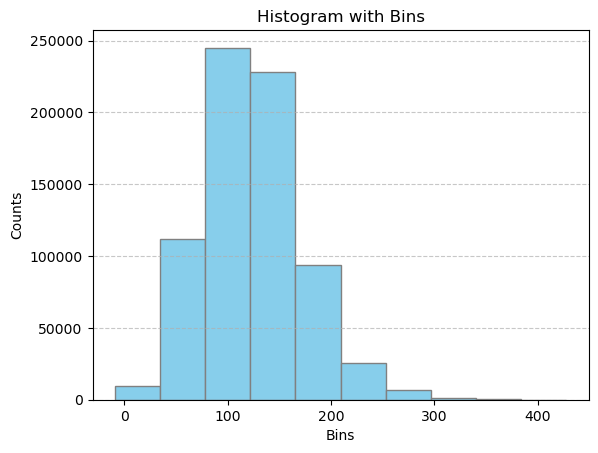

In [92]:
draw_histogram_with_bins(intra_lens)

In [91]:
intra_lens[:10]
max(intra_lens)

449

In [7]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [8]:
model_name = "/root/autodl-tmp/KernelGAT/hg_models/bigbird-roberta-base"
from transformers import BigBirdTokenizer, BigBirdModel, BigBirdConfig
import torch


# tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')
# model = BigBirdModel.from_pretrained('google/bigbird-roberta-base')

# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state

In [10]:
tokenizer = BigBirdTokenizer.from_pretrained(model_name)

In [11]:
tokenizer.special_tokens_map

{'bos_token': '</s>',
 'eos_token': '<s>',
 'unk_token': '<unk>',
 'sep_token': '[SEP]',
 'pad_token': '<pad>',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [12]:
text = "Hello, my dog is cute"
tokenizer.tokenize(text)

['▁Hello', ',', '▁my', '▁dog', '▁is', '▁cute']

In [14]:
ids = tokenizer.encode(text)
print(ids)
print(tokenizer.convert_ids_to_tokens(ids))
print(tokenizer.encode_plus(text))

[65, 18536, 112, 717, 3391, 419, 13880, 66]
['[CLS]', '▁Hello', ',', '▁my', '▁dog', '▁is', '▁cute', '[SEP]']
{'input_ids': [65, 18536, 112, 717, 3391, 419, 13880, 66], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [31]:
with open('/root/autodl-tmp/KernelGAT/data/tagme_bert_train.jsonl', 'r') as f:
    sent_id = []
    for line in f:
        data = json.loads(line)
        tmp = []
        if len(data['evidence']) == 0:
            # print(len(data['evidence']), data['label'])
            continue
        for evid in data['evidence']:
            tmp.append(evid[1])
        sent_id.append(max(tmp) - min(tmp))

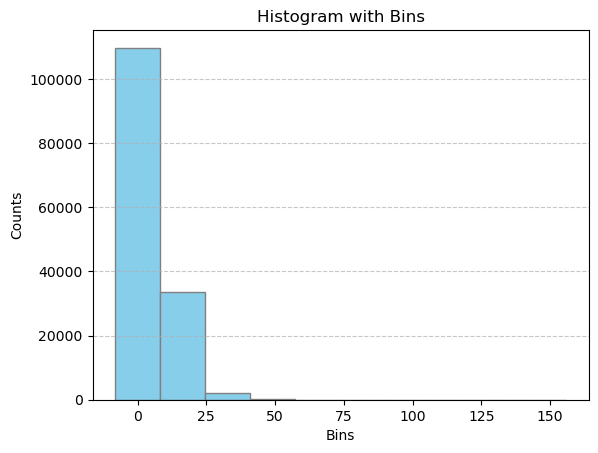

In [32]:
draw_histogram_with_bins(sent_id)

In [33]:
max(sent_id)

164

In [34]:
sent_id[:10]

[9, 4, 14, 20, 6, 7, 11, 6, 5, 20]

In [1]:
from transformers import AutoTokenizer, AutoModel
model_name = '/root/autodl-tmp/KernelGAT/hg_models/bigbird-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, attention_type="original_full")

In [5]:
tokenizer.decode([65,  1413,   524,   358,  3898,   865,    66,     0,     0,     0,
             0,     0,     0])

'[CLS] i have a cat.[SEP]<pad><pad><pad><pad><pad><pad>'

In [19]:
texts = ["i have a cat .", "my favourite pet is dog, his name is wang"]
codes = tokenizer.batch_encode_plus(texts, padding=True, return_tensors="pt")
print(codes)

{'input_ids': tensor([[   65,  1413,   524,   358,  3898,   865,    66,     0,     0,     0,
             0,     0,     0],
        [   65,   717, 12608,  4374,   419,  3391,   112,   566,  1539,   419,
           321, 47663,    66]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [22]:
import torch

In [59]:
inputs = {'input_ids': torch.zeros((2, 5), dtype=int), 'attention_mask': torch.zeros((2, 5), dtype=int)}
print(inputs)
print(model(**inputs))

{'input_ids': tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]), 'attention_mask': tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]])}


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0820,  0.0867,  0.0519,  ...,  0.0477,  0.0065, -0.1044],
         [ 0.0793,  0.0827,  0.0549,  ...,  0.0460,  0.0006, -0.1126],
         [ 0.0795,  0.0829,  0.0548,  ...,  0.0461,  0.0005, -0.1125],
         [ 0.0795,  0.0829,  0.0548,  ...,  0.0462,  0.0004, -0.1126],
         [ 0.0794,  0.0830,  0.0548,  ...,  0.0464,  0.0003, -0.1127]],

        [[ 0.0820,  0.0867,  0.0519,  ...,  0.0477,  0.0065, -0.1044],
         [ 0.0793,  0.0827,  0.0549,  ...,  0.0460,  0.0006, -0.1126],
         [ 0.0795,  0.0829,  0.0548,  ...,  0.0461,  0.0005, -0.1125],
         [ 0.0795,  0.0829,  0.0548,  ...,  0.0462,  0.0004, -0.1126],
         [ 0.0794,  0.0830,  0.0548,  ...,  0.0464,  0.0003, -0.1127]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 0.6571,  0.7334, -0.7809,  ...,  0.8622, -0.0439, -0.7606],
        [ 0.6571,  0.7334, -0.7809,  ...,  0.8622, -0.0439, -0.7606]],
       grad_fn=<TanhBack

In [67]:
print(model.embeddings)
print(model.embeddings.token_type_embeddings)
print(model.embeddings.token_type_ids.shape)

BigBirdEmbeddings(
  (word_embeddings): Embedding(50358, 768, padding_idx=0)
  (position_embeddings): Embedding(4096, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Embedding(2, 768)
torch.Size([1, 4096])


In [66]:
tokenizer("i love nlp")

{'input_ids': [65, 1413, 1943, 400, 34532, 66], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [39]:
inputs = {'input_ids': torch.zeros((2, 5), dtype=int), 'attention_mask': torch.ones((2, 5), dtype=int)}
print(inputs)
print(model(**inputs))

{'input_ids': tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])}
BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1267, -0.0656, -0.1349,  ..., -0.0751,  0.1446, -0.2429],
         [ 0.1262, -0.0587, -0.1267,  ..., -0.0697,  0.1396, -0.2390],
         [ 0.1444, -0.0342, -0.1086,  ..., -0.0487,  0.1247, -0.2135],
         [ 0.1447, -0.0336, -0.1054,  ..., -0.0462,  0.1237, -0.2127],
         [ 0.1453, -0.0307, -0.1017,  ..., -0.0457,  0.1230, -0.2123]],

        [[ 0.1267, -0.0656, -0.1349,  ..., -0.0751,  0.1446, -0.2429],
         [ 0.1262, -0.0587, -0.1267,  ..., -0.0697,  0.1396, -0.2390],
         [ 0.1444, -0.0342, -0.1086,  ..., -0.0487,  0.1247, -0.2135],
         [ 0.1447, -0.0336, -0.1054,  ..., -0.0462,  0.1237, -0.2127],
         [ 0.1453, -0.0307, -0.1017,  ..., -0.0457,  0.1230, -0.2123]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 0.7450,  0.8246, -0

In [52]:
logits = [[-torch.inf] * 10]
logits = torch.tensor(logits)
print(logits)
print(torch.exp(logits))
print(torch.softmax(logits, dim=-1))

tensor([[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])


In [68]:
logits = [[-3.4e38] * 10]
logits = torch.tensor(logits)
print(logits)
print(torch.exp(logits))
print(torch.softmax(logits, dim=-1))

tensor([[-3.4000e+38, -3.4000e+38, -3.4000e+38, -3.4000e+38, -3.4000e+38,
         -3.4000e+38, -3.4000e+38, -3.4000e+38, -3.4000e+38, -3.4000e+38]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]])


In [71]:
logits = [[torch.finfo(torch.float32).min] * 10]
logits = torch.tensor(logits)
print(logits)
print(torch.exp(logits))
print(torch.softmax(logits, dim=-1))

tensor([[-3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38,
         -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]])


In [70]:
torch.finfo(torch.float32).min

-3.4028234663852886e+38

In [8]:
import torch
embs = torch.randint(0, 9, (3, 5, 8), dtype=float)
mask = torch.tensor([
    [1, 1, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 0, 1, 1]
])
print(embs)
print(embs * mask.unsqueeze(-1))
print(torch.mean(embs * mask.unsqueeze(-1), dim=1))

tensor([[[8., 6., 8., 2., 8., 0., 6., 0.],
         [0., 8., 7., 7., 5., 5., 5., 7.],
         [8., 7., 5., 8., 8., 5., 5., 0.],
         [4., 8., 5., 8., 6., 8., 2., 0.],
         [7., 5., 8., 4., 0., 7., 4., 8.]],

        [[8., 3., 4., 0., 0., 2., 7., 0.],
         [2., 4., 7., 6., 8., 8., 3., 2.],
         [1., 7., 4., 6., 3., 1., 1., 2.],
         [1., 4., 4., 3., 0., 5., 0., 3.],
         [8., 2., 2., 7., 6., 1., 1., 2.]],

        [[5., 8., 6., 5., 6., 8., 7., 8.],
         [7., 8., 1., 8., 1., 3., 7., 3.],
         [0., 4., 4., 1., 8., 3., 4., 1.],
         [4., 7., 1., 0., 4., 2., 0., 0.],
         [1., 0., 3., 8., 6., 0., 6., 7.]]], dtype=torch.float64)
tensor([[[8., 6., 8., 2., 8., 0., 6., 0.],
         [0., 8., 7., 7., 5., 5., 5., 7.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [2., 4., 7., 6., 8., 8., 3., 2.],
         [1., 7., 4., 6.,

In [8]:
import torch
embs = torch.randint(0, 9, (2, 5, 8), dtype=float)
mask = torch.tensor([
    [1, 1, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1]
])
print(embs)
embs = embs.repeat_interleave(repeats=2, dim=0)
print("repear_emb:\n", embs)
print(embs * mask.unsqueeze(-1))
print(torch.mean(embs * mask.unsqueeze(-1), dim=1))

tensor([[[1., 8., 0., 3., 5., 2., 6., 3.],
         [7., 4., 7., 4., 7., 6., 7., 6.],
         [7., 3., 6., 5., 6., 6., 6., 5.],
         [8., 3., 3., 0., 4., 8., 2., 8.],
         [2., 3., 1., 4., 8., 1., 0., 1.]],

        [[5., 3., 2., 4., 8., 6., 6., 6.],
         [2., 8., 8., 7., 5., 7., 4., 6.],
         [7., 8., 6., 3., 8., 3., 1., 5.],
         [3., 3., 1., 7., 6., 2., 5., 7.],
         [8., 1., 6., 7., 8., 6., 7., 6.]]], dtype=torch.float64)
repear_emb:
 tensor([[[1., 8., 0., 3., 5., 2., 6., 3.],
         [7., 4., 7., 4., 7., 6., 7., 6.],
         [7., 3., 6., 5., 6., 6., 6., 5.],
         [8., 3., 3., 0., 4., 8., 2., 8.],
         [2., 3., 1., 4., 8., 1., 0., 1.]],

        [[1., 8., 0., 3., 5., 2., 6., 3.],
         [7., 4., 7., 4., 7., 6., 7., 6.],
         [7., 3., 6., 5., 6., 6., 6., 5.],
         [8., 3., 3., 0., 4., 8., 2., 8.],
         [2., 3., 1., 4., 8., 1., 0., 1.]],

        [[5., 3., 2., 4., 8., 6., 6., 6.],
         [2., 8., 8., 7., 5., 7., 4., 6.],
         [7.

In [7]:
import torch.nn as nn
import torch
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
src = torch.rand(10, 32, 512)
out = encoder_layer(src)
print(out.shape)

torch.Size([10, 32, 512])


In [6]:
import torch.nn as nn
import torch
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
src = torch.rand(32, 10, 512)
out = encoder_layer(src)
print(out.shape)

torch.Size([32, 10, 512])


In [3]:
import numpy as np

tau0 = 1.0  # init temperature
temperature = tau0
ANNEAL_RATE=0.0001
MIN_TEMP=0.5
step = 0
while temperature > MIN_TEMP:
    print(step, temperature)
    step += 1
    temperature = np.maximum(tau0 * np.exp(- ANNEAL_RATE * step), MIN_TEMP)

0 1.0
1 0.9999000049998334
2 0.9998000199986667
3 0.9997000449955004
4 0.9996000799893344
5 0.9995001249791693
6 0.9994001799640054
7 0.9993002449428434
8 0.9992003199146838
9 0.9991004048785275
10 0.9990004998333751
11 0.9989006047782277
12 0.9988007197120865
13 0.9987008446339524
14 0.9986009795428268
15 0.998501124437711
16 0.9984012793176064
17 0.9983014441815147
18 0.9982016190284373
19 0.9981018038573762
20 0.9980019986673332
21 0.9979022034573101
22 0.9978024182263091
23 0.9977026429733322
24 0.9976028776973819
25 0.9975031223974602
26 0.9974033770725699
27 0.9973036417217133
28 0.997203916343893
29 0.997104200938112
30 0.9970044955033731
31 0.9969048000386791
32 0.996805114543033
33 0.9967054390154382
34 0.9966057734548978
35 0.996506117860415
36 0.9964064722309934
37 0.9963068365656367
38 0.9962072108633483
39 0.996107595123132
40 0.9960079893439916
41 0.9959083935249311
42 0.9958088076649546
43 0.9957092317630662
44 0.9956096658182702
45 0.9955101098295707
46 0.99541056379597

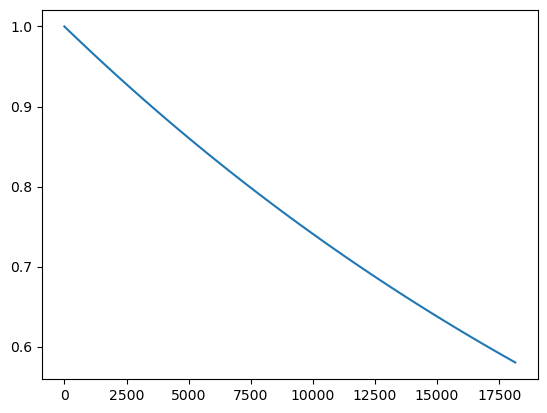

In [21]:
import numpy as np
from matplotlib import pyplot as plt

tau0 = 1.0  # init temperature
temperature = tau0
ANNEAL_RATE=0.00003
MIN_TEMP=0.5
step = 0
steps = [step]
temps = [temperature]
for i in range(50):
    # print(step, temperature)
    step += 18180 // 50
    temperature = np.maximum(tau0 * np.exp(- ANNEAL_RATE * step), MIN_TEMP)
    steps.append(step)
    temps.append(temperature)

plt.plot(steps, temps)

In [5]:
import torch
import torch.nn.functional as F
labels = torch.tensor([1, 0, 1], dtype=torch.long)
probs = torch.tensor([[0.1, 0.9], [0.9, 0.1], [0.2, 0.8]], dtype=torch.float)

res = F.nll_loss(torch.log(probs), labels,reduction='sum')
print(res)

tensor(0.4339)


In [8]:
log_probas = torch.log(probs)
target = labels
mask = torch.tensor([True, False, True])

vocab_size = log_probas.size(-1)
log_probas = log_probas.view(-1, vocab_size)
target = target.view(-1)
mask = mask.view(-1).bool()
loss = F.nll_loss(log_probas[mask], target[mask])
print(loss)

tensor(0.1643)


In [13]:
print(target[mask])

tensor([1, 1])


In [11]:
import torch
import torch.nn.functional as F
labels = torch.tensor([1, 1], dtype=torch.long)
probs = torch.tensor([[0.1, 0.9], [0.2, 0.8]], dtype=torch.float)

res = F.nll_loss(torch.log(probs), labels,reduction='mean')
print(res)

tensor(0.1643)


In [16]:
sent_label = torch.randint(0, 2, (6, 5))
print(sent_label)
idx_1 = 
print(min_id)

tensor([[1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 1],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0]])
tensor([0, 0, 1, 1, 1, 1])
tensor([1, 3, 0, 0, 0, 0])


In [4]:
import torch

# 假设你的张量是一个 PyTorch 张量
tensor = torch.tensor([
    [1, 0, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1],
    [0, 1, 0, 1, 0],
    [0, 1, 0, 1, 0]
])

mask = tensor
print(mask)
one_num = torch.sum(tensor, dim=-1)
one_num[one_num == 0] = 2
print(one_num)
ascend_sorted_indices = torch.argsort(tensor, dim=-1, descending=False)
# descend_sorted_indices = torch.argsort(tensor, dim=-1, descending=True)
print(ascend_sorted_indices)
# print(descend_sorted_indices)
for i in range(6):
    selected_indices = ascend_sorted_indices[i, :one_num[i]]
    print(selected_indices)
    mask[i, selected_indices] = 1
print(mask)


tensor([[1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0]])
tensor([2, 3, 2, 2, 2, 2])
tensor([[1, 3, 4, 0, 2],
        [3, 4, 0, 1, 2],
        [0, 1, 2, 3, 4],
        [0, 2, 3, 1, 4],
        [0, 2, 4, 1, 3],
        [0, 2, 4, 1, 3]])
tensor([1, 3])
tensor([3, 4, 0])
tensor([0, 1])
tensor([0, 2])
tensor([0, 2])
tensor([0, 2])
tensor([[1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0]])


In [1]:
import torch
one_num = torch.tensor([3, 0, 1])
one_num[one_num == 0] = 2
print(one_num)

tensor([3, 2, 1])


In [5]:
import torch.nn.functional as F
label = [0, 1, 0, 1]
pred = [1, 1, 1, 0]
acc = F.accuracy(pred, label)

AttributeError: module 'torch.nn.functional' has no attribute 'accuracy'

In [1]:
import torch
veri_logits = torch.rand(1, 5, requires_grad=True)
veri_label = torch.tensor([1, 0, 1, 1, 0], requires_grad=False)
train_veri_correct_num = torch.sum(torch.argmax(veri_logits, dim=-1) == veri_label)
print(veri_logits)
print(veri_label)
print(train_veri_correct_num.item())

tensor([[0.5830, 0.3359, 0.5859, 0.2931, 0.5274]], requires_grad=True)
tensor([1, 0, 1, 1, 0])
0


In [9]:
train_veri_correct_num.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [20]:
import torch
import torch.nn.functional as F

logits = torch.tensor([
    [0.6, 0.4],
    [0.7, 0.3],
    [0.8, 0.2],
    [0.9, 0.1]
])
gumbel_probs = F.gumbel_softmax(logits=logits, tau=0.5).round(decimals=4)
print(gumbel_probs)

tensor([[0.9609, 0.0391],
        [0.0970, 0.9030],
        [0.9074, 0.0926],
        [0.9834, 0.0166]])


In [7]:
def shorten_sentences(tokenized_sentences, max_length):
    total_len = sum([len(sent) for sent in tokenized_sentences])
    while total_len > max_length:
        sorted_indices = sorted(range(len(tokenized_sentences)), key=lambda i: len(tokenized_sentences[i]), reverse=True)
        longest_ind = sorted_indices[0]
        tokenized_sentences[longest_ind] = tokenized_sentences[longest_ind][:-1]
        total_len = sum([len(sent) for sent in tokenized_sentences])
        print(tokenized_sentences)
        
    # 返回处理后的句子列表
    return tokenized_sentences


# 示例输入
tokenized_sentences = [
    ['This', 'is', 'a', 'very', 'long', 'sentence'],
    ['Short', 'sentence'],
    ['Another', 'quite', 'long', 'sentence', 'here']
]
max_length = 10

# 调用函数进行处理
shortened_sentences = shorten_sentences(tokenized_sentences, max_length)

# 打印结果
for sentence in shortened_sentences:
    print(sentence)


[['This', 'is', 'a', 'very', 'long'], ['Short', 'sentence'], ['Another', 'quite', 'long', 'sentence', 'here']]
[['This', 'is', 'a', 'very'], ['Short', 'sentence'], ['Another', 'quite', 'long', 'sentence', 'here']]
[['This', 'is', 'a', 'very'], ['Short', 'sentence'], ['Another', 'quite', 'long', 'sentence']]
['This', 'is', 'a', 'very']
['Short', 'sentence']
['Another', 'quite', 'long', 'sentence']


In [1]:
import torch

In [6]:
import torch

# 创建一个4x5的二值张量
binary_tensor = torch.tensor([[1, 0, 1, 0, 1],
                              [0, 1, 0, 1, 0],
                              [1, 1, 0, 0, 1],
                              [0, 0, 1, 1, 0]])

# 将原始张量扩展为4x5x2的张量，其中第二个维度上，原来为1的位置标记为[0, 1]
reshaped_tensor = torch.zeros(binary_tensor.size(0), binary_tensor.size(1), 2)
reshaped_tensor[..., 0] = 1 - binary_tensor  # 在第一个通道上，将原来为1的位置变为0
reshaped_tensor[..., 1] = binary_tensor      # 在第二个通道上，将原来为1的位置标记为1

# 打印结果
print("原始张量大小:", binary_tensor.size())
print("重塑后的张量大小:", reshaped_tensor.size())
print("原始张量:\n", binary_tensor)
print("重塑后的张量:")
print(reshaped_tensor)


原始张量大小: torch.Size([4, 5])
重塑后的张量大小: torch.Size([4, 5, 2])
原始张量:
 tensor([[1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0],
        [1, 1, 0, 0, 1],
        [0, 0, 1, 1, 0]])
重塑后的张量:
tensor([[[0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.]],

        [[1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.]],

        [[0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [0., 1.]],

        [[1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.]]])


In [1]:
import torch

model = torch.load('/root/autodl-tmp/KernelGAT/logs/gumbel/04-02-2024/official_basemodel_3-seed42-epoch10.0-bsz10-lr2e-05/checkpoint_best_14545.pt')

In [3]:
model['model']

KeyError: 'model'